# ML-based Data-driven Traffic Flow Estimation from Mobile Data



### Content
<em> I. Data Preparetion </em><br>
<em> II. Baseline Model </em><br>
<em> III. Neural Network Model </em><br>
<em> IV. Estimation Model Deployment (Google Cloud Paltform) </em>

# <em>Part I. Data Preparation </em>

1. removing INRIX instance row with low confidence value in the datasets
2. smoothening: moving average
3. shifting time-delay between INRIX and MCS speed
4. matching timesteps of MCS instances with INRIX instances
5. adding temporal factor as input features
6. adding spatial factor as an input feature


# 0. Environment Setting

## 0.1 Import Libraries & Define Constants

In [3]:
from google.colab import drive
import googleapiclient.discovery

import os
import sys
from datetime import datetime
from datetime import timedelta

import numpy as np

import pandas as pd

import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Concatenate
from keras.utils import plot_model
from keras.losses import MeanAbsolutePercentageError

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator, AutoDateFormatter, HourLocator
from matplotlib.ticker import PercentFormatter

import seaborn

import json

# Constants:
# constants for Smoothening
MOVING_AVERAGE_WINDOW = 30
SCORE_THRESHOLD = 20

# speed threshold (critical speed) for separating the traffic regime
THRESHOLD = 0

# defining the main fitting road segment
MAIN = 'south'
NEIGHBOR = 'north'

# error of each model for plotting barchart
mainMAPEs = []
neighborMAPEs = []
mainRMSEs = []
neighborRMSEs = []

# the standardizer select
HISTORICALSTANDAR = True
MODEL_VERSION = 'historical_scaler'

In [4]:
print('python version: ', sys.version)
print('pnadas version: ', pd.__version__)
print('numpy version: ', np.__version__)
print('scikit-learn version', sklearn.__version__)
print('tensorflow version: ', tf.__version__)
print('keras version: ', keras.__version__)

python version:  3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
pnadas version:  1.1.5
numpy version:  1.19.5
scikit-learn version 0.22.2.post1
tensorflow version:  2.4.1
keras version:  2.4.0


## 0.2 Mount Google drive, Set working directory to 'Data' directory

In [5]:
# mount the google drive to the virtural machine
drive.mount('/content/gdrive')

print('original working directory: ', os.path.abspath('.'))

# set the root path to the directory of the degree project on google drive
root_path = '/content/gdrive/My Drive/degree_project/' 

# set the working directory to the 'data'
os.chdir(root_path + 'data')
print('current working directory: ', os.getcwd())

Mounted at /content/gdrive
original working directory:  /content
current working directory:  /content/gdrive/My Drive/degree_project/data


## 0.3 helper functions

In [6]:
# helper function used to get the numerical index(number of the row) of the first timestamp of certain day
# use "date" as the target timestamp
def idx(dataFrame, date):
  
  if (date == 1): 
    return 0
  if (date == 99):
    return len(dataFrame)
  targerDatetime = datetime(year=2018, month=10, day=date, hour=0, minute=0, second=0)
  try:
    index = dataFrame[dataFrame.date == targerDatetime].index.values[0]
  except:
    targerDatetime2 = datetime(year=2018, month=10, day=date, hour=0, minute= 10, second=0)
    index = dataFrame[dataFrame.date == targerDatetime2].index.values[0]

  return index

In [7]:
# plot 1 y attribute vs. 1 x attribute from 2 different dataframes in a same diagram
def plotAttr2DF(dataFrame1, dataFrame2, xAxis, attribute, label1, label2, title):
  plt.plot(dataFrame1[xAxis], dataFrame1[attribute], 'b',linewidth = 0.8, label = label1)
  plt.plot(dataFrame2[xAxis], dataFrame2[attribute], 'r', linewidth = 1.5, label = label2)
  plt.xlabel('epoch(sec)', fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(attribute, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(attribute + ' vs. time (' + title + ')', fontsize = 14)
  plt.grid()
  plt.legend()
  plt.show()

In [8]:
# plot 1 y attribute vs. 2 different x attribute from 2 different dataframes in a same diagram
def plotAttr2DF2X(dataFrame1, dataFrame2, xAttribute1, xAttribute2, yAttribute, label1, label2, title):
  plt.plot(dataFrame1[xAttribute1], dataFrame1[yAttribute], 'b',linewidth = 0.8, label = label1)
  plt.plot(dataFrame2[xAttribute2], dataFrame2[yAttribute], 'r', linewidth = 0.8, label = label2)
  plt.xlabel('epoch(sec)', fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(yAttribute, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(yAttribute + ' vs. time (' + title + ')', fontsize = 14)
  plt.grid()
  plt.legend()
  plt.show()

In [9]:
# function to plot 1 attributes (vs. Epochs) from 1 sensor
def plotAttr(days, dataFrame, attribute, sensor_name):
  plt.style.use('default')
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute], 'r', linewidth = 0.8, label = sensor_name)
  plt.xlabel('Epochs(sec)', fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(attribute, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(attribute + ' vs. time (' + str(days) + ' )', fontsize = 18)
  plt.legend()
  plt.grid()
  plt.show()

In [10]:
# function to plot 2 attributes (vs. Epochs) from 2 different senesors in a same diagram
def plot2Attr(title, dataFrame, attribute1, attribute2, attributeType):
  plt.style.use('default')
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute1], 'r',linewidth = 1.2, label = attribute1)
  plt.plot(dataFrame['Epoch_mcs'], dataFrame[attribute2], 'b', linewidth = 1.2, label = attribute2)
  plt.xlabel('Epochs(sec)', fontsize= 14)
  plt.xticks(fontsize=14)
  plt.ylabel(attributeType, fontsize=14)
  plt.yticks(fontsize=14)
  plt.title(attributeType + ' vs. time (' + title + ' )', fontsize = 14)
  plt.legend()
  plt.show()

In [11]:
# scatter plot with 1 data2[attribute2] vs. data1[atttribute1]
def plotScatter(data1, data2, attribute1, attribute2, Label, xLabelUnit, yLabelUnit, legendLoc):
  plt.style.use('default')
  plt.scatter(data1[attribute1], data2[attribute2], facecolors='none', edgecolors='black', s=7, label=Label)
  plt.xlabel(attribute1 + xLabelUnit, fontsize = 15)
  plt.xticks(fontsize = 14)
  plt.yticks(fontsize = 14)
  plt.ylabel(attribute2 + yLabelUnit, fontsize = 15)
  plt.legend(loc=legendLoc)
  plt.title(attribute2 + '  vs. ' + attribute1, fontsize = 14)
  plt.show()

In [12]:
# scatter plot with data1/2[attribute2] vs. data1/2[atttribute1] (2 curve)
def plotScatterSegments(data1, data2, attribute1, attribute2, label1, label2, title, legendLoc):
  plt.style.use('default')
  plt.scatter(data1[attribute1], data1[attribute2], s=1.6, color = 'blue',  label=label1)
  plt.scatter(data2[attribute1], data2[attribute2], s=1.6, color = 'red',  label=label2)
  plt.xlabel(attribute1, fontsize = 15)
  plt.xticks(fontsize = 14)
  plt.yticks(fontsize = 14)
  plt.ylabel(attribute2, fontsize = 15)
  plt.legend(loc=legendLoc)
  plt.title(attribute2 + '  vs. ' + attribute1 + title, fontsize = 14)
  plt.show()

In [13]:
# visualize instances (scatter) and the model curve (plot)
# plot 3 curves: 1 threshold line (X0, Y0), 1 free-flow model (X1, Y1), 1 congested-model (X2, Y2), data-set instances (dataframe, attribute1, attribute2)
def plotScatterModel(dataframe, attribute1, attribute2, labelData, X0, Y0, X1, Y1, label1, X2, Y2, label2, xLabelUnit, yLabelUnit, legendLoc):
  plt.scatter(dataframe[attribute1], dataframe[attribute2], facecolors='none', edgecolors='gray', s=7, label=labelData)
  plt.plot(X1, Y1, color='black', linewidth=2, ls='solid', label=label1)
  plt.plot(X2, Y2, color='black', linewidth=2, ls='dashed', label=label2)
  plt.plot(X0, Y0, color='green', linewidth=2.0)
  plt.xlabel(attribute1 + xLabelUnit, fontsize = 15)
  plt.xticks(fontsize = 14)
  plt.yticks(fontsize = 14)
  plt.ylabel(attribute2 + yLabelUnit, fontsize = 15)
  plt.grid()
  plt.legend(loc=legendLoc, fontsize=10)
  plt.title(attribute2 + '  vs. ' + attribute1, fontsize = 14)
  plt.show()

In [14]:
# helper function to plot fitting results
# function to plot the predicted value and real label value according to training/testing dataset
def plotResult(xTrain, yTrain, yPredTrain, xTest, yTest, yPredTest, timeRange, xLabel, yLabel, plotStyle = 's'):
  plt.style.use('default')
  if (xTest is not None):
    plt.scatter(xTrain, yTrain, s=3, color='black', label='real flow(train_set)')
    plt.scatter(xTrain, yPredTrain, s= 25, color='blue', marker = "s", label='predicted flow(train_set)')
    plt.scatter(xTest, yTest, color='red', s=3, label='real flow(test_set)')
    plt.scatter(xTest, yPredTest, color='green', s=25, marker = 's', label='predicted flow(test_set)')
  elif (plotStyle == 'p'):
    plt.plot(xTrain, yPredTrain, linewidth=1.5, color='blue', linestyle = 'dashed', mfc='none',  label='predicted flow', zorder= 0, marker='o')
    plt.scatter(xTrain, yTrain, s=3, color='red', label='real flow', zorder= 10)
  elif (plotStyle == 's'):
    plt.scatter(xTrain, yTrain, s = 3, color='green', label='real flow(train_set)', zorder = 0)
    plt.scatter(xTrain, yPredTrain, s= 15, color='red', marker = "s", facecolors='none', label='predicted flow(train_set)', zorder = 1)
    
  plt.xlabel(xLabel, fontsize= 15) 
  plt.xticks(fontsize = 10)
  plt.ylabel(yLabel, fontsize=15)
  plt.yticks(fontsize = 10)
  plt.title('Regression model for estimation of ' + yLabel + ' in ' + timeRange, fontsize= 14)
  plt.legend(fontsize=12, loc=1)
  plt.grid()
  plt.show()

In [15]:
# helper function for calculating MAPE
# Input: two numpy array with same shape (batch_size, )
# Output: MAPE in percentage(%)
def mape(y, y_predict):
  absSum = 0.0
  n = y.shape[0]
  for i in range(n):
    error = abs((y[i].item() - y_predict[i].item())/y[i].item())
    absSum += error
  return 100 * absSum/n


# 1. Import datasets from csv files


*   mcs north: mcsNorth.csv
*   mcs south: mcsSouth.csv
*   inrix sou: 

Note: north (upstream)->south(downstream), southbound road segment



## 1.0 Import MCS data

In [ ]:
# import processed mcs datasets(North/South)
mcs = pd.read_csv("InData/mcs_1159_1162_oct2018.csv", delimiter = ',')

In [ ]:
mcs.head(5)

fk_id                 date    speed  speed_std_dev  flow    used_lanes
0   1159  2018-10-01 00:00:00  26.6028        7.18940   165     {1,1,1,1}
1   1159  2018-10-01 00:01:00  26.0600        4.10961   160  {1,1,1,NULL}
2   1159  2018-10-01 00:02:00  25.0705        9.05539   105     {1,1,1,1}
3   1159  2018-10-01 00:03:00  27.2009        4.54606   220  {1,1,1,NULL}
4   1159  2018-10-01 00:04:00  24.9600        7.93025   180  {1,1,1,NULL}

In [ ]:
# show mcs north road segment
mcs[mcs.fk_id.eq(1162)].head(5)

fk_id                 date    speed  speed_std_dev  flow    used_lanes
44285   1162  2018-10-01 00:00:00  23.1675        2.16025   220  {1,1,1,NULL}
44286   1162  2018-10-01 00:01:00  21.5449        6.84755   100  {1,1,1,NULL}
44287   1162  2018-10-01 00:02:00  24.2640       14.70450   200  {1,1,1,NULL}
44288   1162  2018-10-01 00:03:00  22.5872        1.41421   180  {1,1,1,NULL}
44289   1162  2018-10-01 00:04:00  22.7721       10.03330   280  {1,1,1,NULL}

## 2.0 Import INRIX data (raw data, unprocessed)

In [ ]:
# import un-processed inrix dataset
inrix = pd.read_csv("InData/inrix_225285973_1071883675_oct2018.csv", delimiter= ',')

In [ ]:
inrix.head(5)

segmentid         timestamputc  ... speedbucket               registered
0  225285973  2018-10-01 00:00:14  ...           3   2018-10-01 02:00:14.49
1  225285973  2018-10-01 00:01:12  ...           3  2018-10-01 02:01:12.193
2  225285973  2018-10-01 00:02:10  ...           3   2018-10-01 02:02:10.25
3  225285973  2018-10-01 00:03:11  ...           3  2018-10-01 02:03:11.093
4  225285973  2018-10-01 00:04:11  ...           3  2018-10-01 02:04:11.653

[5 rows x 11 columns]

In [ ]:
inrix[inrix.segmentid.eq(1071883675)].head(5)

segmentid         timestamputc  ... speedbucket               registered
44596  1071883675  2018-10-01 00:00:12  ...           3   2018-10-01 02:00:12.39
44597  1071883675  2018-10-01 00:01:10  ...           3   2018-10-01 02:01:10.49
44598  1071883675  2018-10-01 00:02:08  ...           3  2018-10-01 02:02:08.533
44599  1071883675  2018-10-01 00:03:09  ...           3   2018-10-01 02:03:09.14
44600  1071883675  2018-10-01 00:04:10  ...           3  2018-10-01 02:04:10.047

[5 rows x 11 columns]

# 2. Data Preparation for INRIX data




## 2.1 Pre-process INRIX data
*   examine the INRIX's data-type and summary
*   transfer units
*   transfer 'registered' to datetime format





In [ ]:
inrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89193 entries, 0 to 89192
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   segmentid          89193 non-null  int64  
 1   timestamputc       89193 non-null  object 
 2   segmenttype        89193 non-null  object 
 3   speed              89193 non-null  int64  
 4   average            89193 non-null  int64  
 5   reference          89193 non-null  int64  
 6   traveltimeminutes  89193 non-null  float64
 7   score              89193 non-null  int64  
 8   cvalue             89193 non-null  int64  
 9   speedbucket        89193 non-null  int64  
 10  registered         89193 non-null  object 
dtypes: float64(1), int64(7), object(3)
memory usage: 7.5+ MB


In [ ]:
inrix.describe()

segmentid         speed  ...        cvalue   speedbucket
count  8.919300e+04  89193.000000  ...  89193.000000  89193.000000
mean   6.485896e+08     72.411523  ...     76.437512      2.866178
std    4.233012e+08     13.314561  ...     30.278143      0.459020
min    2.252860e+08      6.000000  ...     -1.000000      0.000000
25%    2.252860e+08     68.000000  ...     66.000000      3.000000
50%    1.071884e+09     74.000000  ...     90.000000      3.000000
75%    1.071884e+09     79.000000  ...     99.000000      3.000000
max    1.071884e+09    138.000000  ...    100.000000      3.000000

[8 rows x 8 columns]

In [ ]:
# Convert unit of travel_time from minute to sec
inrix['travel_time_secs'] = inrix.traveltimeminutes * 60.0

# drop unnecessary columns
inrix.drop(columns = ['segmenttype', 'traveltimeminutes'], inplace=True)

In [ ]:
inrix.head(5)

segmentid         timestamputc  ...               registered  travel_time_secs
0  225285973  2018-10-01 00:00:14  ...   2018-10-01 02:00:14.49             19.92
1  225285973  2018-10-01 00:01:12  ...  2018-10-01 02:01:12.193             19.92
2  225285973  2018-10-01 00:02:10  ...   2018-10-01 02:02:10.25             19.92
3  225285973  2018-10-01 00:03:11  ...  2018-10-01 02:03:11.093             19.92
4  225285973  2018-10-01 00:04:11  ...  2018-10-01 02:04:11.653             19.92

[5 rows x 10 columns]

In [ ]:
# convert the string type timestamp 'regiestered' and 'timestamputc' to datatime object
# strip the unnecessary tail of 'registered
stripTail = lambda x: x.split('.')[0]
inrix['registered'] = inrix.registered.apply(stripTail)

# convert column "registered" into Datetime objects, add into a new column "date_inrix"
convertToDateR = lambda row: datetime.strptime(row['registered'], "%Y-%m-%d %H:%M:%S")
inrix['date_inrix'] = inrix.apply(convertToDateR, axis=1)

# convert column "timestamputc" into Datetime objects, add into original column "timestamputc"
convertToDateU = lambda row: datetime.strptime(row['timestamputc'], "%Y-%m-%d %H:%M:%S")
inrix['timestamputc'] = inrix.apply(convertToDateU, axis=1)

# check data type of timestamps
print(inrix.info())
inrix.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89193 entries, 0 to 89192
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   segmentid         89193 non-null  int64         
 1   timestamputc      89193 non-null  datetime64[ns]
 2   speed             89193 non-null  int64         
 3   average           89193 non-null  int64         
 4   reference         89193 non-null  int64         
 5   score             89193 non-null  int64         
 6   cvalue            89193 non-null  int64         
 7   speedbucket       89193 non-null  int64         
 8   registered        89193 non-null  object        
 9   travel_time_secs  89193 non-null  float64       
 10  date_inrix        89193 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(7), object(1)
memory usage: 7.5+ MB
None


segmentid        timestamputc  ...  travel_time_secs          date_inrix
0  225285973 2018-10-01 00:00:14  ...             19.92 2018-10-01 02:00:14
1  225285973 2018-10-01 00:01:12  ...             19.92 2018-10-01 02:01:12
2  225285973 2018-10-01 00:02:10  ...             19.92 2018-10-01 02:02:10
3  225285973 2018-10-01 00:03:11  ...             19.92 2018-10-01 02:03:11
4  225285973 2018-10-01 00:04:11  ...             19.92 2018-10-01 02:04:11

[5 rows x 11 columns]

In [ ]:
# drop columns 'registered'
inrix.drop(columns='registered', inplace=True)
inrix.head(5)

segmentid        timestamputc  ...  travel_time_secs          date_inrix
0  225285973 2018-10-01 00:00:14  ...             19.92 2018-10-01 02:00:14
1  225285973 2018-10-01 00:01:12  ...             19.92 2018-10-01 02:01:12
2  225285973 2018-10-01 00:02:10  ...             19.92 2018-10-01 02:02:10
3  225285973 2018-10-01 00:03:11  ...             19.92 2018-10-01 02:03:11
4  225285973 2018-10-01 00:04:11  ...             19.92 2018-10-01 02:04:11

[5 rows x 10 columns]

## 2.2 Remove low confidence instances in INRIX dataset
* remove the instances with score < 30 (4.7%)

In [ ]:
inrix.score.value_counts()

30    84641
10     4244
20      308
Name: score, dtype: int64

In [ ]:
# remove INRIX instances with low score
inrix_removed = inrix[inrix.score >= SCORE_THRESHOLD]
inrix_removed.reset_index(drop=True, inplace=True)


In [ ]:
print(inrix_removed.score.value_counts())
print(len(inrix_removed))

30    84641
20      308
Name: score, dtype: int64
84949


## 2.3 Split Inrix_South and Inrix_North
1. split INRIX into south and north two dataframes for future processing, eg., epoch calucation.
2. calculate epoch from date_inrix (origin 'registered')


In [ ]:
# Split Inrix South and North
inrixSouth = inrix_removed[inrix_removed.segmentid == 1071883675]
inrixNorth = inrix_removed[inrix_removed.segmentid == 225285973]
inrixSouth.reset_index(drop=True, inplace=True)
inrixNorth.reset_index(drop=True, inplace=True)
print(len(inrixSouth))
print(len(inrixNorth))
print(len(inrix_removed))

42532
42417
84949


In [ ]:
inrixSouth[:5]

segmentid        timestamputc  ...  travel_time_secs          date_inrix
0  1071883675 2018-10-01 00:00:12  ...             44.28 2018-10-01 02:00:12
1  1071883675 2018-10-01 00:01:10  ...             44.28 2018-10-01 02:01:10
2  1071883675 2018-10-01 00:02:08  ...             42.90 2018-10-01 02:02:08
3  1071883675 2018-10-01 00:03:09  ...             42.90 2018-10-01 02:03:09
4  1071883675 2018-10-01 00:04:10  ...             42.90 2018-10-01 02:04:10

[5 rows x 10 columns]

In [ ]:
inrixNorth[:5]

segmentid        timestamputc  ...  travel_time_secs          date_inrix
0  225285973 2018-10-01 00:00:14  ...             19.92 2018-10-01 02:00:14
1  225285973 2018-10-01 00:01:12  ...             19.92 2018-10-01 02:01:12
2  225285973 2018-10-01 00:02:10  ...             19.92 2018-10-01 02:02:10
3  225285973 2018-10-01 00:03:11  ...             19.92 2018-10-01 02:03:11
4  225285973 2018-10-01 00:04:11  ...             19.92 2018-10-01 02:04:11

[5 rows x 10 columns]

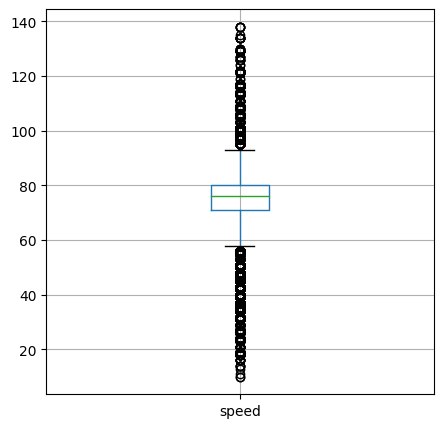

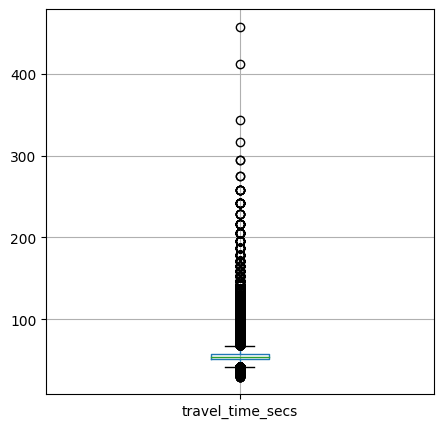

In [ ]:
# check the distribution of inrix speed and travel time corresponding to 2 datasets respectively
# check if there is any outlier needs to be filtered
plt.style.use('default')
plt.figure(1, figsize=(5, 5))
boxplot1 = inrixSouth.boxplot(column=['speed'])

plt.figure(2, figsize=(5, 5))
boxplot2 = inrixSouth.boxplot(column=['travel_time_secs']) 

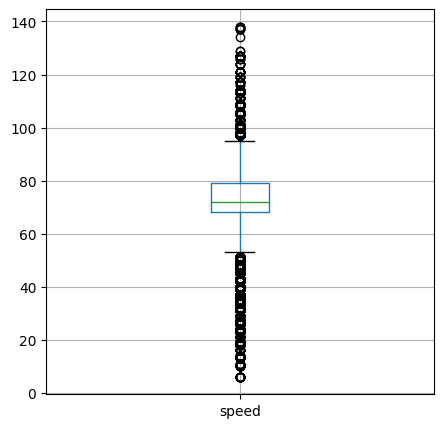

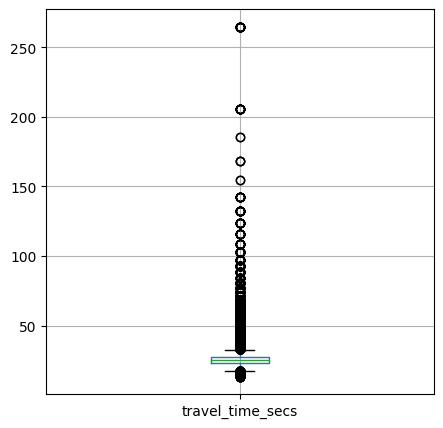

In [ ]:
# check the distribution of inrix speed and travel time corresponding to 2 datasets respectively
# check if there is any outlier needs to be filtered
plt.style.use('default')
plt.figure(1, figsize=(5, 5))
boxplot1 = inrixNorth.boxplot(column=['speed'])

plt.figure(2, figsize=(5, 5))
boxplot2 = inrixNorth.boxplot(column=['travel_time_secs']) 

## 2.2.1 Calculate the INRIX's Epoch from 'date_inrix' timestamp



In [ ]:
# function to calculate Epoch between start timestep and current timestep
# Output: float number Epoch (sec)
def calEpoch(dataFrame, colName, i):
  delta = dataFrame.loc[i, colName] - dataFrame.loc[0, colName]
  return delta.total_seconds()

In [ ]:
inrixSouth['Epoch_inrix'] = 0.0
inrixNorth['Epoch_inrix'] = 0.0

# calculate the epoch of inrix from their timestamp
# + 120 sec (2 hours) to align with the mce timestamps, which is started from 01.10.2018 00:00
for i in range(len(inrixSouth)):
  inrixSouth.at[i, 'Epoch_inrix'] = calEpoch(inrixSouth, 'date_inrix', i) + 120.0 * 60

for i in range(len(inrixNorth)):
  inrixNorth.at[i, 'Epoch_inrix'] = calEpoch(inrixNorth, 'date_inrix', i) + 120.0 * 60


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
inrixSouth.head(5)

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0  1071883675 2018-10-01 00:00:12  ... 2018-10-01 02:00:12       7200.0
1  1071883675 2018-10-01 00:01:10  ... 2018-10-01 02:01:10       7258.0
2  1071883675 2018-10-01 00:02:08  ... 2018-10-01 02:02:08       7316.0
3  1071883675 2018-10-01 00:03:09  ... 2018-10-01 02:03:09       7377.0
4  1071883675 2018-10-01 00:04:10  ... 2018-10-01 02:04:10       7438.0

[5 rows x 11 columns]

In [ ]:
inrixNorth.head(5)

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0  225285973 2018-10-01 00:00:14  ... 2018-10-01 02:00:14       7200.0
1  225285973 2018-10-01 00:01:12  ... 2018-10-01 02:01:12       7258.0
2  225285973 2018-10-01 00:02:10  ... 2018-10-01 02:02:10       7316.0
3  225285973 2018-10-01 00:03:11  ... 2018-10-01 02:03:11       7377.0
4  225285973 2018-10-01 00:04:11  ... 2018-10-01 02:04:11       7437.0

[5 rows x 11 columns]

## 2.4 Smoothen the INRIX data


*   Moving Average Window Size = MOVING_AVERAGE_WINDOW



### 2.4.1 smoothen the INRIX South

In [ ]:
# observe the first 5 rows and last 5 rows of inrix dataset (before smoothening)
inrixSouth

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      1071883675 2018-10-01 00:00:12  ... 2018-10-01 02:00:12       7200.0
1      1071883675 2018-10-01 00:01:10  ... 2018-10-01 02:01:10       7258.0
2      1071883675 2018-10-01 00:02:08  ... 2018-10-01 02:02:08       7316.0
3      1071883675 2018-10-01 00:03:09  ... 2018-10-01 02:03:09       7377.0
4      1071883675 2018-10-01 00:04:10  ... 2018-10-01 02:04:10       7438.0
...           ...                 ...  ...                 ...          ...
42527  1071883675 2018-10-31 23:55:12  ... 2018-11-01 00:55:11    2681699.0
42528  1071883675 2018-10-31 23:56:08  ... 2018-11-01 00:56:08    2681756.0
42529  1071883675 2018-10-31 23:57:08  ... 2018-11-01 00:57:08    2681816.0
42530  1071883675 2018-10-31 23:58:09  ... 2018-11-01 00:58:08    2681876.0
42531  1071883675 2018-10-31 23:59:08  ... 2018-11-01 00:59:08    2681936.0

[42532 rows x 11 columns]

In [ ]:
# smoothen the inrixSouth speed column by centered moving average
rolling_speed = inrixSouth.speed.rolling(window=MOVING_AVERAGE_WINDOW, center=True, win_type='triang')
rolling_mean_speed = rolling_speed.mean()
rolling_mean_speed.iloc[10:20]

10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15    73.806667
16    72.988889
17    72.304444
18    71.762222
19    71.348889
Name: speed, dtype: float64

In [ ]:
# smoothen the inrixSouth travel time column by moving average
rolling_travelTime = inrixSouth.travel_time_secs.rolling(window=MOVING_AVERAGE_WINDOW, center=True, win_type='triang')
rolling_mean_travelTime = rolling_travelTime.mean()

In [ ]:
# add the smoothened columns back to the inrixSouth datafram
inrixSouth_smoothened = inrixSouth.copy()
inrixSouth_smoothened.speed = rolling_mean_speed
inrixSouth_smoothened.travel_time_secs = rolling_mean_travelTime
inrixSouth_smoothened.iloc[5:20]

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
5   1071883675 2018-10-01 00:05:11  ... 2018-10-01 02:05:11       7499.0
6   1071883675 2018-10-01 00:06:11  ... 2018-10-01 02:06:10       7558.0
7   1071883675 2018-10-01 00:07:08  ... 2018-10-01 02:07:08       7616.0
8   1071883675 2018-10-01 00:08:09  ... 2018-10-01 02:08:09       7677.0
9   1071883675 2018-10-01 00:09:10  ... 2018-10-01 02:09:10       7738.0
10  1071883675 2018-10-01 00:10:12  ... 2018-10-01 02:10:12       7800.0
11  1071883675 2018-10-01 00:11:12  ... 2018-10-01 02:11:12       7860.0
12  1071883675 2018-10-01 00:12:09  ... 2018-10-01 02:12:09       7917.0
13  1071883675 2018-10-01 00:13:08  ... 2018-10-01 02:13:08       7976.0
14  1071883675 2018-10-01 00:14:08  ... 2018-10-01 02:14:08       8036.0
15  1071883675 2018-10-01 00:15:11  ... 2018-10-01 02:15:11       8099.0
16  1071883675 2018-10-01 00:16:09  ... 2018-10-01 02:16:09       8157.0
17  1071883675 2018-10-01 00:17:14  ... 2018-10-01 02:17:14       8222.0
18  1071883675 2018-10-01 00:18:08  ... 2018-10-01 02:18:08       8276.0
19  1071883675 2018-10-01 00:19:09  ... 2018-10-01 02:19:09       8337.0

[15 rows x 11 columns]

In [ ]:
# remove the speed, travel time rows with NaN value due to the moving average process
inrixSouth_smoothened = inrixSouth_smoothened.dropna()
inrixSouth_smoothened.reset_index(inplace=True, drop=True)
inrixSouth_smoothened

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      1071883675 2018-10-01 00:15:11  ... 2018-10-01 02:15:11       8099.0
1      1071883675 2018-10-01 00:16:09  ... 2018-10-01 02:16:09       8157.0
2      1071883675 2018-10-01 00:17:14  ... 2018-10-01 02:17:14       8222.0
3      1071883675 2018-10-01 00:18:08  ... 2018-10-01 02:18:08       8276.0
4      1071883675 2018-10-01 00:19:09  ... 2018-10-01 02:19:09       8337.0
...           ...                 ...  ...                 ...          ...
42498  1071883675 2018-10-31 23:41:08  ... 2018-11-01 00:41:08    2680856.0
42499  1071883675 2018-10-31 23:42:09  ... 2018-11-01 00:42:09    2680917.0
42500  1071883675 2018-10-31 23:43:08  ... 2018-11-01 00:43:08    2680976.0
42501  1071883675 2018-10-31 23:44:09  ... 2018-11-01 00:44:08    2681036.0
42502  1071883675 2018-10-31 23:45:15  ... 2018-11-01 00:45:15    2681103.0

[42503 rows x 11 columns]

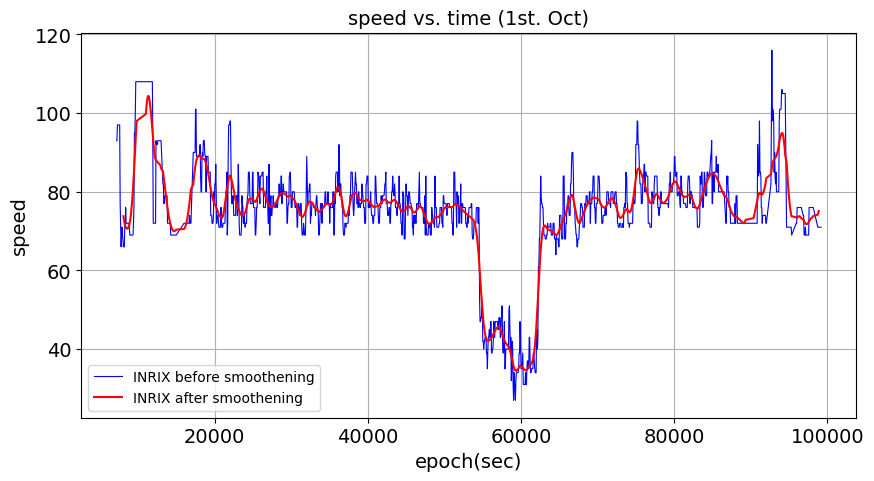

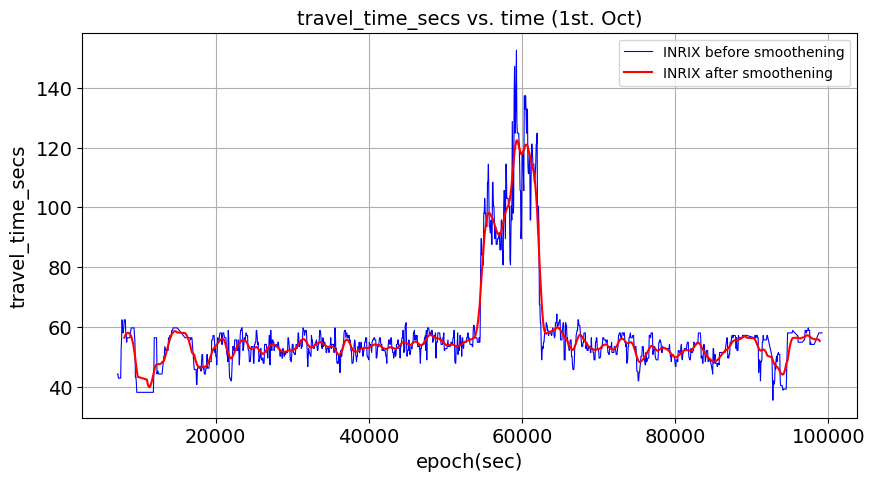

In [ ]:
# Plot original speed and smoothened speed for INRIX
n = 1
plt.figure(figsize=(10, 5))
plt.style.use('default')
plotAttr2DF(inrixSouth.iloc[0:1440*n], inrixSouth_smoothened.iloc[0:1420*n], 
            'Epoch_inrix', 'speed', 'INRIX before smoothening', 'INRIX after smoothening', '1st. Oct')

# Plot original travel time and smoothened one for INRIX
plt.figure(figsize=(10, 5))
plotAttr2DF(inrixSouth.iloc[0:1440*n], inrixSouth_smoothened.iloc[0:1420*n], 
            'Epoch_inrix', 'travel_time_secs', 'INRIX before smoothening', 'INRIX after smoothening', '1st. Oct')

### 2.4.2 smoothen the INRIX North

In [ ]:
# observe the first 5 rows and last 5 rows of inrix dataset (before smoothening)
inrixNorth

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      225285973 2018-10-01 00:00:14  ... 2018-10-01 02:00:14       7200.0
1      225285973 2018-10-01 00:01:12  ... 2018-10-01 02:01:12       7258.0
2      225285973 2018-10-01 00:02:10  ... 2018-10-01 02:02:10       7316.0
3      225285973 2018-10-01 00:03:11  ... 2018-10-01 02:03:11       7377.0
4      225285973 2018-10-01 00:04:11  ... 2018-10-01 02:04:11       7437.0
...          ...                 ...  ...                 ...          ...
42412  225285973 2018-10-31 23:55:13  ... 2018-11-01 00:55:13    2681699.0
42413  225285973 2018-10-31 23:56:09  ... 2018-11-01 00:56:09    2681755.0
42414  225285973 2018-10-31 23:57:10  ... 2018-11-01 00:57:09    2681815.0
42415  225285973 2018-10-31 23:58:11  ... 2018-11-01 00:58:10    2681876.0
42416  225285973 2018-10-31 23:59:10  ... 2018-11-01 00:59:10    2681936.0

[42417 rows x 11 columns]

In [ ]:
# smoothen the inrix north speed column by centered moving average
rolling_speed = inrixNorth.speed.rolling(window=MOVING_AVERAGE_WINDOW, center=True, win_type='triang')
rolling_mean_speed = rolling_speed.mean()
rolling_mean_speed.iloc[10:20]

10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15    68.871111
16    68.226667
17    67.768889
18    67.497778
19    67.360000
Name: speed, dtype: float64

In [ ]:
# smoothen the inrixSouth travel time column by moving average
rolling_travelTime = inrixNorth.travel_time_secs.rolling(window=MOVING_AVERAGE_WINDOW, center=True, win_type='triang')
rolling_mean_travelTime = rolling_travelTime.mean()

In [ ]:
# add the smoothened columns back to the inrixSouth datafram
inrixNorth_smoothened = inrixNorth.copy()
inrixNorth_smoothened.speed = rolling_mean_speed
inrixNorth_smoothened.travel_time_secs = rolling_mean_travelTime
inrixNorth_smoothened.iloc[5:20]

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
5   225285973 2018-10-01 00:05:13  ... 2018-10-01 02:05:13       7499.0
6   225285973 2018-10-01 00:06:12  ... 2018-10-01 02:06:12       7558.0
7   225285973 2018-10-01 00:07:10  ... 2018-10-01 02:07:10       7616.0
8   225285973 2018-10-01 00:08:11  ... 2018-10-01 02:08:11       7677.0
9   225285973 2018-10-01 00:09:12  ... 2018-10-01 02:09:12       7738.0
10  225285973 2018-10-01 00:10:14  ... 2018-10-01 02:10:14       7800.0
11  225285973 2018-10-01 00:11:14  ... 2018-10-01 02:11:14       7860.0
12  225285973 2018-10-01 00:12:11  ... 2018-10-01 02:12:11       7917.0
13  225285973 2018-10-01 00:13:10  ... 2018-10-01 02:13:10       7976.0
14  225285973 2018-10-01 00:14:11  ... 2018-10-01 02:14:11       8037.0
15  225285973 2018-10-01 00:15:14  ... 2018-10-01 02:15:14       8100.0
16  225285973 2018-10-01 00:16:11  ... 2018-10-01 02:16:11       8157.0
17  225285973 2018-10-01 00:17:16  ... 2018-10-01 02:17:16       8222.0
18  225285973 2018-10-01 00:18:10  ... 2018-10-01 02:18:10       8276.0
19  225285973 2018-10-01 00:19:11  ... 2018-10-01 02:19:11       8337.0

[15 rows x 11 columns]

In [ ]:
# remove the speed, travel time rows with NaN value due to the moving average process
inrixNorth_smoothened = inrixNorth_smoothened.dropna()
inrixNorth_smoothened.reset_index(inplace=True, drop=True)
inrixNorth_smoothened

segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0      225285973 2018-10-01 00:15:14  ... 2018-10-01 02:15:14       8100.0
1      225285973 2018-10-01 00:16:11  ... 2018-10-01 02:16:11       8157.0
2      225285973 2018-10-01 00:17:16  ... 2018-10-01 02:17:16       8222.0
3      225285973 2018-10-01 00:18:10  ... 2018-10-01 02:18:10       8276.0
4      225285973 2018-10-01 00:19:11  ... 2018-10-01 02:19:11       8337.0
...          ...                 ...  ...                 ...          ...
42383  225285973 2018-10-31 23:41:10  ... 2018-11-01 00:41:09    2680855.0
42384  225285973 2018-10-31 23:42:11  ... 2018-11-01 00:42:10    2680916.0
42385  225285973 2018-10-31 23:43:11  ... 2018-11-01 00:43:11    2680977.0
42386  225285973 2018-10-31 23:44:10  ... 2018-11-01 00:44:10    2681036.0
42387  225285973 2018-10-31 23:45:19  ... 2018-11-01 00:45:19    2681105.0

[42388 rows x 11 columns]

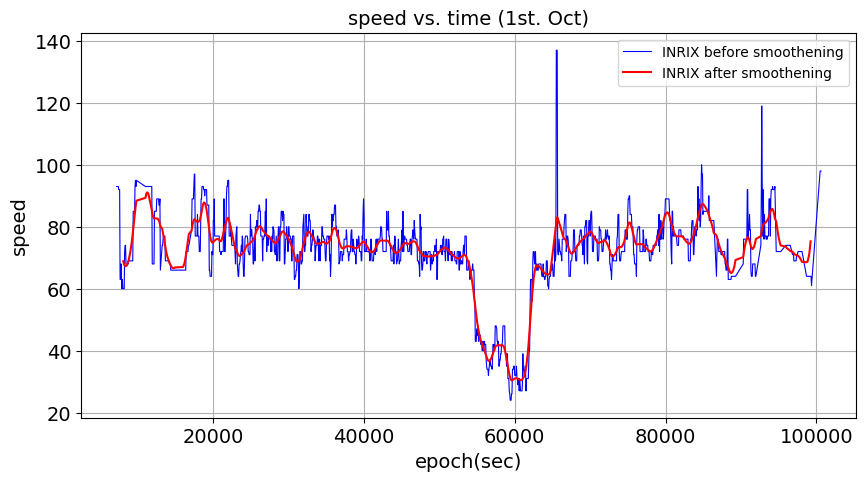

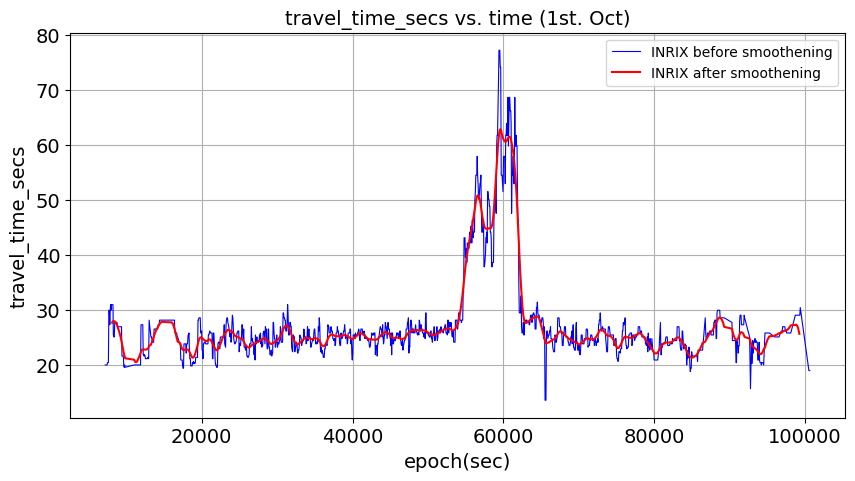

In [ ]:
# Plot original speed and smoothened speed for INRIX
n = 1
plt.figure(figsize=(10, 5))
plt.style.use('default')
plotAttr2DF(inrixNorth.iloc[0:1440*n], inrixNorth_smoothened.iloc[0:1420*n], 
            'Epoch_inrix', 'speed', 'INRIX before smoothening', 'INRIX after smoothening', '1st. Oct')

# Plot original travel time and smoothened one for INRIX
plt.figure(figsize=(10, 5))
plotAttr2DF(inrixNorth.iloc[0:1440*n], inrixNorth_smoothened.iloc[0:1420*n], 
            'Epoch_inrix', 'travel_time_secs', 'INRIX before smoothening', 'INRIX after smoothening', '1st. Oct')

### 2.4.3 Comparison between INRIX North and South after Smoothening

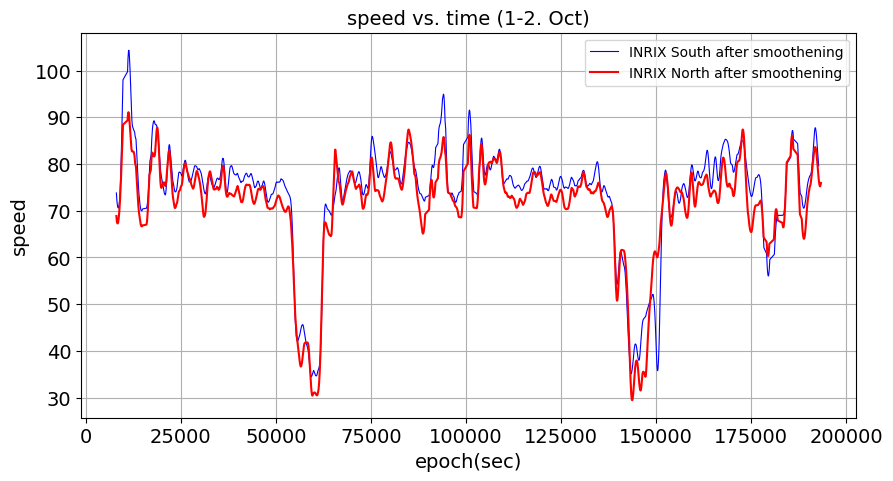

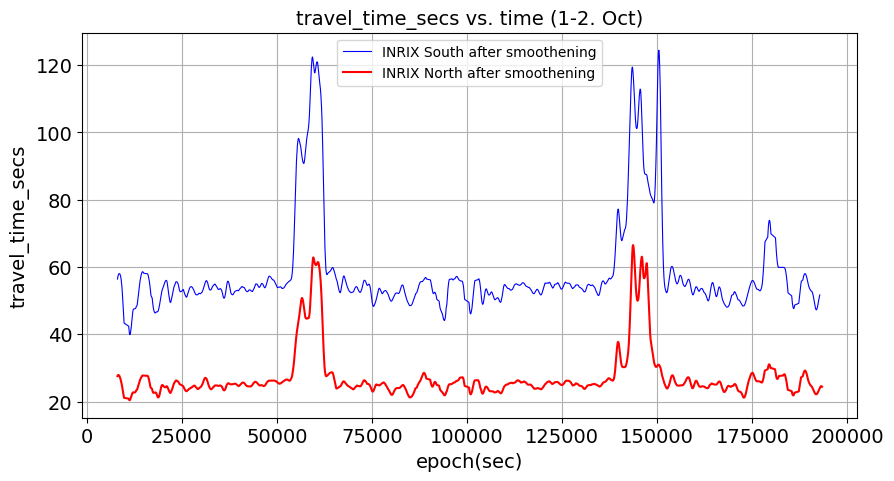

In [ ]:
# Plot smoothened south speed and smoothened north speed
n = 2
plt.figure(figsize=(10, 5))
plotAttr2DF(inrixSouth_smoothened.iloc[0:1420*n], inrixNorth_smoothened.iloc[0:1420*n], 
            'Epoch_inrix', 'speed', 'INRIX South after smoothening', 'INRIX North after smoothening', '1-2. Oct')
plt.figure(figsize=(10, 5))
plotAttr2DF(inrixSouth_smoothened.iloc[0:1420*n], inrixNorth_smoothened.iloc[0:1420*n], 
            'Epoch_inrix', 'travel_time_secs', 'INRIX South after smoothening', 'INRIX North after smoothening', '1-2. Oct')

# 3. Data-preparation for MCS data
1. Explore dataset and convert the speed unit (to km/hour)
2. convert the timestamp to 'datetime' data type for calculating the epoch
3. smoothen the flow and speed curve (moving average)

## 3.1 Explore the dataset and convert the 'speed' unit



In [ ]:
# Take a look at mcs dataset contents
mcs.head(5)

fk_id                 date    speed  speed_std_dev  flow    used_lanes
0   1159  2018-10-01 00:00:00  26.6028        7.18940   165     {1,1,1,1}
1   1159  2018-10-01 00:01:00  26.0600        4.10961   160  {1,1,1,NULL}
2   1159  2018-10-01 00:02:00  25.0705        9.05539   105     {1,1,1,1}
3   1159  2018-10-01 00:03:00  27.2009        4.54606   220  {1,1,1,NULL}
4   1159  2018-10-01 00:04:00  24.9600        7.93025   180  {1,1,1,NULL}

In [ ]:
# show the datatype information of mcs
mcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88560 entries, 0 to 88559
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fk_id          88560 non-null  int64  
 1   date           88560 non-null  object 
 2   speed          88560 non-null  float64
 3   speed_std_dev  88560 non-null  float64
 4   flow           88560 non-null  int64  
 5   used_lanes     88560 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 4.1+ MB


In [ ]:
# check whether data instances with all NULL used lane exist (data for all lanes are missing)
mcs_NULL = mcs[mcs.used_lanes.eq('{NULL,NULL,NULL,NULL}')]
print(mcs_NULL)

Empty DataFrame
Columns: [fk_id, date, speed, speed_std_dev, flow, used_lanes]
Index: []


In [ ]:
# convert the speed unit into km/hour
convertUnit = lambda x: x * 0.001 * 3600 # m/s -> km/hr
mcs['speed'] = mcs.speed.apply(convertUnit)
mcs['speed_std_dev'] = mcs.speed_std_dev.apply(convertUnit)

# drop unnecessary column "used_lanes"
mcs.drop(columns='used_lanes', inplace=True)

In [ ]:
mcs

fk_id                 date     speed  speed_std_dev  flow
0       1159  2018-10-01 00:00:00  95.77008      25.881840   165
1       1159  2018-10-01 00:01:00  93.81600      14.794596   160
2       1159  2018-10-01 00:02:00  90.25380      32.599404   105
3       1159  2018-10-01 00:03:00  97.92324      16.365816   220
4       1159  2018-10-01 00:04:00  89.85600      28.548900   180
...      ...                  ...       ...            ...   ...
88555   1162  2018-10-31 23:50:00  77.77296      34.320852   120
88556   1162  2018-10-31 23:51:00  85.05180      27.224064   285
88557   1162  2018-10-31 23:52:00  76.61088       9.000000   390
88558   1162  2018-10-31 23:53:00  74.30832      34.820676   180
88559   1162  2018-10-31 23:54:00  84.49704       1.800000   120

[88560 rows x 5 columns]

## 3.2 Convert the date datatype (from string) to Datetime

In [ ]:
# convert column "date" into Datetime objects, add back into original column "date"
convertToDateD = lambda row: datetime.strptime(row['date'], "%Y-%m-%d %H:%M:%S")
mcs['date'] = mcs.apply(convertToDateD, axis=1)

# check the datatype after convertion
print(mcs.info())
mcs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88560 entries, 0 to 88559
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   fk_id          88560 non-null  int64         
 1   date           88560 non-null  datetime64[ns]
 2   speed          88560 non-null  float64       
 3   speed_std_dev  88560 non-null  float64       
 4   flow           88560 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 3.4 MB
None


fk_id                date     speed  speed_std_dev  flow
0       1159 2018-10-01 00:00:00  95.77008      25.881840   165
1       1159 2018-10-01 00:01:00  93.81600      14.794596   160
2       1159 2018-10-01 00:02:00  90.25380      32.599404   105
3       1159 2018-10-01 00:03:00  97.92324      16.365816   220
4       1159 2018-10-01 00:04:00  89.85600      28.548900   180
...      ...                 ...       ...            ...   ...
88555   1162 2018-10-31 23:50:00  77.77296      34.320852   120
88556   1162 2018-10-31 23:51:00  85.05180      27.224064   285
88557   1162 2018-10-31 23:52:00  76.61088       9.000000   390
88558   1162 2018-10-31 23:53:00  74.30832      34.820676   180
88559   1162 2018-10-31 23:54:00  84.49704       1.800000   120

[88560 rows x 5 columns]

 ## 3.3 Split the dataset into South and North datasets

In [ ]:
# Split mcs into South and North datasets
mcsSouth = mcs[mcs.fk_id == 1159]
mcsNorth = mcs[mcs.fk_id == 1162]
mcsSouth.reset_index(drop=True, inplace=True)
mcsNorth.reset_index(drop=True, inplace=True)
print(len(mcsSouth))
print(len(mcsNorth))
print(len(mcs))

44285
44275
88560


In [ ]:
mcsSouth

fk_id                date     speed  speed_std_dev  flow
0       1159 2018-10-01 00:00:00  95.77008      25.881840   165
1       1159 2018-10-01 00:01:00  93.81600      14.794596   160
2       1159 2018-10-01 00:02:00  90.25380      32.599404   105
3       1159 2018-10-01 00:03:00  97.92324      16.365816   220
4       1159 2018-10-01 00:04:00  89.85600      28.548900   180
...      ...                 ...       ...            ...   ...
44280   1159 2018-10-31 23:50:00  92.69136      24.059916   260
44281   1159 2018-10-31 23:51:00  98.84844      19.449180   165
44282   1159 2018-10-31 23:52:00  88.89876      26.671320   320
44283   1159 2018-10-31 23:53:00  90.42264      19.571400   260
44284   1159 2018-10-31 23:54:00  88.91892      41.707440   180

[44285 rows x 5 columns]

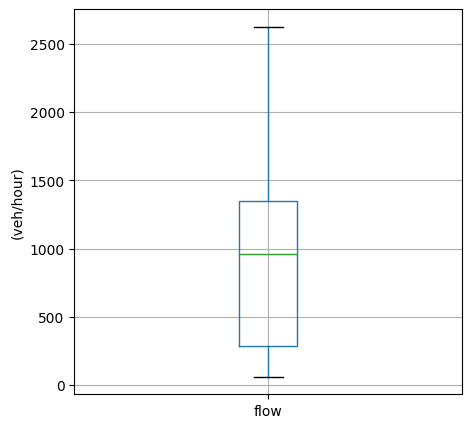

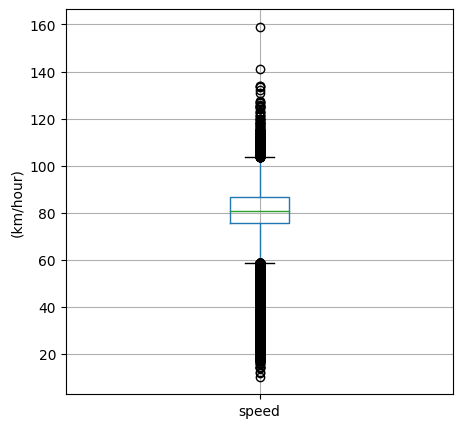

In [ ]:
# check the distribution of MCS speed and flow corresponding to 2 datasets respectively
# check if there is any outlier needs to be filtered
plt.style.use('default')
plt.figure(1, figsize=(5, 5))
plt.ylabel('(veh/hour)')
boxplot1 = mcsSouth.boxplot(column=['flow'])

plt.figure(2, figsize=(5, 5))
plt.ylabel('(km/hour)')
boxplot2 = mcsSouth.boxplot(column=['speed']) 

In [ ]:
mcsSouth[mcsSouth['speed'] > 150]

fk_id                date      speed  speed_std_dev  flow
33007   1159 2018-10-24 02:22:00  159.00012            0.0   120

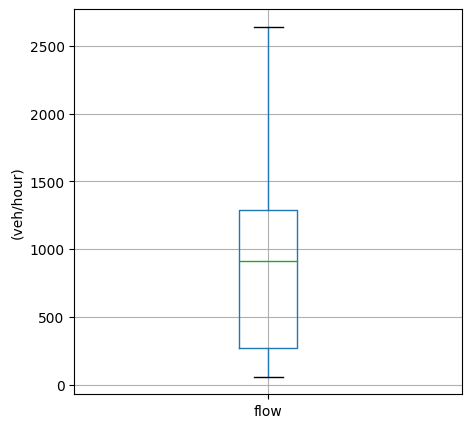

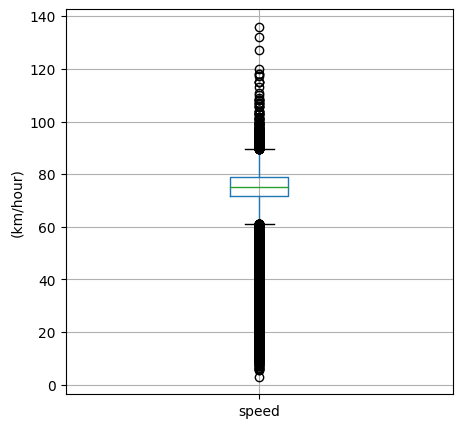

In [ ]:
# check the distribution of MCS speed and flow corresponding to 2 datasets respectively
# check if there is any outlier needs to be filtered
plt.style.use('default')
plt.figure(1, figsize=(5, 5))
plt.ylabel('(veh/hour)')
boxplot1 = mcsNorth.boxplot(column=['flow'])

plt.figure(2, figsize=(5, 5))
plt.ylabel('(km/hour)')
boxplot2 = mcsNorth.boxplot(column=['speed']) 

## 3.2 Calculate the epoch from datetime

In [ ]:
# calculate the Epoch according to the date
mcsSouth['Epoch_mcs'] = 0.0
mcsNorth['Epoch_mcs'] = 0.0

for i in range(len(mcsSouth)):
  mcsSouth.at[i, 'Epoch_mcs'] = calEpoch(mcsSouth, 'date', i)

for i in range(len(mcsNorth)):
  mcsNorth.at[i, 'Epoch_mcs'] = calEpoch(mcsNorth, 'date', i)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# check the computed epoch for mcs South
mcsSouth.iloc[idx(mcsSouth,1):idx(mcsSouth, 1) + 150]

fk_id                date     speed  speed_std_dev  flow  Epoch_mcs
0     1159 2018-10-01 00:00:00  95.77008      25.881840   165        0.0
1     1159 2018-10-01 00:01:00  93.81600      14.794596   160       60.0
2     1159 2018-10-01 00:02:00  90.25380      32.599404   105      120.0
3     1159 2018-10-01 00:03:00  97.92324      16.365816   220      180.0
4     1159 2018-10-01 00:04:00  89.85600      28.548900   180      240.0
..     ...                 ...       ...            ...   ...        ...
145   1159 2018-10-01 02:25:00  95.15772      10.322784   160     8700.0
146   1159 2018-10-01 02:26:00  95.32548      38.300400    90     8760.0
147   1159 2018-10-01 02:27:00  90.79020      46.692360   140     8820.0
148   1159 2018-10-01 02:28:00  95.64408       7.200000   180     8880.0
149   1159 2018-10-01 02:29:00  98.21556      32.400000   210     8940.0

[150 rows x 6 columns]

In [ ]:
# check the computed epoch for mcs North
mcsNorth.iloc[idx(mcsNorth,1):idx(mcsNorth, 1) + 150]

fk_id                date     speed  speed_std_dev  flow  Epoch_mcs
0     1162 2018-10-01 00:00:00  83.40300       7.776900   220        0.0
1     1162 2018-10-01 00:01:00  77.56164      24.651180   100       60.0
2     1162 2018-10-01 00:02:00  87.35040      52.936200   200      120.0
3     1162 2018-10-01 00:03:00  81.31392       5.091156   180      180.0
4     1162 2018-10-01 00:04:00  81.97956      36.119880   280      240.0
..     ...                 ...       ...            ...   ...        ...
145   1162 2018-10-01 02:27:00  78.16608       7.200000   150     8820.0
146   1162 2018-10-01 02:28:00  83.46924      41.291280   140     8880.0
147   1162 2018-10-01 02:29:00  82.84680      30.387492   135     8940.0
148   1162 2018-10-01 02:30:00  84.94380      31.153824   140     9000.0
149   1162 2018-10-01 02:31:00  79.95168       9.000000   150     9060.0

[150 rows x 6 columns]

## 3.3 Smoothen MCS Speed and Flow

In [ ]:
# smoothen the speed column by moving average (South)
rolling_speed = mcsSouth.speed.rolling(window=MOVING_AVERAGE_WINDOW, center=True, win_type='triang')
rolling_mean_speed = rolling_speed.mean()
rolling_mean_speed.iloc[10:20]

10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15    94.083548
16    94.064026
17    93.980823
18    93.825538
19    93.649874
Name: speed, dtype: float64

In [ ]:
# smoothen the flow column by centered moving average (South)
rolling_flow = mcsSouth.flow.rolling(window=MOVING_AVERAGE_WINDOW, center=True, win_type='triang')
rolling_mean_flow = rolling_flow.mean()
rolling_mean_flow.iloc[10:20]

10           NaN
11           NaN
12           NaN
13           NaN
14           NaN
15    176.933333
16    176.666667
17    176.311111
18    175.644444
19    174.666667
Name: flow, dtype: float64

In [ ]:
# add the smoothened columns back to the dataframe (South)
mcsSouth_smoothened = mcsSouth.copy()
mcsSouth_smoothened.speed = rolling_mean_speed
mcsSouth_smoothened.flow = rolling_mean_flow
mcsSouth_smoothened.iloc[10:20]

fk_id                date      speed  speed_std_dev        flow  Epoch_mcs
10   1159 2018-10-01 00:10:00        NaN      18.422532         NaN      600.0
11   1159 2018-10-01 00:11:00        NaN       9.000000         NaN      660.0
12   1159 2018-10-01 00:12:00        NaN      51.006960         NaN      720.0
13   1159 2018-10-01 00:13:00        NaN      49.947840         NaN      780.0
14   1159 2018-10-01 00:14:00        NaN      23.191380         NaN      840.0
15   1159 2018-10-01 00:15:00  94.083548      17.879580  176.933333      900.0
16   1159 2018-10-01 00:16:00  94.064026      22.449960  176.666667      960.0
17   1159 2018-10-01 00:17:00  93.980823      42.395760  176.311111     1020.0
18   1159 2018-10-01 00:18:00  93.825538      25.200000  175.644444     1080.0
19   1159 2018-10-01 00:19:00  93.649874      24.059916  174.666667     1140.0

In [ ]:
# remove the rows with NaN value due to the moving average process (South)
mcsSouth_smoothened = mcsSouth_smoothened.dropna()
mcsSouth_smoothened.reset_index(inplace=True, drop=True)
mcsSouth_smoothened

fk_id                date  ...        flow  Epoch_mcs
0       1159 2018-10-01 00:15:00  ...  176.933333      900.0
1       1159 2018-10-01 00:16:00  ...  176.666667      960.0
2       1159 2018-10-01 00:17:00  ...  176.311111     1020.0
3       1159 2018-10-01 00:18:00  ...  175.644444     1080.0
4       1159 2018-10-01 00:19:00  ...  174.666667     1140.0
...      ...                 ...  ...         ...        ...
44251   1159 2018-10-31 23:36:00  ...  259.444444  2676960.0
44252   1159 2018-10-31 23:37:00  ...  258.988889  2677020.0
44253   1159 2018-10-31 23:38:00  ...  259.233333  2677080.0
44254   1159 2018-10-31 23:39:00  ...  260.188889  2677140.0
44255   1159 2018-10-31 23:40:00  ...  260.822222  2677200.0

[44256 rows x 6 columns]

In [ ]:
# smoothen the speed column by moving average (North)
rolling_speed = mcsNorth.speed.rolling(window=MOVING_AVERAGE_WINDOW, center=True, win_type='triang')
rolling_mean_speed = rolling_speed.mean()
rolling_mean_speed.iloc[10:20]

10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15    83.457698
16    83.390379
17    83.311190
18    83.219380
19    83.114410
Name: speed, dtype: float64

In [ ]:
# smoothen the flow column by centered moving average (North)
rolling_flow = mcsNorth.flow.rolling(window=MOVING_AVERAGE_WINDOW, center=True, win_type='triang')
rolling_mean_flow = rolling_flow.mean()
rolling_mean_flow.iloc[10:20]

10           NaN
11           NaN
12           NaN
13           NaN
14           NaN
15    177.788889
16    177.388889
17    176.833333
18    175.911111
19    174.911111
Name: flow, dtype: float64

In [ ]:
# add the smoothened columns back to the dataframe (North)
mcsNorth_smoothened = mcsNorth.copy()
mcsNorth_smoothened.speed = rolling_mean_speed
mcsNorth_smoothened.flow = rolling_mean_flow
mcsNorth_smoothened.iloc[10:20]

fk_id                date      speed  speed_std_dev        flow  Epoch_mcs
10   1162 2018-10-01 00:10:00        NaN       5.400000         NaN      600.0
11   1162 2018-10-01 00:11:00        NaN      65.117880         NaN      660.0
12   1162 2018-10-01 00:12:00        NaN      26.345412         NaN      720.0
13   1162 2018-10-01 00:13:00        NaN      33.941124         NaN      780.0
14   1162 2018-10-01 00:14:00        NaN      32.933124         NaN      840.0
15   1162 2018-10-01 00:15:00  83.457698      24.999192  177.788889      900.0
16   1162 2018-10-01 00:16:00  83.390379      42.697080  177.388889      960.0
17   1162 2018-10-01 00:17:00  83.311190      40.835160  176.833333     1020.0
18   1162 2018-10-01 00:18:00  83.219380      25.624980  175.911111     1080.0
19   1162 2018-10-01 00:19:00  83.114410      30.600000  174.911111     1140.0

In [ ]:
# remove the rows with NaN value due to the moving average process (North)
mcsNorth_smoothened = mcsNorth_smoothened.dropna()
mcsNorth_smoothened.reset_index(inplace=True, drop=True)
mcsNorth_smoothened

fk_id                date  ...        flow  Epoch_mcs
0       1162 2018-10-01 00:15:00  ...  177.788889      900.0
1       1162 2018-10-01 00:16:00  ...  177.388889      960.0
2       1162 2018-10-01 00:17:00  ...  176.833333     1020.0
3       1162 2018-10-01 00:18:00  ...  175.911111     1080.0
4       1162 2018-10-01 00:19:00  ...  174.911111     1140.0
...      ...                 ...  ...         ...        ...
44241   1162 2018-10-31 23:36:00  ...  246.988889  2676960.0
44242   1162 2018-10-31 23:37:00  ...  246.888889  2677020.0
44243   1162 2018-10-31 23:38:00  ...  247.422222  2677080.0
44244   1162 2018-10-31 23:39:00  ...  248.122222  2677140.0
44245   1162 2018-10-31 23:40:00  ...  248.800000  2677200.0

[44246 rows x 6 columns]

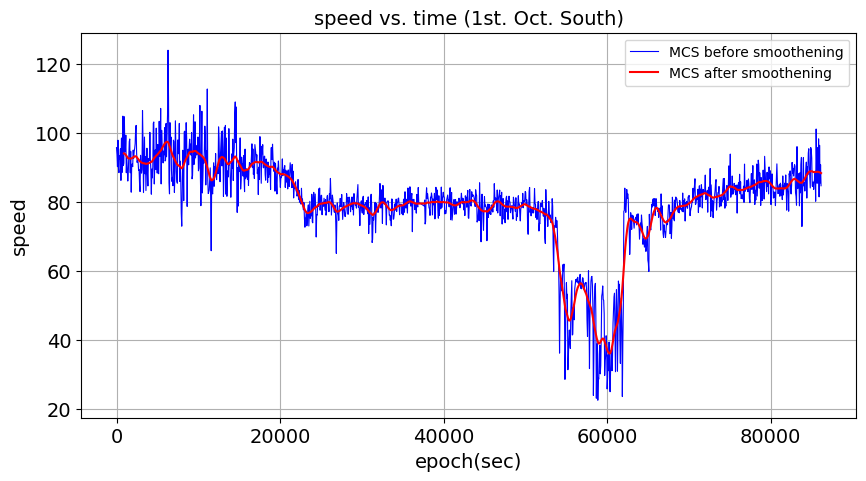

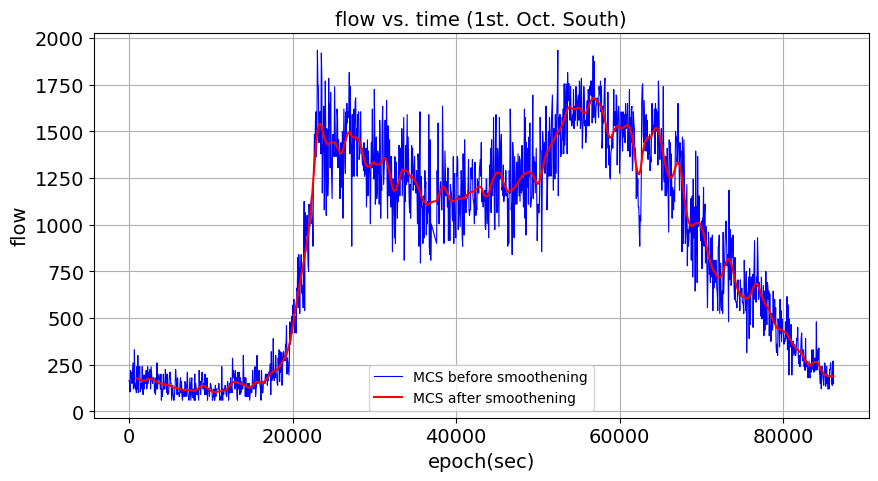

In [ ]:
# Plot original speed and smoothened speed for MCS South
plt.figure(figsize=(10, 5))
plotAttr2DF(mcsSouth.iloc[:idx(mcsSouth, 2)], mcsSouth_smoothened.iloc[:idx(mcsSouth_smoothened, 2)], 
            'Epoch_mcs', 'speed', 'MCS before smoothening', 'MCS after smoothening', '1st. Oct. South')

# Plot original flow and smoothened flow for MCS
plt.figure(figsize=(10, 5))
plotAttr2DF(mcsSouth.iloc[:idx(mcsSouth, 2)], mcsSouth_smoothened.iloc[:idx(mcsSouth_smoothened, 2)], 
            'Epoch_mcs', 'flow', 'MCS before smoothening', 'MCS after smoothening', '1st. Oct. South')

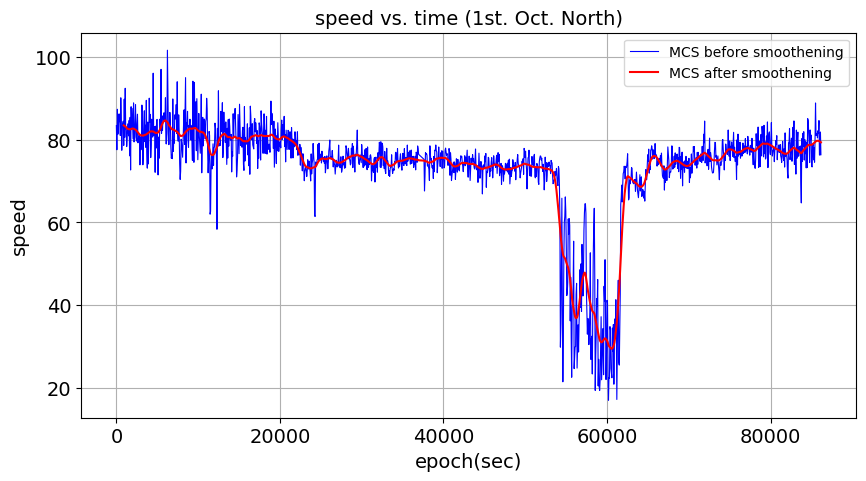

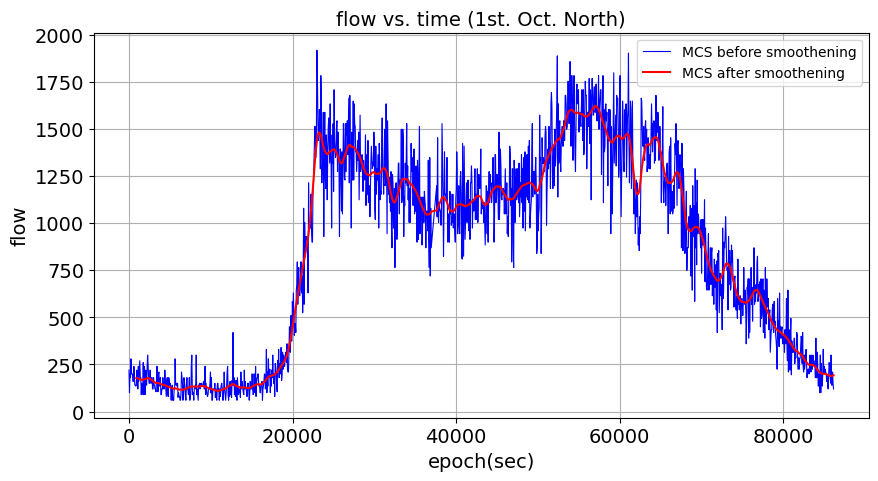

In [ ]:
# Plot original speed and smoothened speed for MCS North
plt.figure(figsize=(10, 5))
plotAttr2DF(mcsNorth.iloc[:idx(mcsNorth, 2)], mcsNorth_smoothened.iloc[:idx(mcsNorth_smoothened, 2)], 
            'Epoch_mcs', 'speed', 'MCS before smoothening', 'MCS after smoothening', '1st. Oct. North')

# Plot original flow and smoothened flow for MCS
plt.figure(figsize=(10, 5))
plotAttr2DF(mcsNorth.iloc[:idx(mcsNorth, 2)], mcsNorth_smoothened.iloc[:idx(mcsNorth_smoothened, 2)], 
            'Epoch_mcs', 'flow', 'MCS before smoothening', 'MCS after smoothening', '1st. Oct. North')

# 4. Dataset Preparation for South Segment

1. shift time-delay between inrix and mcs measurements
2. Combine inrix and mcs datasets into one final dataset according to instances'epoch
3. Dataset exploration with a focus on correlation between inrix and mcs
4. Feature Engineering: temporal feature
5. Feature Engineering: spatial feature


## 4.1 Shift the time-lag of INRIX South

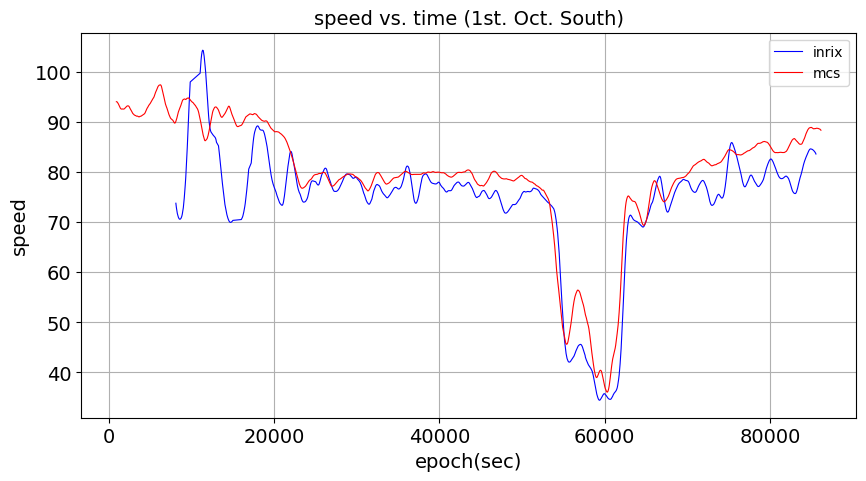

In [ ]:
# check the alignment of mcs_speed and inrix_speed
plt.figure(figsize=(10, 5))
plotAttr2DF2X(inrixSouth_smoothened.iloc[:1250], 
              mcsSouth_smoothened.iloc[idx(mcsSouth_smoothened, 1):idx(mcsSouth_smoothened, 2)], 
            'Epoch_inrix', 'Epoch_mcs', 'speed', 'inrix', 'mcs', '1st. Oct. South')

In [ ]:
# Shift Epoch_inrix of INRIX south by deducting 6 mins (360) in order to eliminate the time-delay
print(inrixSouth_smoothened.head(5))
inrixSouth_smoothened['Epoch_inrix'] = inrixSouth_smoothened.Epoch_inrix - (6 * 60)
print(inrixSouth_smoothened.head(5))

    segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0  1071883675 2018-10-01 00:15:11  ... 2018-10-01 02:15:11       8099.0
1  1071883675 2018-10-01 00:16:09  ... 2018-10-01 02:16:09       8157.0
2  1071883675 2018-10-01 00:17:14  ... 2018-10-01 02:17:14       8222.0
3  1071883675 2018-10-01 00:18:08  ... 2018-10-01 02:18:08       8276.0
4  1071883675 2018-10-01 00:19:09  ... 2018-10-01 02:19:09       8337.0

[5 rows x 11 columns]
    segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0  1071883675 2018-10-01 00:15:11  ... 2018-10-01 02:15:11       7739.0
1  1071883675 2018-10-01 00:16:09  ... 2018-10-01 02:16:09       7797.0
2  1071883675 2018-10-01 00:17:14  ... 2018-10-01 02:17:14       7862.0
3  1071883675 2018-10-01 00:18:08  ... 2018-10-01 02:18:08       7916.0
4  1071883675 2018-10-01 00:19:09  ... 2018-10-01 02:19:09       7977.0

[5 rows x 11 columns]


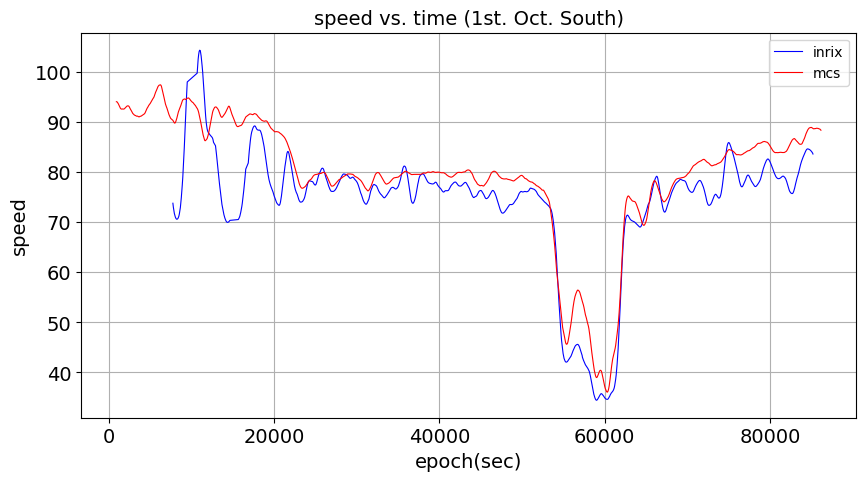

In [ ]:
# check the alignment of mcs_speed and inrix_speed after shifting
plt.figure(figsize=(10, 5))
plotAttr2DF2X(inrixSouth_smoothened.iloc[:1250], 
              mcsSouth_smoothened.iloc[idx(mcsSouth_smoothened, 1):idx(mcsSouth_smoothened, 2)], 
            'Epoch_inrix', 'Epoch_mcs', 'speed', 'inrix', 'mcs', '1st. Oct. South')

## 4.2 Match the MCS and INRIX rows according to their corresponding epoch (South)




In [ ]:
# function to match inrix timestamps with mcs, and merge them into a single dataset
# Input: mcs dataframe, inrix dataframe 
# output: return a new dataframe combines both dataframes after the time-step matching
def matchTimeStep (mcsDf, inrixDf):
  DELTATIME = 26.0
  mcsMatched = pd.DataFrame(columns = mcsDf.columns)
  inrixMatched = pd.DataFrame(columns = inrixDf.columns)
  print(mcsMatched)
  print(inrixMatched)
  i = 0
  j = 0
  while ((j < len(inrixDf)) & (i < len(mcsDf))):
    mcsEpoch = mcsDf.iloc[i]['Epoch_mcs']
    inrixEpoch = inrixDf.iloc[j]['Epoch_inrix']
    # if the difference in epoch between mcs and inrix is smaller than 25 sec,
    # they are in the same time step (within same min interval)
    if (abs(inrixEpoch - mcsEpoch) < DELTATIME ):
      mcsMatched = mcsMatched.append(mcsDf.iloc[i], ignore_index = True)
      inrixMatched = inrixMatched.append(inrixDf.iloc[j], ignore_index = True)
      i += 1
      j += 1
      if(i % 1000.0 == 0): print(mcsMatched)
    elif ((inrixEpoch - mcsEpoch) < 0.0):
      j += 1
      print('missing mcs', j)
    elif ((inrixEpoch -mcsEpoch) > 0.0):
      i +=1
      print('missing inrix', i)
  
  print('length of mcsMatched: ', len(mcsMatched))
  print('length of inrixMatched: ', len(inrixMatched))

  print(inrixMatched.columns)
  inrixMatched.rename(columns = {'speed': 'speed_inrix'}, inplace = True)
  print(inrixMatched.columns)
  
  combinedDf = pd.concat([mcsMatched, inrixMatched], axis=1)
  print('length of combined df:', len(combinedDf))
  
  return combinedDf
  

In [ ]:
# match the shifted inrix with mcs dataframe and combined them
# Notice: a lot of log will be printed out for monitoring and debugging
combinedSouth = matchTimeStep(mcsSouth_smoothened, inrixSouth_smoothened)

Empty DataFrame
Columns: [fk_id, date, speed, speed_std_dev, flow, Epoch_mcs]
Index: []
Empty DataFrame
Columns: [segmentid, timestamputc, speed, average, reference, score, cvalue, speedbucket, travel_time_secs, date_inrix, Epoch_inrix]
Index: []
missing inrix 1
missing inrix 2
missing inrix 3
missing inrix 4
missing inrix 5
missing inrix 6
missing inrix 7
missing inrix 8
missing inrix 9
missing inrix 10
missing inrix 11
missing inrix 12
missing inrix 13
missing inrix 14
missing inrix 15
missing inrix 16
missing inrix 17
missing inrix 18
missing inrix 19
missing inrix 20
missing inrix 21
missing inrix 22
missing inrix 23
missing inrix 24
missing inrix 25
missing inrix 26
missing inrix 27
missing inrix 28
missing inrix 29
missing inrix 30
missing inrix 31
missing inrix 32
missing inrix 33
missing inrix 34
missing inrix 35
missing inrix 36
missing inrix 37
missing inrix 38
missing inrix 39
missing inrix 40
missing inrix 41
missing inrix 42
missing inrix 43
missing inrix 44
missing inrix 

In [ ]:
combinedSouth[['date', 'date_inrix', 'Epoch_mcs', 'Epoch_inrix', 'speed', 'speed_inrix', 'flow']]

date          date_inrix  ...  reference        flow
0     2018-10-01 02:09:00 2018-10-01 02:15:11  ...         68  111.766667
1     2018-10-01 02:10:00 2018-10-01 02:16:09  ...         68  110.900000
2     2018-10-01 02:11:00 2018-10-01 02:17:14  ...         68  110.655556
3     2018-10-01 02:12:00 2018-10-01 02:18:08  ...         68  110.611111
4     2018-10-01 02:13:00 2018-10-01 02:19:09  ...         68  110.633333
...                   ...                 ...  ...        ...         ...
42069 2018-10-31 23:36:00 2018-10-31 23:42:09  ...         68  259.444444
42070 2018-10-31 23:37:00 2018-10-31 23:43:08  ...         68  258.988889
42071 2018-10-31 23:38:00 2018-10-31 23:44:08  ...         68  259.233333
42072 2018-10-31 23:39:00 2018-10-31 23:45:11  ...         68  260.188889
42073 2018-10-31 23:40:00 2018-10-31 23:46:08  ...         68  260.822222

[42074 rows x 8 columns]

In [ ]:
# Check the columns' datatype after combining the datasets 
print(combinedSouth.info())
print(mcsSouth_smoothened.info())
print(inrixSouth_smoothened.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42074 entries, 0 to 42073
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fk_id             42074 non-null  object        
 1   date              42074 non-null  datetime64[ns]
 2   speed             42074 non-null  float64       
 3   speed_std_dev     42074 non-null  float64       
 4   flow              42074 non-null  float64       
 5   Epoch_mcs         42074 non-null  float64       
 6   segmentid         42074 non-null  object        
 7   timestamputc      42074 non-null  datetime64[ns]
 8   speed_inrix       42074 non-null  float64       
 9   average           42074 non-null  object        
 10  reference         42074 non-null  object        
 11  score             42074 non-null  object        
 12  cvalue            42074 non-null  object        
 13  speedbucket       42074 non-null  object        
 14  travel_time_secs  4207

In [ ]:
# convert the datatypes to the original types
combinedSouth = combinedSouth.astype(
    {'fk_id':'int64', 'segmentid':'int64', 'average': 'int64', 'reference': 'int64'
    , 'score': 'int64', 'cvalue': 'int64', 'speedbucket': 'int64'})
combinedSouth.info()
combinedSouth.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42074 entries, 0 to 42073
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fk_id             42074 non-null  int64         
 1   date              42074 non-null  datetime64[ns]
 2   speed             42074 non-null  float64       
 3   speed_std_dev     42074 non-null  float64       
 4   flow              42074 non-null  float64       
 5   Epoch_mcs         42074 non-null  float64       
 6   segmentid         42074 non-null  int64         
 7   timestamputc      42074 non-null  datetime64[ns]
 8   speed_inrix       42074 non-null  float64       
 9   average           42074 non-null  int64         
 10  reference         42074 non-null  int64         
 11  score             42074 non-null  int64         
 12  cvalue            42074 non-null  int64         
 13  speedbucket       42074 non-null  int64         
 14  travel_time_secs  4207

fk_id                date  ...          date_inrix  Epoch_inrix
0   1159 2018-10-01 02:09:00  ... 2018-10-01 02:15:11       7739.0
1   1159 2018-10-01 02:10:00  ... 2018-10-01 02:16:09       7797.0
2   1159 2018-10-01 02:11:00  ... 2018-10-01 02:17:14       7862.0
3   1159 2018-10-01 02:12:00  ... 2018-10-01 02:18:08       7916.0
4   1159 2018-10-01 02:13:00  ... 2018-10-01 02:19:09       7977.0

[5 rows x 17 columns]

In [ ]:
# save the dataset as .csv and pandas .pkl file
combinedSouth.to_pickle('OutData2/InrixMcsSouth.pkl')
combinedSouth.to_csv('OutData2/InrixMcsSouth.csv')

## 4.3 Shift the time-lag of INRIX North

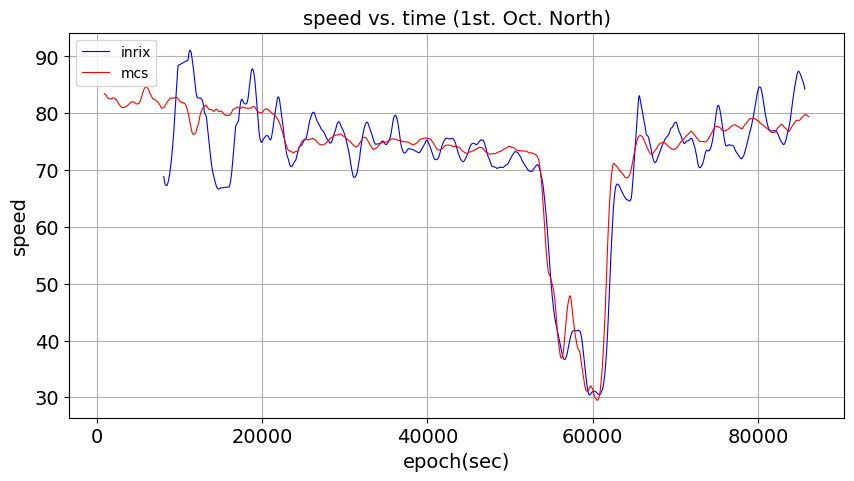

In [ ]:
# check the alignment of mcs_speed and inrix_speed
plt.figure(figsize=(10, 5))
plotAttr2DF2X(inrixNorth_smoothened.iloc[:1250], 
              mcsNorth_smoothened.iloc[idx(mcsNorth_smoothened, 1):idx(mcsNorth_smoothened, 2)], 
            'Epoch_inrix', 'Epoch_mcs', 'speed', 'inrix', 'mcs', '1st. Oct. North')

In [ ]:
# Shift Epoch_inrix of INRIX by deducting 6 mins (360) in order to eliminate the time-delay
print(inrixNorth_smoothened.head(5))
inrixNorth_smoothened['Epoch_inrix'] = inrixNorth_smoothened.Epoch_inrix - (6 * 60)
print(inrixNorth_smoothened.head(5))

   segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0  225285973 2018-10-01 00:15:14  ... 2018-10-01 02:15:14       8100.0
1  225285973 2018-10-01 00:16:11  ... 2018-10-01 02:16:11       8157.0
2  225285973 2018-10-01 00:17:16  ... 2018-10-01 02:17:16       8222.0
3  225285973 2018-10-01 00:18:10  ... 2018-10-01 02:18:10       8276.0
4  225285973 2018-10-01 00:19:11  ... 2018-10-01 02:19:11       8337.0

[5 rows x 11 columns]
   segmentid        timestamputc  ...          date_inrix  Epoch_inrix
0  225285973 2018-10-01 00:15:14  ... 2018-10-01 02:15:14       7740.0
1  225285973 2018-10-01 00:16:11  ... 2018-10-01 02:16:11       7797.0
2  225285973 2018-10-01 00:17:16  ... 2018-10-01 02:17:16       7862.0
3  225285973 2018-10-01 00:18:10  ... 2018-10-01 02:18:10       7916.0
4  225285973 2018-10-01 00:19:11  ... 2018-10-01 02:19:11       7977.0

[5 rows x 11 columns]


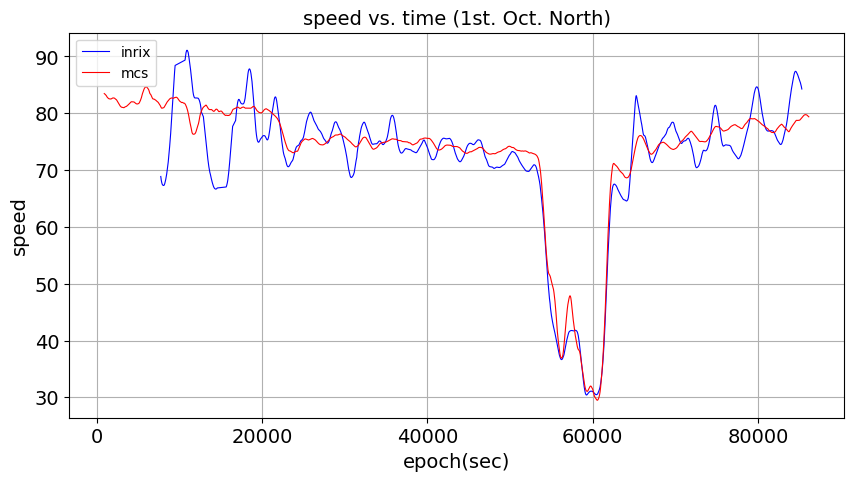

In [ ]:
# check the alignment of mcs_speed and inrix_speed after shifting
plt.figure(figsize=(10, 5))
plotAttr2DF2X(inrixNorth_smoothened.iloc[:1250], 
              mcsNorth_smoothened.iloc[idx(mcsNorth_smoothened, 1):idx(mcsNorth_smoothened, 2)], 
            'Epoch_inrix', 'Epoch_mcs', 'speed', 'inrix', 'mcs', '1st. Oct. North')

## 4.4 Match the MCS and INRIX rows according to their corresponding epoch (North)




In [ ]:
# match the shifted inrix with mcs dataframe and combined them
# Notice: a lot of log will be printed out for monitoring and debugging
combinedNorth = matchTimeStep(mcsNorth_smoothened, inrixNorth_smoothened)

Empty DataFrame
Columns: [fk_id, date, speed, speed_std_dev, flow, Epoch_mcs]
Index: []
Empty DataFrame
Columns: [segmentid, timestamputc, speed, average, reference, score, cvalue, speedbucket, travel_time_secs, date_inrix, Epoch_inrix]
Index: []
missing inrix 1
missing inrix 2
missing inrix 3
missing inrix 4
missing inrix 5
missing inrix 6
missing inrix 7
missing inrix 8
missing inrix 9
missing inrix 10
missing inrix 11
missing inrix 12
missing inrix 13
missing inrix 14
missing inrix 15
missing inrix 16
missing inrix 17
missing inrix 18
missing inrix 19
missing inrix 20
missing inrix 21
missing inrix 22
missing inrix 23
missing inrix 24
missing inrix 25
missing inrix 26
missing inrix 27
missing inrix 28
missing inrix 29
missing inrix 30
missing inrix 31
missing inrix 32
missing inrix 33
missing inrix 34
missing inrix 35
missing inrix 36
missing inrix 37
missing inrix 38
missing inrix 39
missing inrix 40
missing inrix 41
missing inrix 42
missing inrix 43
missing inrix 44
missing inrix 

In [ ]:
combinedNorth[['date', 'date_inrix', 'Epoch_mcs', 'Epoch_inrix', 'speed', 'speed_inrix', 'flow']]

date          date_inrix  ...  speed_inrix        flow
0     2018-10-01 02:09:00 2018-10-01 02:15:14  ...    68.871111  133.800000
1     2018-10-01 02:10:00 2018-10-01 02:16:11  ...    68.226667  133.133333
2     2018-10-01 02:11:00 2018-10-01 02:17:16  ...    67.768889  132.555556
3     2018-10-01 02:12:00 2018-10-01 02:18:10  ...    67.497778  132.088889
4     2018-10-01 02:13:00 2018-10-01 02:19:11  ...    67.360000  132.000000
...                   ...                 ...  ...          ...         ...
41952 2018-10-31 23:36:00 2018-10-31 23:42:10  ...    78.868889  246.988889
41953 2018-10-31 23:37:00 2018-10-31 23:43:09  ...    79.524444  246.888889
41954 2018-10-31 23:38:00 2018-10-31 23:44:09  ...    80.193333  247.422222
41955 2018-10-31 23:39:00 2018-10-31 23:45:15  ...    80.860000  248.122222
41956 2018-10-31 23:40:00 2018-10-31 23:46:12  ...    81.571111  248.800000

[41957 rows x 7 columns]

In [ ]:
# Check the columns' datatype after combining the datasets 
print(combinedNorth.info())
print(mcsNorth_smoothened.info())
print(inrixNorth_smoothened.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41957 entries, 0 to 41956
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fk_id             41957 non-null  object        
 1   date              41957 non-null  datetime64[ns]
 2   speed             41957 non-null  float64       
 3   speed_std_dev     41957 non-null  float64       
 4   flow              41957 non-null  float64       
 5   Epoch_mcs         41957 non-null  float64       
 6   segmentid         41957 non-null  object        
 7   timestamputc      41957 non-null  datetime64[ns]
 8   speed_inrix       41957 non-null  float64       
 9   average           41957 non-null  object        
 10  reference         41957 non-null  object        
 11  score             41957 non-null  object        
 12  cvalue            41957 non-null  object        
 13  speedbucket       41957 non-null  object        
 14  travel_time_secs  4195

In [ ]:
# convert the datatypes to the original types
combinedNorth = combinedNorth.astype(
    {'fk_id':'int64', 'segmentid':'int64', 'average': 'int64', 'reference': 'int64'
    , 'score': 'int64', 'cvalue': 'int64', 'speedbucket': 'int64'})
combinedNorth.info()
combinedNorth.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41957 entries, 0 to 41956
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fk_id             41957 non-null  int64         
 1   date              41957 non-null  datetime64[ns]
 2   speed             41957 non-null  float64       
 3   speed_std_dev     41957 non-null  float64       
 4   flow              41957 non-null  float64       
 5   Epoch_mcs         41957 non-null  float64       
 6   segmentid         41957 non-null  int64         
 7   timestamputc      41957 non-null  datetime64[ns]
 8   speed_inrix       41957 non-null  float64       
 9   average           41957 non-null  int64         
 10  reference         41957 non-null  int64         
 11  score             41957 non-null  int64         
 12  cvalue            41957 non-null  int64         
 13  speedbucket       41957 non-null  int64         
 14  travel_time_secs  4195

fk_id                date  ...          date_inrix  Epoch_inrix
0   1162 2018-10-01 02:09:00  ... 2018-10-01 02:15:14       7740.0
1   1162 2018-10-01 02:10:00  ... 2018-10-01 02:16:11       7797.0
2   1162 2018-10-01 02:11:00  ... 2018-10-01 02:17:16       7862.0
3   1162 2018-10-01 02:12:00  ... 2018-10-01 02:18:10       7916.0
4   1162 2018-10-01 02:13:00  ... 2018-10-01 02:19:11       7977.0

[5 rows x 17 columns]

In [ ]:
# save the dataset as .csv and pandas .pkl file
combinedNorth.to_pickle('OutData2/InrixMcsNorth.pkl')
combinedNorth.to_csv('OutData2/InrixMcsNorth.csv')

## 4.5 Dataset Exploration 

* No additional processing of the datasets, only exploration.<br>
  


In [ ]:
# load the combined/pre-processed dataframe
# start from this cell if data frame has been processed before
combinedNorth = pd.read_pickle('OutData2/InrixMcsNorth.pkl')
combinedSouth = pd.read_pickle('OutData2/InrixMcsSouth.pkl')

In [ ]:
combinedSouth.head(2)

fk_id                date      speed  ...  south  north   density
0   1159 2018-10-01 02:09:00  90.355237  ...    1.0    0.0  1.514317
1   1159 2018-10-01 02:10:00  90.183686  ...    1.0    0.0  1.519409

[2 rows x 46 columns]

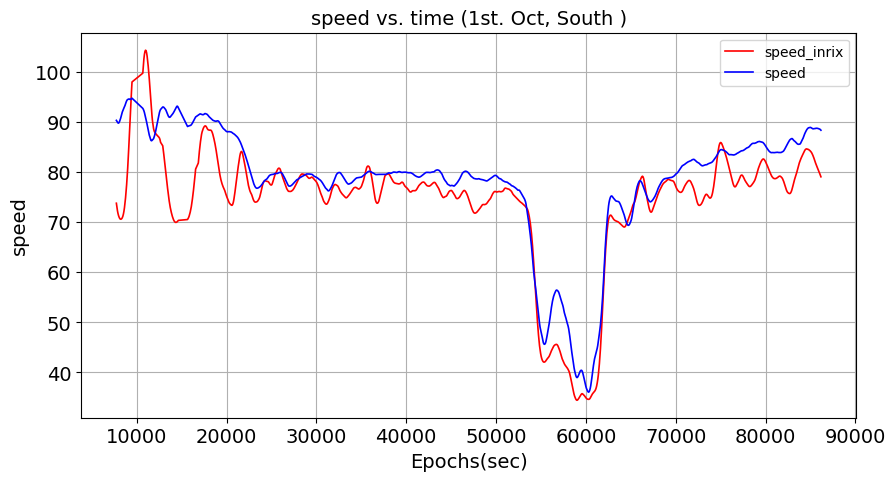

In [ ]:
plt.figure(figsize=(10, 5))
plt.grid()
plot2Attr('1st. Oct, South', combinedSouth.iloc[idx(combinedSouth, 1): idx(combinedSouth, 2)]
          , 'speed_inrix', 'speed', 'speed')

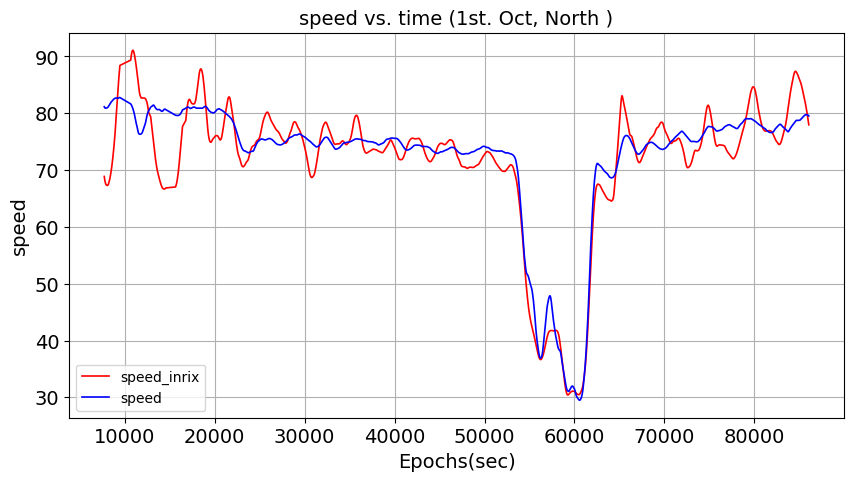

In [ ]:
plt.figure(figsize=(10, 5))
plt.grid()
plot2Attr('1st. Oct, North', combinedNorth.iloc[idx(combinedNorth, 1): idx(combinedNorth, 2)]
          , 'speed_inrix', 'speed', 'speed')

# plt.figure(figsize=(20, 10))
# combinedSouthT2_shifted = combinedSouth_shifted.iloc[idx(combinedSouth_shifted, 10) :idx(combinedSouth_shifted, 15)]
# plt.grid()
# plot2Attr('25th to 27th', combinedSouthT2_shifted, 'speed_inrix', 'speed_inrix_up', 'speed')


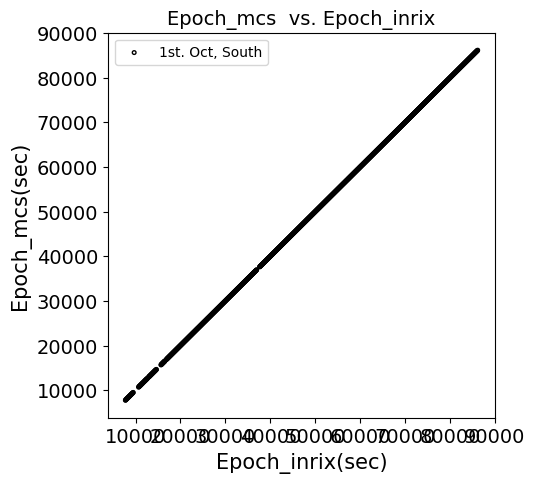

In [ ]:
# draw plot of epoch_mcs vs. epoch_inrix
plt.figure(figsize = (5, 5))
combinedSouth1st = combinedSouth.iloc[:idx(combinedSouth, 2)]
plotScatter(combinedSouth1st, combinedSouth1st, 'Epoch_inrix', 'Epoch_mcs', '1st. Oct, South', '(sec)', '(sec)', 'best')

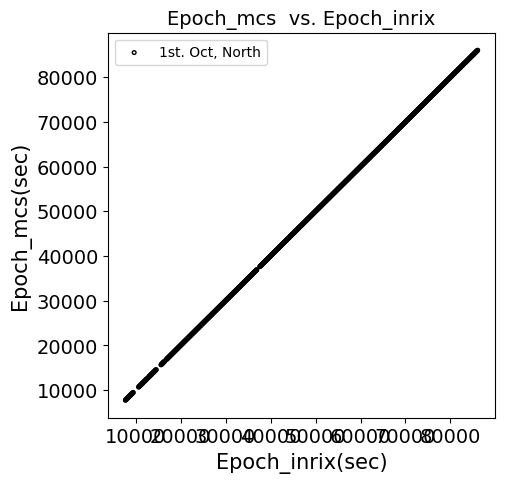

In [ ]:
# draw plot of epoch_mcs vs. epoch_inrix
plt.figure(figsize = (5, 5))
combinedNorth1st = combinedNorth.iloc[:idx(combinedNorth, 2)]
plotScatter(combinedNorth1st, combinedNorth1st, 'Epoch_inrix', 'Epoch_mcs', '1st. Oct, North', '(sec)', '(sec)', 'best')

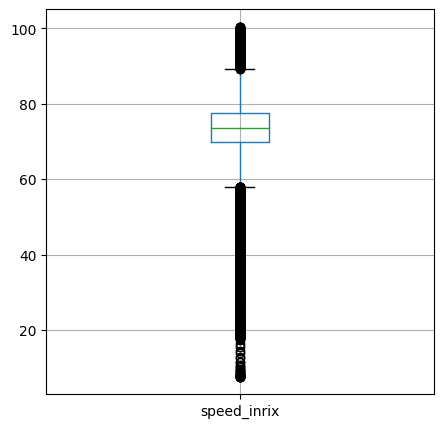

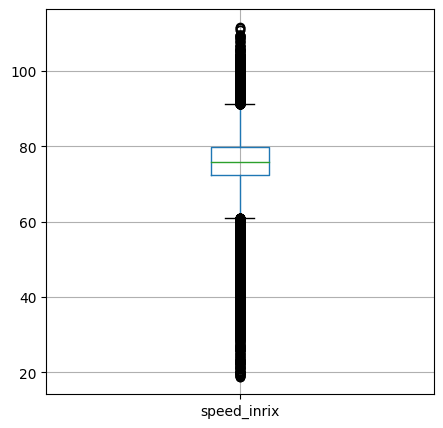

In [ ]:
# check distribution of speed_inrix
plt.figure(1, figsize=(5,5))
boxplot = combinedNorth.boxplot(column=['speed_inrix'])

plt.figure(2, figsize=(5,5))
boxplot = combinedSouth.boxplot(column=['speed_inrix'])


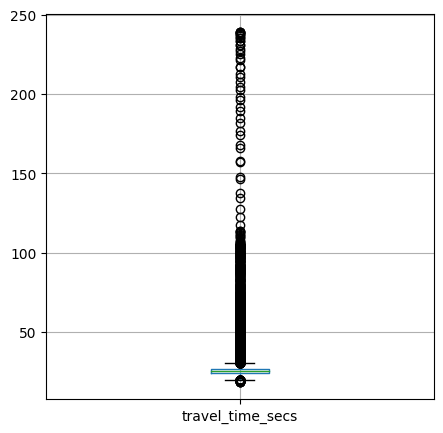

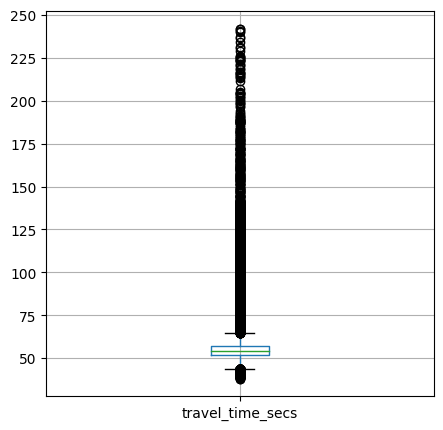

In [ ]:
# check distribution travel_time_secs
plt.figure(1, figsize=(5,5))
boxplot = combinedNorth.boxplot(column=['travel_time_secs'])

plt.figure(2, figsize=(5,5))
boxplot = combinedSouth.boxplot(column=['travel_time_secs'])


                  speed_inrix  travel_time_secs
speed_inrix          1.000000         -0.917789
travel_time_secs    -0.917789          1.000000


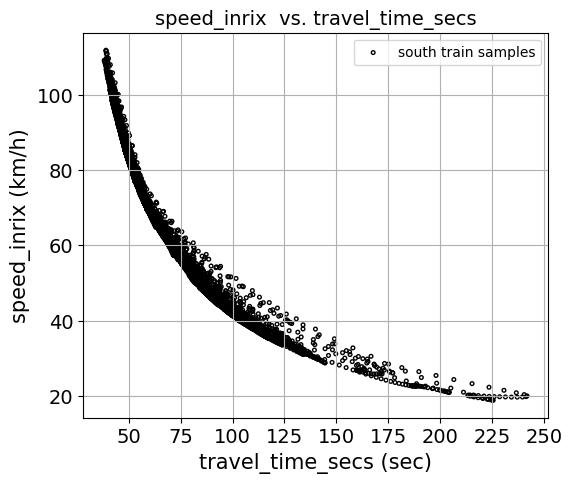

In [110]:
# draw plot of speed_inrix vs travel time
speedTravelTimeCorr = combinedSouth.iloc[:idx(combinedSouth, 22)][['speed_inrix', 'travel_time_secs']].copy() 
print(speedTravelTimeCorr.corr())

plt.figure(figsize=(6,5))
plt.grid()
plotScatter(speedTravelTimeCorr, speedTravelTimeCorr, 'travel_time_secs', 'speed_inrix', 'south train samples', ' (sec)', ' (km/h)', 'best')

                  speed_inrix  travel_time_secs
speed_inrix          1.000000         -0.811531
travel_time_secs    -0.811531          1.000000


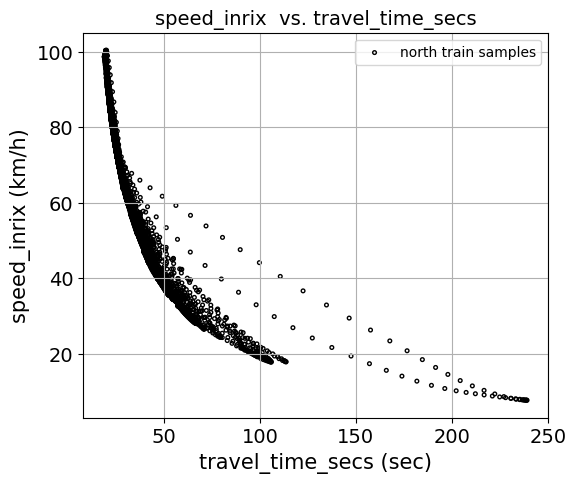

In [111]:
# draw plot of speed_inrix vs travel time
speedTravelTimeCorrNorth = combinedNorth.iloc[:idx(combinedNorth, 22)][['speed_inrix', 'travel_time_secs']].copy() 
print(speedTravelTimeCorrNorth.corr())

plt.figure(figsize=(6,5))
plt.grid()
plotScatter(speedTravelTimeCorrNorth, speedTravelTimeCorrNorth, 'travel_time_secs', 'speed_inrix', 'north train samples', ' (sec)', ' (km/h)', 'best')

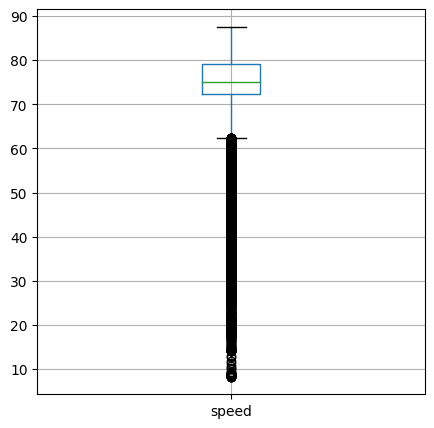

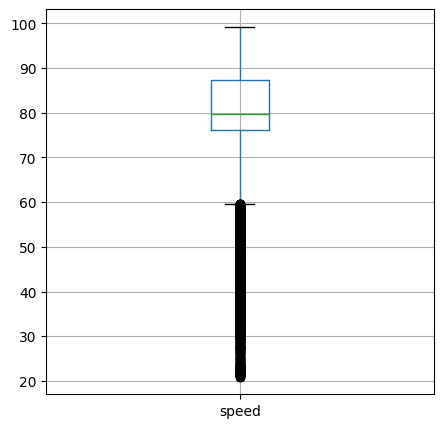

In [112]:
# check distribution of mcs speed_mcs
plt.figure(1, figsize=(5,5))
boxplot = combinedNorth.boxplot(column=['speed'])

plt.figure(2, figsize=(5,5))
boxplot = combinedSouth.boxplot(column=['speed'])


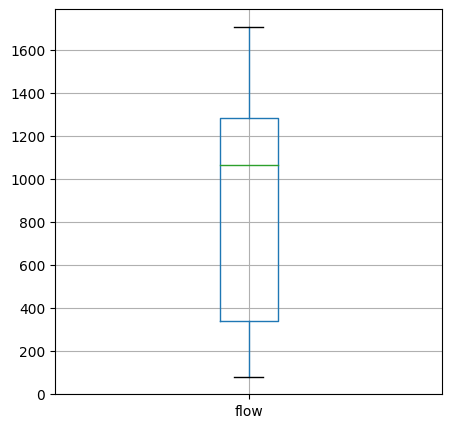

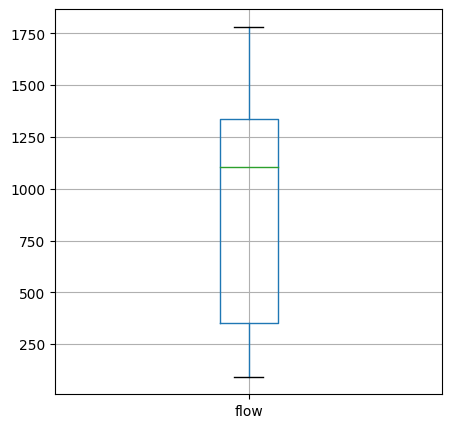

In [113]:
# check distribution of mcs flow
plt.figure(1, figsize=(5,5))
boxplot = combinedNorth.boxplot(column=['flow'])

plt.figure(2, figsize=(5,5))
boxplot = combinedSouth.boxplot(column=['flow'])

             speed_inrix     speed
speed_inrix     1.000000  0.905542
speed           0.905542  1.000000


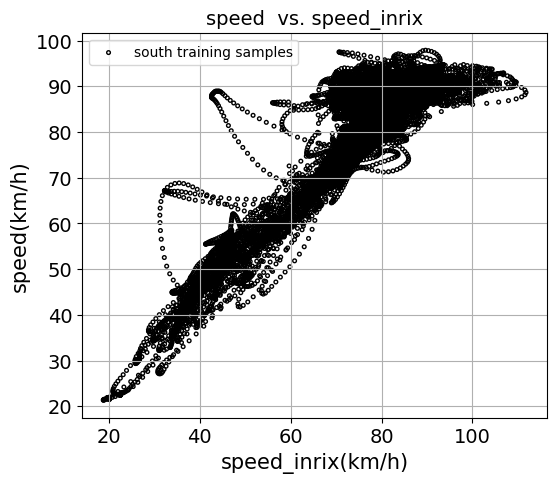

In [114]:
# draw plot of Speed_mcs vs. Speed_inrix
combinedCorr1 = combinedSouth.iloc[:idx(combinedSouth, 22)][['speed_inrix', 'speed']].copy() 
print(combinedCorr1.corr())

plt.figure(figsize=(6,5))
plt.grid()
plotScatter(combinedCorr1, combinedCorr1, 'speed_inrix', 'speed', 'south training samples', '(km/h)', '(km/h)', 'best')

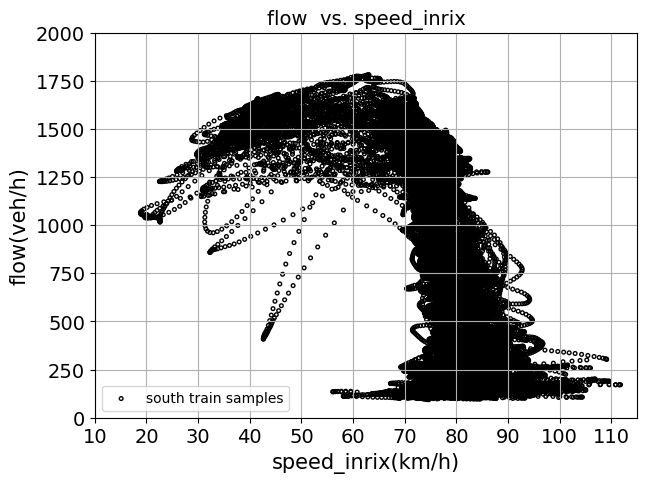

In [115]:
# draw flow-speed_inrix FD
combinedCorr2 = combinedSouth.iloc[:idx(combinedSouth, 29)][['speed', 'speed_inrix', 'flow', 'travel_time_secs']].copy()

plt.figure(figsize=(7,5))
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plt.grid()
plotScatter(combinedCorr2, combinedCorr2, 'speed_inrix', 'flow', 'south train samples', '(km/h)', '(veh/h)', 'lower left')

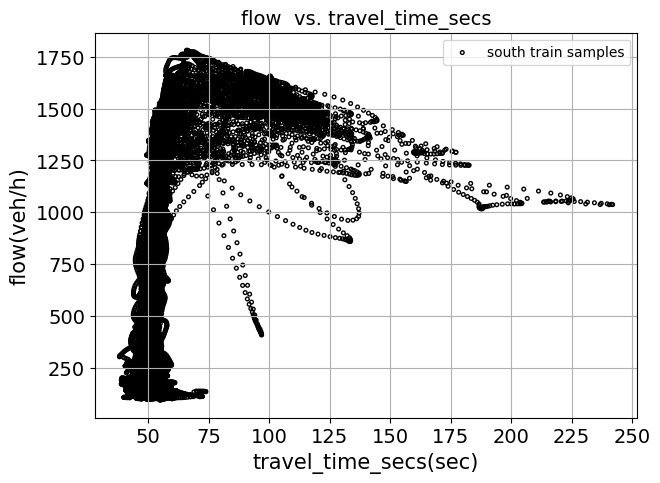

In [116]:
# draw flow-travel_time_inrix FD
plt.figure(figsize=(7,5))
plt.grid()
plotScatter(combinedCorr2, combinedCorr2, 'travel_time_secs', 'flow', 'south train samples', '(sec)', '(veh/h)', 'upper right')

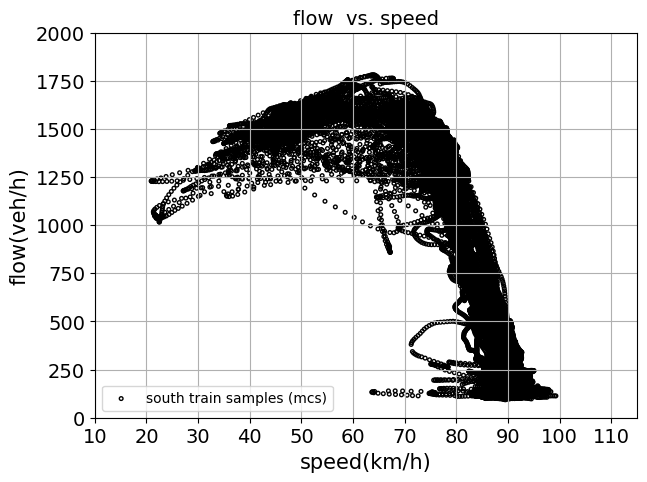

In [118]:
# draw flow_mcs vs. Speed_mcs after time step matched
plt.figure(figsize=(7,5))
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plt.grid()
plotScatter(combinedCorr2, combinedCorr2, 'speed', 'flow', 'south train samples (mcs)', '(km/h)', '(veh/h)', 'lower left')


             speed_inrix     speed
speed_inrix     1.000000  0.921659
speed           0.921659  1.000000


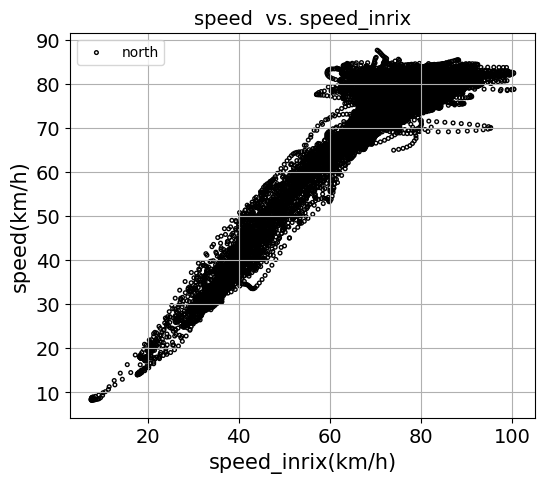

In [103]:
# draw plot of Speed_mcs vs. Speed_inrix
combinedCorr1 = combinedNorth.iloc[:idx(combinedNorth, 29)][['speed_inrix', 'speed']].copy() 
print(combinedCorr1.corr())

plt.figure(figsize=(6,5))
plt.grid()
plotScatter(combinedCorr1, combinedCorr1, 'speed_inrix', 'speed', 'north', '(km/h)', '(km/h)', 'upper left')

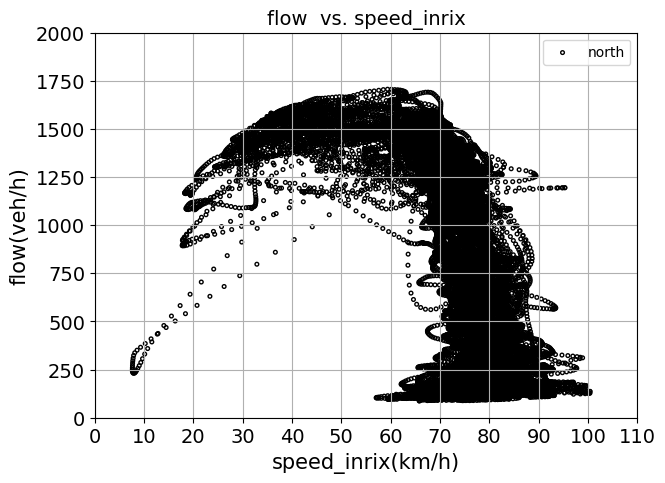

In [104]:
# draw flow-speed_inrix FD
combinedCorr2 = combinedNorth.iloc[:idx(combinedNorth, 29)][['speed', 'speed_inrix', 'flow', 'travel_time_secs']].copy()

plt.figure(figsize=(7,5))
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 0, right = 110)
x_ticks = np.arange(0, 116, 10)
plt.xticks(x_ticks)
plt.grid()
plotScatter(combinedCorr2, combinedCorr2, 'speed_inrix', 'flow', 'north', '(km/h)', '(veh/h)', 'best')

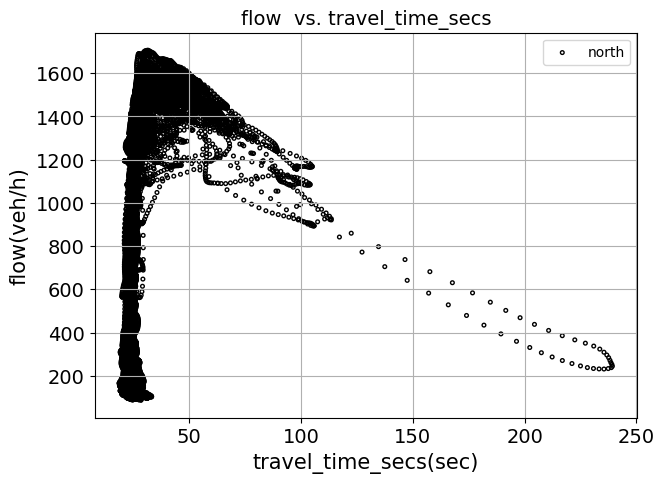

In [105]:
# draw flow-travel_time_inrix FD
plt.figure(figsize=(7,5))
plt.grid()
plotScatter(combinedCorr2, combinedCorr2, 'travel_time_secs', 'flow', 'north', '(sec)', '(veh/h)', 'upper right')

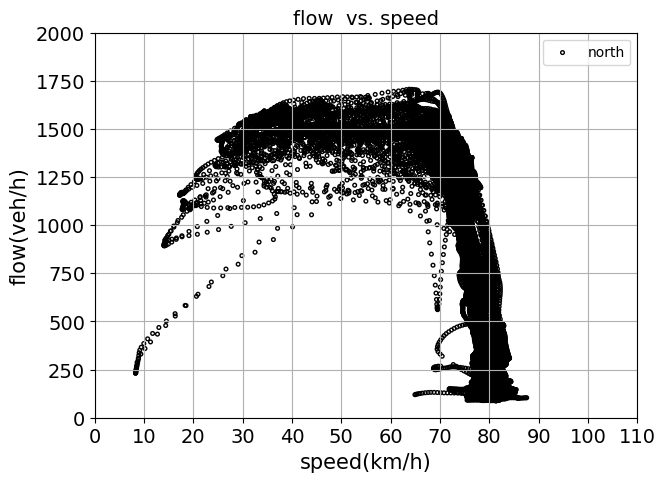

In [106]:
# draw flow_mcs vs. Speed_mcs after time step matched
plt.figure(figsize=(7,5))
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 0, right = 110)
x_ticks = np.arange(0, 116, 10)
plt.xticks(x_ticks)
plt.grid()
plotScatter(combinedCorr2, combinedCorr2, 'speed', 'flow', 'north', '(km/h)', '(veh/h)', 'best')

## 4.6 Add Temporal Factors and Spatial Factors
1. 24 hours
2. weekday/weekend
3. South/North

In [ ]:
# load the combined/pre-processed dataframe
# start from this cell if data frame has been processed before
combinedNorth = pd.read_pickle('OutData2/InrixMcsNorth.pkl')
combinedSouth = pd.read_pickle('OutData2/InrixMcsSouth.pkl')

2018-10-05 17:50:00
2018-10-06 00:03:00


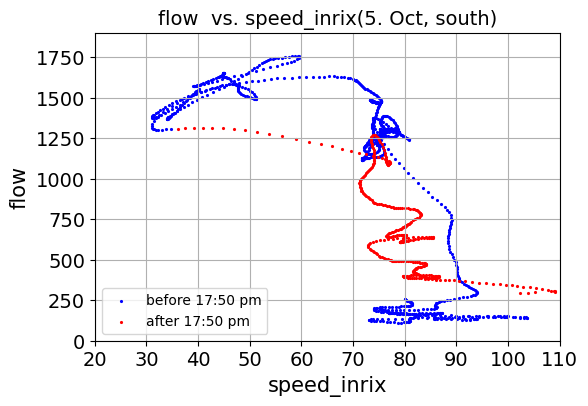

In [ ]:
# examine the different flow-speed relationship in different time-segments within a day
date = 5
deltaStart1 = 0
deltaEnd1 = 1012
deltaEnd2 = 1380
print(combinedSouth.iloc[idx(combinedSouth, date) + deltaEnd1].date)
print(combinedSouth.iloc[idx(combinedSouth, date) + deltaEnd2].date)


plt.figure(figsize=(6,4))
plt.style.use('default')
plt.grid()
plt.xlim(left = 20, right = 110)
plt.ylim(bottom = 0, top = 1900)
plotScatterSegments(combinedSouth.iloc[idx(combinedSouth, date) + deltaStart1:idx(combinedSouth, date) + deltaEnd1],
            combinedSouth.iloc[idx(combinedSouth, date) + deltaEnd1:idx(combinedSouth, date) + deltaEnd2],
            'speed_inrix', 'flow', 'before 17:50 pm', 'after 17:50 pm', '(5. Oct, south)', 'lower left')

2018-10-05 17:50:00
2018-10-06 00:01:00


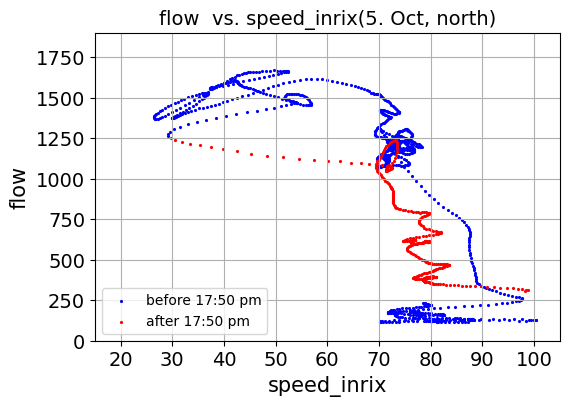

In [ ]:
# examine the different flow-speed relationship in different time-segments within a day
date = 5
deltaStart1 = 0
deltaEnd1 = 1015
deltaEnd2 = 1380
print(combinedNorth.iloc[idx(combinedNorth, date) + deltaEnd1].date)
print(combinedNorth.iloc[idx(combinedNorth, date) + deltaEnd2].date)


plt.figure(figsize=(6,4))
plt.style.use('default')
plt.grid()
plt.xlim(left = 15, right = 105)
plt.ylim(bottom = 0, top = 1900)
plotScatterSegments(combinedNorth.iloc[idx(combinedNorth, date) + deltaStart1:idx(combinedNorth, date) + deltaEnd1],
            combinedNorth.iloc[idx(combinedNorth, date) + deltaEnd1:idx(combinedNorth, date) + deltaEnd2],
            'speed_inrix', 'flow', 'before 17:50 pm', 'after 17:50 pm', '(5. Oct, north)', 'lower left')

2018-10-06 00:03:00
2018-10-07 23:59:00


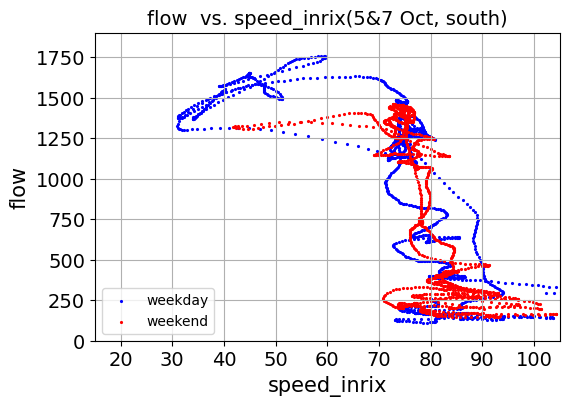

In [ ]:
# examine the different flow-speed relationship in different days within a week
date1 = 5
date2 = 7
deltaEnd1 = 1380
deltaEnd2 = 1380

print(combinedSouth.iloc[idx(combinedSouth, date1) + deltaEnd1].date)
print(combinedSouth.iloc[idx(combinedSouth, date2) + deltaEnd2].date)


plt.figure(figsize=(6,4))
plt.style.use('default')
plt.grid()
plt.xlim(left = 15, right = 105)
plt.ylim(bottom = 0, top = 1900)
plotScatterSegments(combinedSouth.iloc[idx(combinedSouth, date1):idx(combinedSouth, date1) + deltaEnd1],
            combinedSouth.iloc[idx(combinedSouth, date2):idx(combinedSouth, date2) + deltaEnd2],
            'speed_inrix', 'flow', 'weekday', 'weekend', '(5&7 Oct, south)', 'lower left')

2018-10-06 00:01:00
2018-10-08 00:01:00


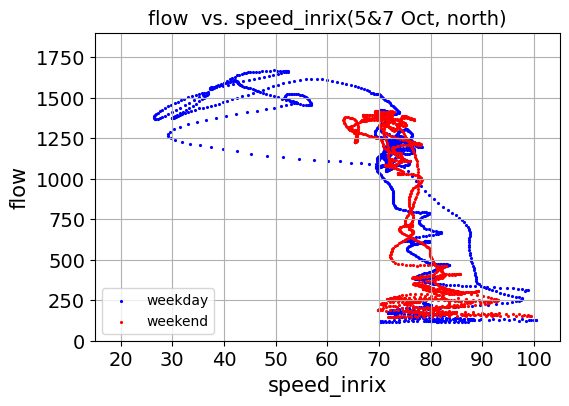

In [ ]:
# examine the different flow-speed relationship in different days within a week
date1 = 5
date2 = 7
deltaEnd1 = 1380
deltaEnd2 = 1380

print(combinedNorth.iloc[idx(combinedNorth, date1) + deltaEnd1].date)
print(combinedNorth.iloc[idx(combinedNorth, date2) + deltaEnd2].date)


plt.figure(figsize=(6,4))
plt.style.use('default')
plt.grid()
plt.xlim(left = 15, right = 105)
plt.ylim(bottom = 0, top = 1900)
plotScatterSegments(combinedNorth.iloc[idx(combinedNorth, date1):idx(combinedNorth, date1) + deltaEnd1],
            combinedNorth.iloc[idx(combinedNorth, date2):idx(combinedNorth, date2) + deltaEnd2],
            'speed_inrix', 'flow', 'weekday', 'weekend', '(5&7 Oct, north)', 'lower left')

In [ ]:
# one-hot encoding instances' hour and weekend (North)
for i in range(0, 24):
  combinedNorth[str(i)] = 0.0

combinedNorth['weekday'] = 0.0
combinedNorth['weekend'] = 0.0
combinedNorth['south'] = 0.0
combinedNorth['north'] = 0.0

for i in range(len(combinedNorth)):
  hour = combinedNorth.iloc[i].date.hour
  day = combinedNorth.iloc[i].date.day % 7
  id = combinedNorth.iloc[i].fk_id
  # convert hour of each instance into one-hot encoding
  combinedNorth.loc[i, str(hour)] = 1.0

  # convert weekday/weekend of each instance into one-hot encoding
  if day == 6 or day == 0:
    combinedNorth.loc[i, 'weekend'] = 1.0
  else:
    combinedNorth.loc[i, 'weekday'] = 1.0

  # add south/north one-hot encoding as spatial feature
  if id == 1159:
    combinedNorth.loc[i, 'south'] = 1.0
  else: 
    combinedNorth.loc[i, 'north'] = 1.0


In [ ]:
combinedNorth.loc[[3700:3705]]

fk_id                date      speed  ...  weekend  south  north
0       1162 2018-10-01 02:09:00  81.140350  ...      0.0    0.0    1.0
1       1162 2018-10-01 02:10:00  80.964857  ...      0.0    0.0    1.0
2       1162 2018-10-01 02:11:00  80.884268  ...      0.0    0.0    1.0
3       1162 2018-10-01 02:12:00  80.891293  ...      0.0    0.0    1.0
4       1162 2018-10-01 02:13:00  80.928894  ...      0.0    0.0    1.0
...      ...                 ...        ...  ...      ...    ...    ...
41952   1162 2018-10-31 23:36:00  79.391846  ...      0.0    0.0    1.0
41953   1162 2018-10-31 23:37:00  79.192683  ...      0.0    0.0    1.0
41954   1162 2018-10-31 23:38:00  79.011376  ...      0.0    0.0    1.0
41955   1162 2018-10-31 23:39:00  78.818770  ...      0.0    0.0    1.0
41956   1162 2018-10-31 23:40:00  78.647613  ...      0.0    0.0    1.0

[41957 rows x 45 columns]

In [ ]:
# one-hot encoding instances' hour and weekend (North)
for i in range(0, 24):
  combinedSouth[str(i)] = 0.0

combinedSouth['weekday'] = 0.0
combinedSouth['weekend'] = 0.0
combinedSouth['south'] = 0.0
combinedSouth['north'] = 0.0

for i in range(len(combinedSouth)):
  hour = combinedSouth.iloc[i].date.hour
  day = combinedSouth.iloc[i].date.day % 7
  id = combinedSouth.iloc[i].fk_id
  # convert hour of each instance into one-hot encoding
  combinedSouth.loc[i, str(hour)] = 1.0

  # convert weekday/weekend of each instance into one-hot encoding
  if day == 6 or day == 0:
    combinedSouth.loc[i, 'weekend'] = 1.0
  else:
    combinedSouth.loc[i, 'weekday'] = 1.0

  # add south/north one-hot encoding as spatial feature
  if id == 1159:
    combinedSouth.loc[i, 'south'] = 1.0
  else: 
    combinedSouth.loc[i, 'north'] = 1.0


In [ ]:
combinedSouth.iloc[3700:3705]

fk_id                date      speed  ...  weekend  south  north
3700   1159 2018-10-03 20:19:00  81.091616  ...      0.0    1.0    0.0
3701   1159 2018-10-03 20:20:00  81.178690  ...      0.0    1.0    0.0
3702   1159 2018-10-03 20:21:00  81.236410  ...      0.0    1.0    0.0
3703   1159 2018-10-03 20:22:00  81.302226  ...      0.0    1.0    0.0
3704   1159 2018-10-03 20:23:00  81.377290  ...      0.0    1.0    0.0

[5 rows x 45 columns]

In [ ]:
# save the dataset as .csv and pandas .pkl file
combinedNorth.to_pickle('OutData2/InrixMcsNorth.pkl')
combinedNorth.to_csv('OutData2/InrixMcsNorth.csv')

In [ ]:
# save the dataset as .csv and pandas .pkl file
combinedSouth.to_pickle('OutData2/InrixMcsSouth.pkl')
combinedSouth.to_csv('OutData2/InrixMcsSouth.csv')

## 4.7 Compute and add the density feature
* compute the density from flow and speed_inrix based on Density = Flow / Speed relation

In [ ]:
# # load the combined/pre-processed dataframe
# # start from this cell if data frame has been processed before
# combinedSouth = pd.read_pickle('OutData2/InrixMcsSouth.pkl')
# combinedNorth = pd.read_pickle('OutData2/InrixMcsNorth.pkl')

In [ ]:
# calculate the density based on traditional traffic state variable relationship
combinedNorth['density'] = combinedNorth['flow'] / combinedNorth['speed_inrix']
combinedSouth['density'] = combinedSouth['flow'] / combinedSouth['speed_inrix']

In [ ]:
# save the dataset as .csv and pandas .pkl file
combinedNorth.to_pickle('OutData2/InrixMcsNorth.pkl')
combinedNorth.to_csv('OutData2/InrixMcsNorth.csv')

In [ ]:
# save the dataset as .csv and pandas .pkl file
combinedSouth.to_pickle('OutData2/InrixMcsSouth.pkl')
combinedSouth.to_csv('OutData2/InrixMcsSouth.csv')

# <em>Part II Baseline Model

# 5. Multi-regime Regression Model</em>
Use multi-regime linear/polynomial regression model to capture the relation between flow and speed(inrix)

* Use the first three-week data as training set (75%), and the last one week data as test set (25%).
* Use 10% cross-validation datasets to tune the hyperparameters, ie, the structure of the model.
* Train the final baseline model using whole training set.



## 5.1 Split the training set and test set

In [16]:
# load the combined/pre-processed dataframe
# start from this cell if data frame has been processed before
combinedSouth = pd.read_pickle('OutData2/InrixMcsSouth.pkl')
combinedNorth = pd.read_pickle('OutData2/InrixMcsNorth.pkl')

In [17]:
# split 3 week historical data as training set
if MAIN == 'south':
  trainMain = combinedSouth.iloc[:idx(combinedSouth, 22)]
  trainNeighbor = combinedNorth.iloc[:idx(combinedNorth, 22)]
else: 
  trainMain = combinedNorth.iloc[:idx(combinedNorth, 22)]
  trainNeighbor = combinedSouth.iloc[:idx(combinedSouth, 22)]

In [18]:
# split 1 week historical data as testing set
if MAIN == 'south':
  testMain = combinedSouth.iloc[idx(combinedSouth, 22):idx(combinedSouth, 29)]
  testNeighbor = combinedNorth.iloc[idx(combinedNorth, 22):idx(combinedNorth, 29)]
else:
  testMain = combinedNorth.iloc[idx(combinedNorth, 22):idx(combinedNorth, 29)]
  testNeighbor = combinedSouth.iloc[idx(combinedSouth, 22):idx(combinedSouth, 29)]

## 5.2 Helper functions

---



In [19]:
# function for turning single feature into polynomial feature columns 
# Input X: numpy array with shape(sample number, 1)
# Output X_poly: numpy array with shape(sample #, polynomial degree + 1) Note: 1 for bias, could be turned off in the argument
def makePoly(deg, X, bias = True):
  poly = PolynomialFeatures(degree = deg,include_bias = bias)
  X_poly = poly.fit_transform(X)
  return X_poly

In [20]:
# function for turning multi feature input into polynomial feature columns 
# Input X: numpy array with shape(sample number, # of features)
# Output X_poly: numpy array with shape(sample #, polynomial degree + 1) Note: 1 for bias
def makePoly_multi(deg, X, bias = True):
  poly = PolynomialFeatures(degree = deg,include_bias = bias)
  X_poly = poly.fit_transform(X)
  return X_poly

In [21]:
# funtion for normalizing the feature columns
# Input: X: Numpy array with shape(sample #, polynomial degree + 1)
# Output X_scaled: normalized Numpy array with shape(sample #, polynomial degree + 1)
# Output scaler: scaler, which fitted on input array, for normalization
def normalize(X, Scaler=None):
  # remove the bias column
  X_1 = np.delete(X, 0, 1)

  # scale the remaining feature columns
  scaler = None
  X_2 = None

  if(Scaler==None):
    scaler = StandardScaler()
    X_2 = scaler.fit_transform(X_1)
  else:
    scaler = Scaler
    X_2 = scaler.transform(X_1)

  # add the bias column back to the features columns
  ones = np.ones((len(X_2), 1))
  X_scaled = np.append(ones, X_2, 1)
  
  return X_scaled, scaler

In [22]:
# function used to print the cross-validation scores 
def display_scores(scores):
  print("RMSE Scores:", scores)
  print("RMSE Mean:", scores.mean()) 
  print("Standard deviation:", scores.std())

In [23]:
def display_error(Y, Y_predict, mapeFunc):
  rmse = mean_squared_error(Y, Y_predict, squared=False)
  mape = mapeFunc(Y, Y_predict)
  r2 = r2_score(Y, Y_predict)
  print("RMSE: ", "%.1f" % rmse)
  print("MAPE: ", "%.1f" % mape, '%')
  print("r2: ", "%.3f" % r2)

In [171]:
# visualize instances (scatter) and the model curve (plot)
# plot 3 curves: 1 threshold line (X0, Y0), 1 free-flow model (X1, Y1), 1 congested-model (X2, Y2), data-set instances (dataframe, attribute1, attribute2)
def plotFD(X, Y, Y_predict, label1, label2,  xLabelUnit, yLabelUnit, title, legendLoc):
  # plt.scatter(X, Y, facecolors='none', edgecolors='brown', alpha=0.5, s=12, label=label1)
  plt.scatter(X, Y_predict, color='red', s=2.0, label=label2)
  plt.xlabel(xLabelUnit, fontsize = 14)
  plt.ylabel(yLabelUnit, fontsize = 14)
  plt.xticks(fontsize = 14)
  plt.yticks(fontsize = 14)
  plt.grid()
  plt.legend(loc=legendLoc, fontsize=10)
  plt.title(title, fontsize = 15)
  plt.show()

## 5.3 Split the training set into different traffic regime
* determine the threshold speed(inrix) from flow-density diagram (70km/hr)<br>
1. free-flow regime <br>
2.  congested regime <br>


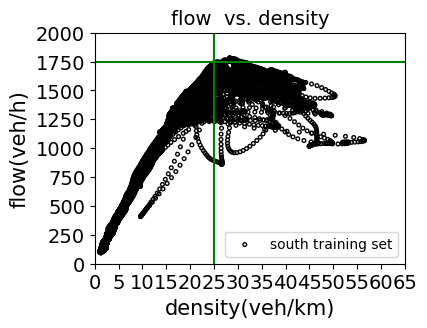

In [168]:
# plot the flow-density diagram to determine the threshold of traffic state regions
plt.figure(figsize=(4,3))
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 0, right = 65)
x_ticks = np.arange(0, 66, 5)
plt.xticks(x_ticks)
xThreshold1 = [25, 25]
yThreshold1 = [0, 2000]
plt.plot(xThreshold1, yThreshold1, color='green', linewidth=1.5)
xThreshold2 = [0, 65]
yThreshold2 = [1750, 1750]
plt.plot(xThreshold2, yThreshold2, color='green', linewidth=1.5)
# plt.grid()
plotScatter(trainMain, trainMain, 'density', 'flow', MAIN + ' training set', '(veh/km)', '(veh/h)', 'best')

In [26]:
# calculate the threshold speed (70 km/h)
THRESHOLD = 1750 / 25.0

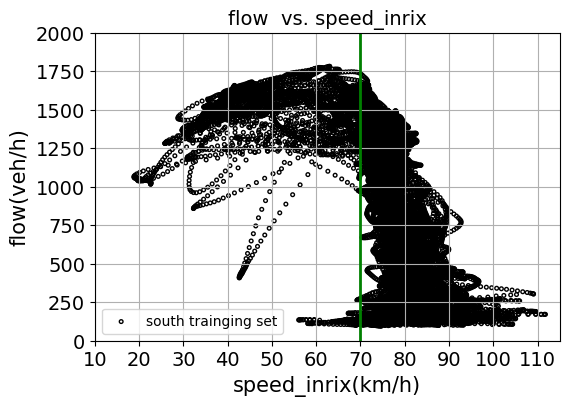

In [27]:
# show the threshold line between free-flow & congested regimes
plt.figure(figsize=(6,4))
plt.style.use('default')
plt.grid()
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
xThreshold = [THRESHOLD, THRESHOLD]
yThreshold = [0, 2000]
plt.plot(xThreshold, yThreshold, color='green', linewidth=2)
plotScatter(trainMain, trainMain, 'speed_inrix', 'flow', MAIN + ' trainging set', '(km/h)', '(veh/h)', 'lower left')

In [28]:
# split the training set into 2 datasets corresponding to 2 traffic regimes
trainMain_free = trainMain[trainMain['speed_inrix'] >= THRESHOLD]
trainMain_congested = trainMain[trainMain['speed_inrix'] < THRESHOLD]

## 5.4 Regression model for free-flow regime

* Use linear regression to model the flow-speed relation in free-flow regime



In [29]:
# prepare feature vector and label vactor for training
X = trainMain_free['speed_inrix'].values.reshape(-1, 1)
Y = trainMain_free['flow'].values.reshape(-1, 1)

In [30]:
# train the model using the whole training set
free_flow_model = LinearRegression()
free_flow_model.fit(X, Y)

# predict using training set
Y_predict = free_flow_model.predict(X)

# Evaluate the training error
print("evaluate the training error (free-flow regime):")
display_error(Y, Y_predict, mape)


evaluate the training error (free-flow regime):
RMSE:  390.9
MAPE:  101.7 %
r2:  0.344


In [31]:
# Use 10 folds cross-validation to fit and validate the linear regression model
# Validation dataset is 10% of training set to ensure no over-fitting
scores = cross_val_score(LinearRegression(), X, Y, scoring='neg_root_mean_squared_error', cv=10)
print('Validation error (free-flow regime):')
display_scores(-scores)

Validation error (free-flow regime):
RMSE Scores: [453.70428877 384.59478406 340.59306662 386.1115537  423.10438762
 395.41265383 351.58699702 408.99054032 411.3963249  344.29631606]
RMSE Mean: 389.97909128987567
Standard deviation: 34.71547153939032


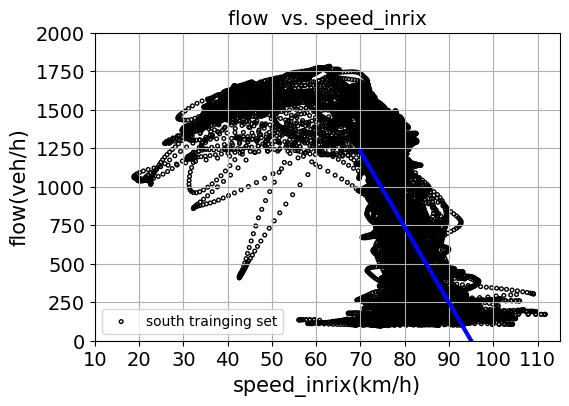

In [32]:
# Visualization of linear regression model
X_model = np.array([70, 100]).reshape(-1, 1)
Y_model = free_flow_model.predict(X_model)

plt.figure(figsize=(6,4))
plt.style.use('default')
plt.grid()
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plt.plot(X_model, Y_model, color='blue', linewidth=3.0)
plotScatter(trainMain, trainMain, 'speed_inrix', 'flow', MAIN + ' trainging set', '(km/h)', '(veh/h)', 'lower left')


In [33]:
# save the label vector and predict value vector for computing the training error
Y_free_flow = Y
Y_predict_free_flow = Y_predict

## 5.5 Polynomial regression model for congested regime

* Use regression to model the congested relation in congested regime



In [34]:
# prepare feature vector and label vactor for training
X = trainMain_congested['speed_inrix'].values.reshape(-1, 1)
Y = trainMain_congested['flow'].values.reshape(-1, 1)

# prepare polynomial features matrix: degree = 2
X2 = makePoly(2, X, False)

# prepare polynomial features matrix: degree = 3
X3 = makePoly(3, X, False)

# prepare polynomial features matrix: degree = 4
X4 = makePoly(4, X, False)

In [35]:
# linear regression (deg = 1)
# Use 10 folds cross-validation to fit and validate the linear regression model
# Validation dataset is 10% of training set to ensure no over-fitting
scores = cross_val_score(LinearRegression(), X, Y, scoring='neg_root_mean_squared_error', cv=10)
print('Validation error (congested regime):')
display_scores(-scores)

Validation error (congested regime):
RMSE Scores: [434.95941423 204.44496634 299.13146363 605.94843341 354.16397956
 188.96784526 148.56880916 493.8796308  390.15326158 385.07056627]
RMSE Mean: 350.5288370250827
Standard deviation: 136.58901023978325


In [36]:
# polynomial regression (deg = 2)
# Use 10 folds cross-validation to fit and validate the linear regression model
# Validation dataset is 10% of training set to ensure no over-fitting
scores = cross_val_score(LinearRegression(), X2, Y, scoring='neg_root_mean_squared_error', cv=10)
print('Validation error (congested regime):')
display_scores(-scores)

Validation error (congested regime):
RMSE Scores: [417.54651416 218.97906756 220.16969214 574.79576158 292.37149352
 168.06346512 155.52029344 488.58632631 372.87860168 416.95272055]
RMSE Mean: 332.5863936068674
Standard deviation: 135.84634463000472


In [37]:
# polynomial regression (deg = 3)
# Use 10 folds cross-validation to fit and validate the linear regression model
# Validation dataset is 10% of training set to ensure no over-fitting
scores = cross_val_score(LinearRegression(), X3, Y, scoring='neg_root_mean_squared_error', cv=10)
print('Validation error (congested regime):')
display_scores(-scores)

Validation error (congested regime):
RMSE Scores: [419.47191369 224.43773539 218.72407173 574.89675327 292.1845757
 166.89411438 157.18135658 492.02547982 372.10106627 416.91681248]
RMSE Mean: 333.48338793195256
Standard deviation: 135.96438322012168


In [38]:
# polynomial regression (deg = 4)
# Use 10 folds cross-validation to fit and validate the linear regression model
# Validation dataset is 10% of training set to ensure no over-fitting
scores = cross_val_score(LinearRegression(), X4, Y, scoring='neg_root_mean_squared_error', cv=10)
print('Validation error (congested regime):')
display_scores(-scores)

Validation error (congested regime):
RMSE Scores: [420.32179396 225.1754342  224.41662735 575.6872531  291.55959878
 168.38304725 156.57055417 494.27860206 372.08031071 417.88197853]
RMSE Mean: 334.6355200100687
Standard deviation: 135.86697201839718


In [39]:
# train the model using the whole training set (congested regime)
congested_model = LinearRegression()
congested_model.fit(X2, Y)

# predict using training set
Y_predict = congested_model.predict(X2)

# Evaluate the training error
print("evaluate the training error (congested regime):")
display_error(Y, Y_predict, mape)

evaluate the training error (congested regime):
RMSE:  352.5
MAPE:  68.2 %
r2:  0.117


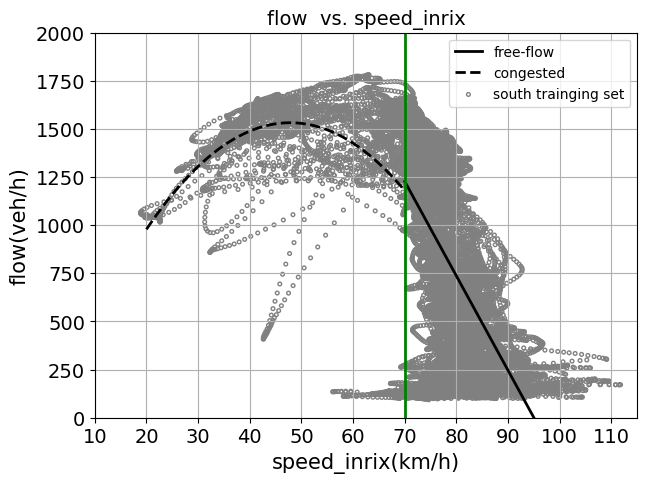

In [40]:
# Visualization of regression model curve at congested regime
X_model_congested = np.arange(20, 71, 1).reshape(-1, 1)
X_model_sqr = makePoly(2, X_model_congested, False)
Y_model_congested = congested_model.predict(X_model_sqr)

# Visualization of linear regression model at free-flow regime
X_model = np.array([70, 100]).reshape(-1, 1)
Y_model = free_flow_model.predict(X_model)

# The threshold line
xThreshold = [70, 70]
yThreshold = [0, 2000]

# plot the figure of dataset instances and baseline model's curve
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotScatterModel(trainMain, 'speed_inrix', 'flow', MAIN + ' trainging set',
                   xThreshold, yThreshold,
                   X_model, Y_model, 'free-flow',
                   X_model_congested, Y_model_congested, 'congested',
                   '(km/h)', '(veh/h)', 'best')


In [41]:
# evaluate training error
Y_train = np.concatenate((Y_free_flow, Y))
Y_predict_train = np.concatenate((Y_predict_free_flow, Y_predict))

print("baseline-model training error: ")
display_error(Y_train, Y_predict_train, mape)


baseline-model training error: 
RMSE:  385.2
MAPE:  96.5 %
r2:  0.438


## 5.6 Construct the baseline model
Combine 2-regime models into the final baseline model

In [42]:
# baseline model that combining the 2 models corresponding to the free-flow regime and congested regime
class BaselineModel:
  def __init__(self, ff_model, c_model, threshold):
    self.threshold = threshold
    self.free_flow_model = ff_model
    self.congested_model = c_model
  
  # input: np array with shape (#, 1)
  # output: predicted np array with shape (#, 1)
  def predict(self, X):
    Y_predict = np.zeros((len(X), 1))

    for i in range(len(Y_predict)):
      if X[i, 0] >= self.threshold:
        # use free-flow model to estimate flow
        x = X[i].reshape(-1, 1) # shape(1, 1)
        y = self.free_flow_model.predict(x) # shape: (1, 1)
        Y_predict[i, 0] = y[0, 0]
      else:
        # use congested model to estimate flow
        poly = PolynomialFeatures(degree = 2,include_bias = False)
        x = poly.fit_transform(X[i].reshape(-1, 1)) # shape: (2, 1)
        y = self.congested_model.predict(x) # shape: (1, 1)
        Y_predict[i, 0] = y[0, 0]
      
    return Y_predict 

In [43]:
baselineModel = BaselineModel(free_flow_model, congested_model, THRESHOLD)

## 5.7 Evaluate the test error on the same segment



In [44]:
# test error (same road segment)
X_testMain = testMain['speed_inrix'].values.reshape(-1, 1)
Y_testMain = testMain['flow'].values.reshape(-1, 1)
Y_predict_testMain = baselineModel.predict(X_testMain)

In [45]:
# evaluate the test error on North segment
print('test error on the north segment:')
display_error(Y_testMain, Y_predict_testMain, mape)

test error on the north segment:
RMSE:  381.0
MAPE:  98.7 %
r2:  0.440


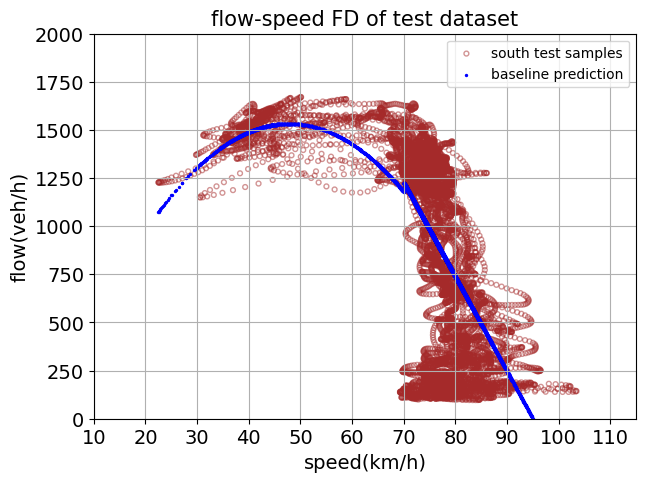

In [59]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotFD(X_testMain, Y_testMain, Y_predict_testMain,
                  MAIN + ' test samples', 'baseline prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

## 5.8 Evaluate the test error on the downstream segment (South)

In [47]:
# test error (same road segment)
X_testNeighbor = testNeighbor['speed_inrix'].values.reshape(-1, 1)
Y_testNeighbor = testNeighbor['flow'].values.reshape(-1, 1)
Y_predict_testNeighbor = baselineModel.predict(X_testNeighbor)

In [48]:
# evaluate the test error on North segment
print('test error on neighboring ' + NEIGHBOR +  ' segment:')
display_error(Y_testNeighbor, Y_predict_testNeighbor, mape)

test error on neighboring north segment:
RMSE:  423.2
MAPE:  127.0 %
r2:  0.257


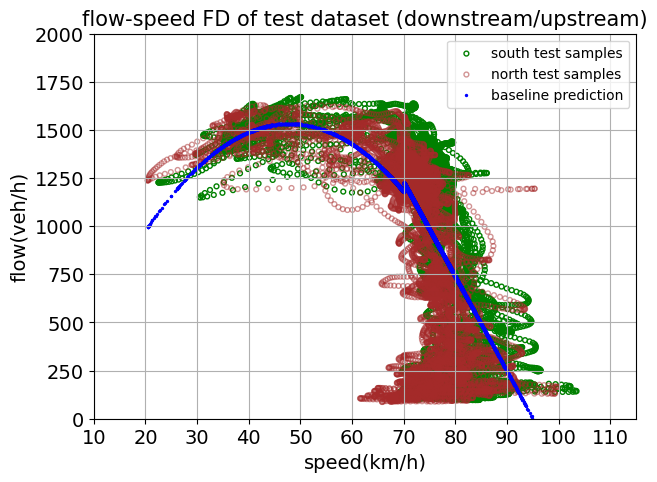

In [58]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plt.scatter(X_testMain, Y_testMain, facecolors='none', edgecolor='green', s=12, label= MAIN + ' test samples')
plotFD(X_testNeighbor, Y_testNeighbor, Y_predict_testNeighbor,
                  NEIGHBOR + ' test samples', 'baseline prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset (downstream/upstream)', 'best')

## 5.9 Baseline Model's Error Summary

In [50]:
# prepare the training sets for Main an neighbor segments
X_trainMain = trainMain['speed_inrix'].values.reshape(-1, 1)
Y_trainMain = trainMain['flow'].values.reshape(-1, 1)

X_trainNeighbor = trainNeighbor['speed_inrix'].values.reshape(-1, 1)
Y_trainNeighbor = trainNeighbor['flow'].values.reshape(-1, 1)


# evaluate training error
Y_predict_trainMain = baselineModel.predict(X_trainMain)
print("baseline-model(speed) training error: ")
display_error(Y_trainMain, Y_predict_trainMain, mape)
print()

# evaluate test error (same segment)
mainMAPEs.append(mape(Y_testMain, Y_predict_testMain))
mainRMSEs.append(mean_squared_error(Y_testMain, Y_predict_testMain, squared=False))
print('baseline-model(speed) test error (same road segment):')
display_error(Y_testMain, Y_predict_testMain, mape)
print()

# evaluate training error (neighbor segment)
Y_predict_trainNeighbor = baselineModel.predict(X_trainNeighbor)
print('baseline-model(speed) training error (neighbor road segment):')
display_error(Y_trainNeighbor, Y_predict_trainNeighbor, mape)
print()

# evaluate test error (neighbor segment)
neighborMAPEs.append(mape(Y_testNeighbor, Y_predict_testNeighbor))
neighborRMSEs.append(mean_squared_error(Y_testNeighbor, Y_predict_testNeighbor, squared=False))
print('baseline-model(speed) test error (neighbor road segment):')
display_error(Y_testNeighbor, Y_predict_testNeighbor, mape)



baseline-model(speed) training error: 
RMSE:  385.2
MAPE:  96.5 %
r2:  0.438

baseline-model(speed) test error (same road segment):
RMSE:  381.0
MAPE:  98.7 %
r2:  0.440

baseline-model(speed) training error (neighbor road segment):
RMSE:  403.6
MAPE:  117.6 %
r2:  0.331

baseline-model(speed) test error (neighbor road segment):
RMSE:  423.2
MAPE:  127.0 %
r2:  0.257


# <em>Part III. Neural Network Model

Part III aims to implement neural network model for estimating the traffic flow using INRIX data.
* Feedforward neural network with Deep & Wide architecture




# 6. Feedforward Neural Network (Deep&Wide Architecture)

## 6.0 import the processed datasets

import the datasets preporcessed in part I and part II

* north segment dataset
* south segment dataset

In [61]:
# load the combined/pre-processed dataframe
# start from this cell if data frame has been processed before
combinedSouth = pd.read_pickle('OutData2/InrixMcsSouth.pkl')
combinedNorth = pd.read_pickle('OutData2/InrixMcsNorth.pkl')

In [62]:
# split 3 week historical data as training set
if MAIN == 'south':
  trainMain = combinedSouth.iloc[:idx(combinedSouth, 22)]
  trainNeighbor = combinedNorth.iloc[:idx(combinedNorth, 22)]
else: 
  trainMain = combinedNorth.iloc[:idx(combinedNorth, 22)]
  trainNeighbor = combinedSouth.iloc[:idx(combinedSouth, 22)]

In [63]:
# split 1 week historical data as testing set
if MAIN == 'south':
  testMain = combinedSouth.iloc[idx(combinedSouth, 22):idx(combinedSouth, 29)]
  testNeighbor = combinedNorth.iloc[idx(combinedNorth, 22):idx(combinedNorth, 29)]
else:
  testMain = combinedNorth.iloc[idx(combinedNorth, 22):idx(combinedNorth, 29)]
  testNeighbor = combinedSouth.iloc[idx(combinedSouth, 22):idx(combinedSouth, 29)]

## 6.2 helper functions for NN

In [64]:
# funtion for normalizing(standardizing) the feature-column values
# Input: X: Numpy array with shape(sample #, feature #)
# Output X_scaled: normalized Numpy array with shape(sample #, feature #)
# Output scaler: scaler which fitted on input array
def normalize_nobias(X, Scaler=None):

  # scale the remaining feature columns
  scaler = None
  X_normalized = None

  if(Scaler==None):
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
  else:
    scaler = Scaler
    X_normalized = scaler.transform(X)

  
  return X_normalized, scaler

In [65]:
# helper function for building the DNN model for INRIX
# Input args: number of input feature (wo batch size)
# return value: a model
def NNModel(n_input):
  n_hidden1 = 120
  n_hidden2 = 60
  n_hidden3 = 30
  n_output = 1
  
  input1 = Input(shape=n_input)
  hidden1 = Dense(units=n_hidden1, activation='elu')(input1)
  hidden2 = Dense(units=n_hidden2, activation='elu')(hidden1)
  hidden3 = Dense(units=n_hidden3, activation='elu')(hidden2)
  concat1 = Concatenate()([input1, hidden3])
  output1 = Dense(units=n_output, activation='linear')(concat1)

  model = Model(inputs=input1, outputs=output1, name='NN_model')
  model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

  return model

## 6.3 NN with 1 feature: Speed

In [132]:
# prepare the feature vector, label vector for training set (Main)
Epoch_trainMain = trainMain['Epoch_mcs'].values
X_trainMain = trainMain[['speed_inrix']].values.reshape(-1,1)
Y_trainMain = trainMain['flow'].values.reshape(-1, 1)

 # prepare the feature vector, label vector for test set (Main)
Epoch_testMain = testMain['Epoch_mcs'].values
X_testMain = testMain[['speed_inrix']].values.reshape(-1,1)
Y_testMain = testMain['flow'].values.reshape(-1,1)

# prepare the feature vector, label vector for training set (neighbor)
Epoch_trainNeighbor = trainNeighbor['Epoch_mcs'].values
X_trainNeighbor = trainNeighbor[['speed_inrix']].values.reshape(-1,1)
Y_trainNeighbor = trainNeighbor['flow'].values.reshape(-1, 1)

# prepare the feature vector, label vector for test set (neighbor)
Epoch_testNeighbor = testNeighbor['Epoch_mcs'].values
X_testNeighbor = testNeighbor[['speed_inrix']].values.reshape(-1,1)
Y_testNeighbor = testNeighbor['flow'].values.reshape(-1,1)

In [133]:
# normalize the training feature vectors (North)
X_trainMain, scaler_trainMain = normalize_nobias(X_trainMain)

# normalize the training feature vectors (South)
X_trainNeighbor, scaler_trainNeighbor = normalize_nobias(X_trainNeighbor)

if HISTORICALSTANDAR == True:
# normalize the test feature vectors (North)
  X_testMain, scaler_testMain = normalize_nobias(X_testMain, scaler_trainMain)

# normalize the test feature vectors (North)
  X_testNeighbor, scaler_testNeighbor = normalize_nobias(X_testNeighbor, scaler_trainNeighbor)

else:
  # normalize the test feature vectors (North)
  X_testMain, scaler_testMain = normalize_nobias(X_testMain)

# normalize the test feature vectors (North)
  X_testNeighbor, scaler_testNeighbor = normalize_nobias(X_testNeighbor)

In [ ]:
# # build the NN model with 1-dimensional input vector:
# n_input = X_trainMain.shape[1:]
# nnModel = NNModel(n_input)

# # display the model
# nnModel.summary()

NN with Deep and Wide structure:


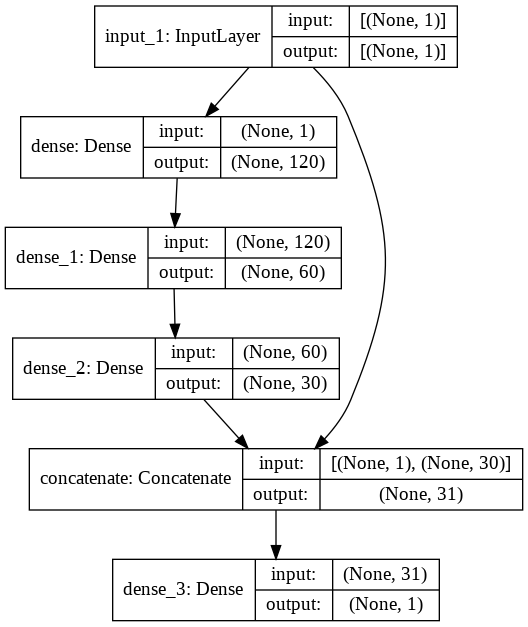

In [ ]:
# print('NN with Deep and Wide structure:')
# plot_model(nnModel, 'OutData2/NN_Model_speed.png', show_shapes = True)

In [ ]:
# # compute validation error
# # build the NN model for validation
# n_input = X_trainMain.shape[1:]
# nnValidModel = NNModel(n_input)

# # prepare the validation set
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainMain, Y_trainMain, test_size=0.2, random_state=1)
# # model training
# history = nnValidModel.fit(X_train, Y_train, epochs=20, verbose=1, validation_data=(X_valid, Y_valid))

Epoch 1/20
715/715 [==============================] - 2s 2ms/step - loss: 647517.5661 - mean_absolute_percentage_error: 92.8687 - val_loss: 159114.0938 - val_mean_absolute_percentage_error: 102.1415
Epoch 2/20
715/715 [==============================] - 1s 2ms/step - loss: 149898.5174 - mean_absolute_percentage_error: 94.5062 - val_loss: 148871.0156 - val_mean_absolute_percentage_error: 98.2291
Epoch 3/20
715/715 [==============================] - 1s 2ms/step - loss: 143788.0068 - mean_absolute_percentage_error: 92.3459 - val_loss: 147226.9531 - val_mean_absolute_percentage_error: 95.8690
Epoch 4/20
715/715 [==============================] - 1s 2ms/step - loss: 143184.1692 - mean_absolute_percentage_error: 92.1063 - val_loss: 146324.4219 - val_mean_absolute_percentage_error: 95.7499
Epoch 5/20
715/715 [==============================] - 1s 2ms/step - loss: 143826.3116 - mean_absolute_percentage_error: 92.2863 - val_loss: 144994.5312 - val_mean_absolute_percentage_error: 93.4736
Epoch 6/2

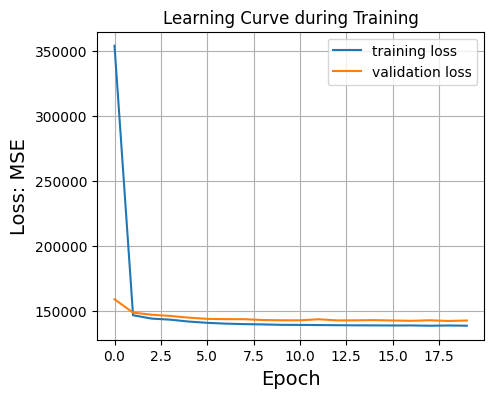

In [ ]:
# # plot loss and accuracy history
# plt.figure(figsize=(5, 4))
# plt.style.use('default')
# plt.plot(history.history['loss'], label='training loss')
# plt.plot(history.history['val_loss'], label='validation loss')
# plt.xlabel("Epoch", size=14)
# plt.ylabel("Loss: MSE", size=14)
# plt.title('Learning Curve during Training')
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# # train the model
# history = nnModel.fit(X_trainMain, Y_trainMain, epochs=20, verbose=1)

Epoch 1/20
893/893 [==============================] - 2s 1ms/step - loss: 557634.5598 - mean_absolute_percentage_error: 93.8354
Epoch 2/20
893/893 [==============================] - 1s 1ms/step - loss: 147441.6002 - mean_absolute_percentage_error: 94.0067
Epoch 3/20
893/893 [==============================] - 1s 1ms/step - loss: 143478.1179 - mean_absolute_percentage_error: 91.3073
Epoch 4/20
893/893 [==============================] - 1s 1ms/step - loss: 142250.1219 - mean_absolute_percentage_error: 90.8262
Epoch 5/20
893/893 [==============================] - 1s 1ms/step - loss: 142948.9944 - mean_absolute_percentage_error: 90.2940
Epoch 6/20
893/893 [==============================] - 1s 1ms/step - loss: 139145.9631 - mean_absolute_percentage_error: 88.1848
Epoch 7/20
893/893 [==============================] - 1s 1ms/step - loss: 141596.9134 - mean_absolute_percentage_error: 89.3720
Epoch 8/20
893/893 [==============================] - 1s 1ms/step - loss: 140843.3442 - mean_absolute_pe

In [134]:
# load the pre-trained univariate NN model
nnModel = keras.models.load_model("/content/gdrive/My Drive/degree_project/models/nnModel_speed/historical_scaler.h5")

In [135]:
# evaluate training error
Y_predict_trainMain = nnModel.predict(X_trainMain)

# evaluate training error
print("NN-model(speed) training error: ")
display_error(Y_trainMain, Y_predict_trainMain, mape)
print()

# evaluate test error (same segment)
Y_predict_testMain = nnModel.predict(X_testMain)
mainMAPEs.append(mape(Y_testMain, Y_predict_testMain))
mainRMSEs.append(mean_squared_error(Y_testMain, Y_predict_testMain, squared=False))
print('NN-model(speed) test error (same road segment):')
display_error(Y_testMain, Y_predict_testMain, mape)
print()

# evaluate training error (neighbor segment)
Y_predict_trainNeighbor = nnModel.predict(X_trainNeighbor)
print('NN-model(speed) training error (neighbor road segment):')
display_error(Y_trainNeighbor, Y_predict_trainNeighbor, mape)
print()

# evaluate test error (neighbor segment)
Y_predict_testNeighbor = nnModel.predict(X_testNeighbor)
neighborMAPEs.append(mape(Y_testNeighbor, Y_predict_testNeighbor))
neighborRMSEs.append(mean_squared_error(Y_testNeighbor, Y_predict_testNeighbor, squared=False))
print('NN-model(speed) test error (neighbor road segment):')
display_error(Y_testNeighbor, Y_predict_testNeighbor, mape)



NN-model(speed) training error: 
RMSE:  372.6
MAPE:  87.6 %
r2:  0.474

NN-model(speed) test error (same road segment):
RMSE:  373.6
MAPE:  92.4 %
r2:  0.461

NN-model(speed) training error (neighbor road segment):
RMSE:  375.6
MAPE:  95.1 %
r2:  0.420

NN-model(speed) test error (neighbor road segment):
RMSE:  391.5
MAPE:  106.1 %
r2:  0.364


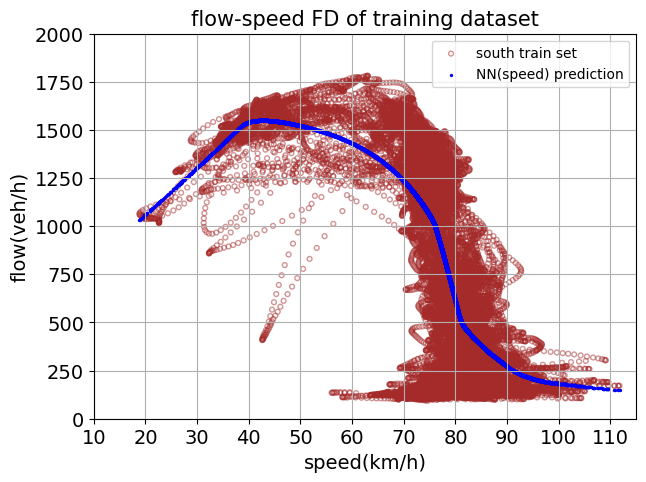

In [136]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotFD(trainMain[['speed_inrix']], Y_trainMain, Y_predict_trainMain,
                  MAIN + ' train set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of training dataset', 'best')

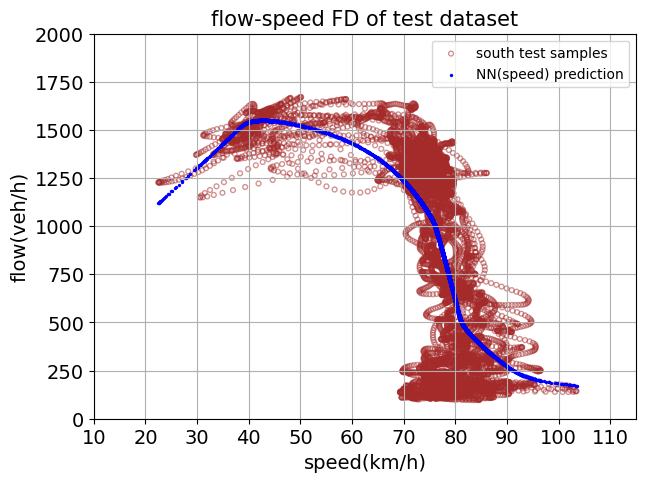

In [137]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotFD(testMain[['speed_inrix']], Y_testMain, Y_predict_testMain,
                  MAIN + ' test samples', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

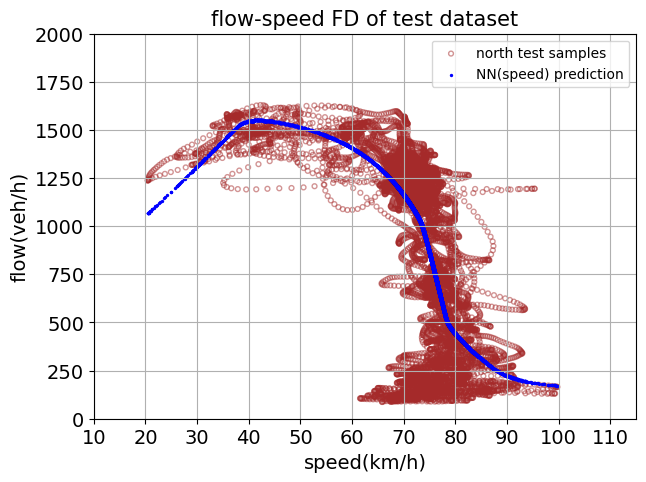

In [138]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotFD(testNeighbor[['speed_inrix']], Y_testNeighbor, Y_predict_testNeighbor,
                  NEIGHBOR + ' test samples', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

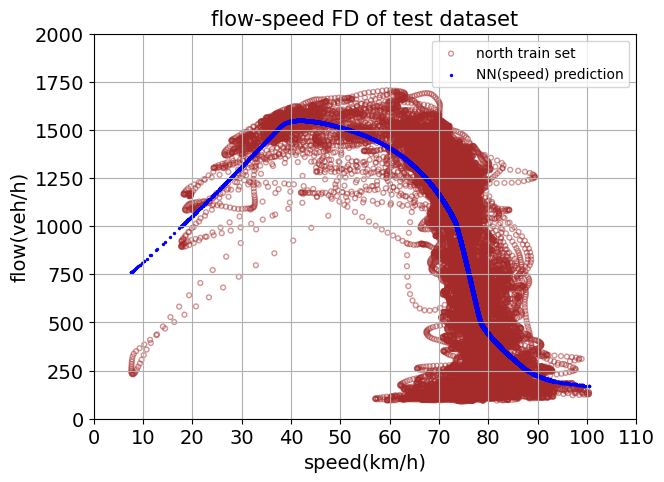

In [139]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 0, right = 110)
x_ticks = np.arange(0, 116, 10)
plt.xticks(x_ticks)
plotFD(trainNeighbor[['speed_inrix']], Y_trainNeighbor, Y_predict_trainNeighbor,
                  NEIGHBOR + ' train set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

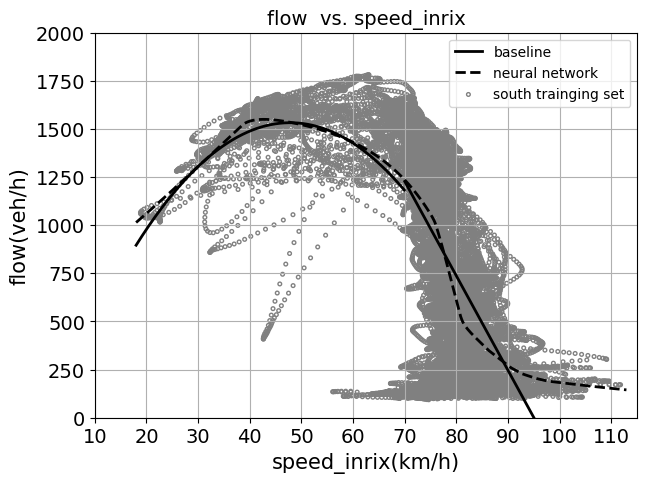

In [140]:
# Visualization of baseline model curve
X_baseline1 = np.arange(18, 70, 0.1).reshape(-1, 1) # free-flow
Y_predict_baseline1 = baselineModel.predict(X_baseline1)
X_baseline2 = np.arange(70, 113, 0.1).reshape(-1, 1) # congested
Y_predict_baseline2 = baselineModel.predict(X_baseline2)

# Visualization of NN model
X_NN_raw = np.arange(18, 113, 0.1).reshape(-1, 1)
X_NN, scaler_dummy = normalize_nobias(X_NN_raw, scaler_trainMain)
Y_predict_NN = nnModel.predict(X_NN)

# The threshold line
xThreshold = []
yThreshold = []

# plot the figure of dataset instances and baseline model's curve
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plt.plot(X_baseline2, Y_predict_baseline2, color='black', linewidth=2, ls='solid')
plotScatterModel(trainMain, 'speed_inrix', 'flow', MAIN + ' trainging set',
                   xThreshold, yThreshold,
                   X_baseline1, Y_predict_baseline1, 'baseline',
                   X_NN_raw, Y_predict_NN, 'neural network',
                   '(km/h)', '(veh/h)', 'best')


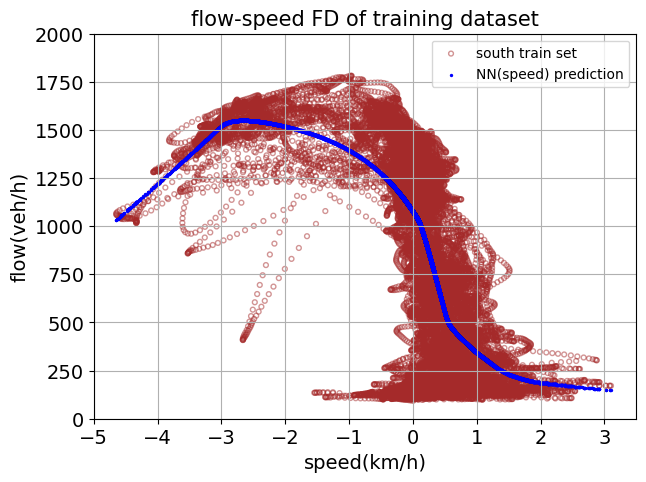

In [141]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left=-5.0, right=3.5)
x_ticks = np.arange(-5.0, 3.6, 1.0)
plt.xticks(x_ticks)
plotFD(X_trainMain[:,0], Y_trainMain, Y_predict_trainMain,
                  MAIN + ' train set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of training dataset', 'best')

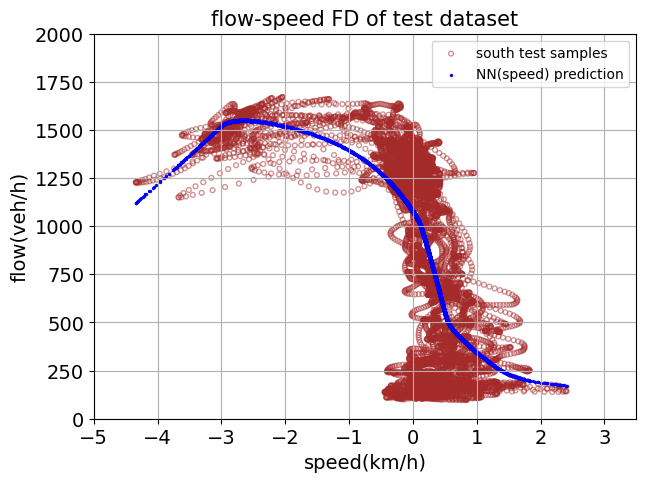

In [142]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left=-5.0, right=3.5)
x_ticks = np.arange(-5.0, 3.6, 1.0)
plt.xticks(x_ticks)
plotFD(X_testMain, Y_testMain, Y_predict_testMain,
                  MAIN + ' test samples', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

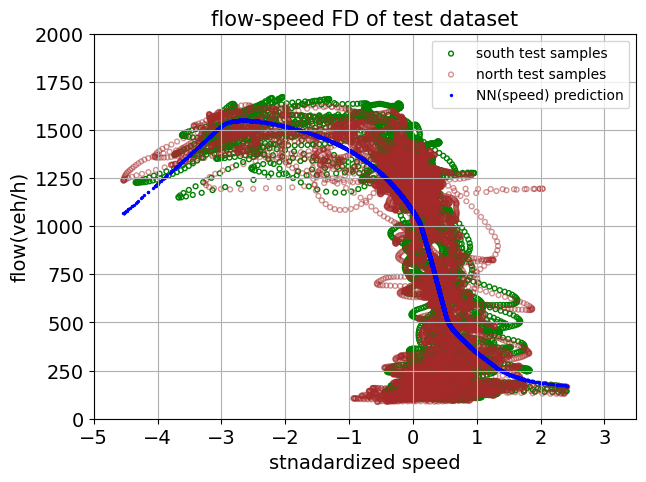

In [145]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left=-5.0, right=3.5)
x_ticks = np.arange(-5.0, 3.6, 1.0)
plt.xticks(x_ticks)
plt.scatter(X_testMain, Y_testMain, facecolors='none', edgecolor='green', s=12, label= MAIN + ' test samples')
plotFD(X_testNeighbor, Y_testNeighbor, Y_predict_testNeighbor,
                  NEIGHBOR + ' test samples', 'NN(speed) prediction', 'stnadardized speed', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

In [144]:
# # save the model
# model_version = MODEL_VERSION + ".h5"
# model_name = "nnModel_speed"
# model_path = os.path.join(root_path, 'models', model_name, model_version)
# print(model_path)

In [ ]:
# # save the NN model to the model_path
# nnModel.save(model_path)

## 6.4 NN with 2 features: Speed, Travel-time

In [ ]:
# prepare the feature vector, label vector for training set (Main)
Epoch_trainMain = trainMain['Epoch_mcs'].values
X_trainMain = trainMain[['speed_inrix', 'travel_time_secs']].values
Y_trainMain = trainMain['flow'].values.reshape(-1, 1)

 # prepare the feature vector, label vector for test set (Main)
Epoch_testMain = testMain['Epoch_mcs'].values
X_testMain = testMain[['speed_inrix', 'travel_time_secs']].values
Y_testMain = testMain['flow'].values.reshape(-1,1)

# prepare the feature vector, label vector for training set (neighbor)
Epoch_trainNeighbor = trainNeighbor['Epoch_mcs'].values
X_trainNeighbor = trainNeighbor[['speed_inrix', 'travel_time_secs']].values
Y_trainNeighbor = trainNeighbor['flow'].values.reshape(-1, 1)

# prepare the feature vector, label vector for test set (neighbor)
Epoch_testNeighbor = testNeighbor['Epoch_mcs'].values
X_testNeighbor = testNeighbor[['speed_inrix', 'travel_time_secs']].values
Y_testNeighbor = testNeighbor['flow'].values.reshape(-1,1)

In [ ]:
# normalize the training feature vectors (North)
X_trainMain, scaler_trainMain = normalize_nobias(X_trainMain)

# normalize the training feature vectors (South)
X_trainNeighbor, scaler_trainNeighbor = normalize_nobias(X_trainNeighbor)

if HISTORICALSTANDAR == True:
# normalize the test feature vectors (North)
  X_testMain, scaler_testMain = normalize_nobias(X_testMain, scaler_trainMain)

# normalize the test feature vectors (North)
  X_testNeighbor, scaler_testNeighbor = normalize_nobias(X_testNeighbor, scaler_trainNeighbor)

else:
  # normalize the test feature vectors (North)
  X_testMain, scaler_testMain = normalize_nobias(X_testMain)

# normalize the test feature vectors (North)
  X_testNeighbor, scaler_testNeighbor = normalize_nobias(X_testNeighbor)

In [ ]:
# # build the NN model with 1-dimensional input vector:
# n_input = X_trainMain.shape[1:]
# nnModel_st = NNModel(n_input)

# # display the model
# nnModel_st.summary()

NN with Deep and Wide structure:


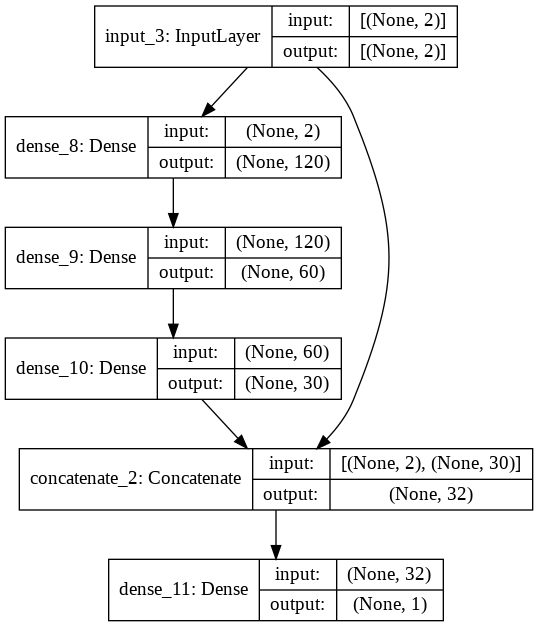

In [ ]:
# print('NN with Deep and Wide structure:')
# plot_model(nnModel_st, 'OutData2/NN_Model_speed_travel.png', show_shapes = True)

In [ ]:
# # compute validation error
# # build the NN model for validation
# n_input = X_trainMain.shape[1:]
# nnValidModel_st = NNModel(n_input)

# # prepare the validation set
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainMain, Y_trainMain, test_size=0.2, random_state=1)
# # model training
# history = nnValidModel_st.fit(X_train, Y_train, epochs=20, verbose=1, validation_data=(X_valid, Y_valid))

Epoch 1/20
715/715 [==============================] - 2s 2ms/step - loss: 621221.0537 - mean_absolute_percentage_error: 92.3378 - val_loss: 148098.6719 - val_mean_absolute_percentage_error: 95.5185
Epoch 2/20
715/715 [==============================] - 1s 2ms/step - loss: 145122.9815 - mean_absolute_percentage_error: 92.4004 - val_loss: 145395.8906 - val_mean_absolute_percentage_error: 93.6237
Epoch 3/20
715/715 [==============================] - 1s 2ms/step - loss: 139414.9950 - mean_absolute_percentage_error: 88.8422 - val_loss: 143577.0781 - val_mean_absolute_percentage_error: 89.3502
Epoch 4/20
715/715 [==============================] - 1s 2ms/step - loss: 141482.0501 - mean_absolute_percentage_error: 88.8158 - val_loss: 142459.0312 - val_mean_absolute_percentage_error: 89.6548
Epoch 5/20
715/715 [==============================] - 1s 2ms/step - loss: 137632.1782 - mean_absolute_percentage_error: 87.0267 - val_loss: 141951.3438 - val_mean_absolute_percentage_error: 90.2202
Epoch 6/20

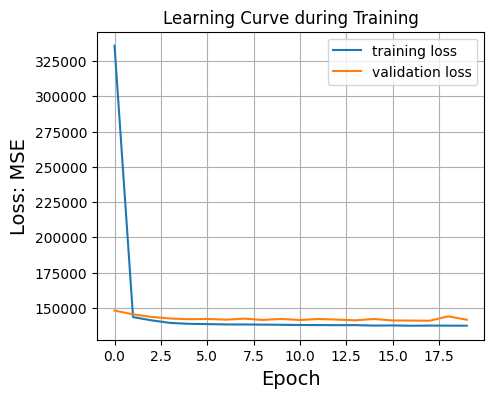

In [ ]:
# # plot loss and accuracy history
# plt.figure(figsize=(5, 4))
# plt.style.use('default')
# plt.plot(history.history['loss'], label='training loss')
# plt.plot(history.history['val_loss'], label='validation loss')
# plt.xlabel("Epoch", size=14)
# plt.ylabel("Loss: MSE", size=14)
# plt.title('Learning Curve during Training')
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# # model training
# history = nnModel_st.fit(X_trainMain, Y_trainMain, epochs=20, verbose=1)

Epoch 1/20
893/893 [==============================] - 2s 1ms/step - loss: 576855.5071 - mean_absolute_percentage_error: 93.4336
Epoch 2/20
893/893 [==============================] - 1s 2ms/step - loss: 143834.0057 - mean_absolute_percentage_error: 91.4703
Epoch 3/20
893/893 [==============================] - 1s 2ms/step - loss: 144351.8276 - mean_absolute_percentage_error: 92.0297
Epoch 4/20
893/893 [==============================] - 1s 2ms/step - loss: 142244.1587 - mean_absolute_percentage_error: 89.9757
Epoch 5/20
893/893 [==============================] - 1s 1ms/step - loss: 137861.1700 - mean_absolute_percentage_error: 87.0551
Epoch 6/20
893/893 [==============================] - 1s 1ms/step - loss: 139594.8588 - mean_absolute_percentage_error: 88.1450
Epoch 7/20
893/893 [==============================] - 1s 1ms/step - loss: 140451.1485 - mean_absolute_percentage_error: 88.7696
Epoch 8/20
893/893 [==============================] - 1s 1ms/step - loss: 139682.8854 - mean_absolute_pe

In [ ]:
# load pre-trained model
nnModel_st = keras.models.load_model("/content/gdrive/My Drive/degree_project/models/nnModel_speed_travelTime/historical_scaler.h5")

In [ ]:
# evaluate training error
Y_predict_trainMain = nnModel_st.predict(X_trainMain)

# evaluate training error
print("NN-model(speed, travel time) training error: ")
display_error(Y_trainMain, Y_predict_trainMain, mape)
print()

# evaluate test error (same segment)
Y_predict_testMain = nnModel_st.predict(X_testMain)
mainMAPEs.append(mape(Y_testMain, Y_predict_testMain))
mainRMSEs.append(mean_squared_error(Y_testMain, Y_predict_testMain, squared=False))
print('NN-model(speed, travel time) test error (same road segment):')
display_error(Y_testMain, Y_predict_testMain, mape)
print()

# evaluate training error (neighbor segment)
Y_predict_trainNeighbor = nnModel_st.predict(X_trainNeighbor)
print('NN-model(speed, travel time) training error (neighbor road segment):')
display_error(Y_trainNeighbor, Y_predict_trainNeighbor, mape)
print()

# evaluate test error (neighbor segment)
Y_predict_testNeighbor = nnModel_st.predict(X_testNeighbor)
neighborMAPEs.append(mape(Y_testNeighbor, Y_predict_testNeighbor))
neighborRMSEs.append(mean_squared_error(Y_testNeighbor, Y_predict_testNeighbor, squared=False))
print('NN-model(speed, travel time) test error (neighbor road segment):')
display_error(Y_testNeighbor, Y_predict_testNeighbor, mape)



NN-model(speed, travel time) training error: 
RMSE:  371.3
MAPE:  86.6 %
r2:  0.478

NN-model(speed, travel time) test error (same road segment):
RMSE:  372.8
MAPE:  91.7 %
r2:  0.464

NN-model(speed, travel time) training error (neighbor road segment):
RMSE:  382.8
MAPE:  92.7 %
r2:  0.398

NN-model(speed, travel time) test error (neighbor road segment):
RMSE:  398.0
MAPE:  103.8 %
r2:  0.343


In [ ]:
print(mainMAPEs)
print(neighborMAPEs)
print(mainRMSEs)
print(neighborRMSEs)

[98.72547922663874, 92.36011258635257, 91.67513164715947]
[127.00135863249442, 106.05464088912903, 103.827140809261]
[380.9805246284607, 373.5637593463067, 372.82850163596555]
[423.150200018346, 391.5325352197633, 397.96773979009924]


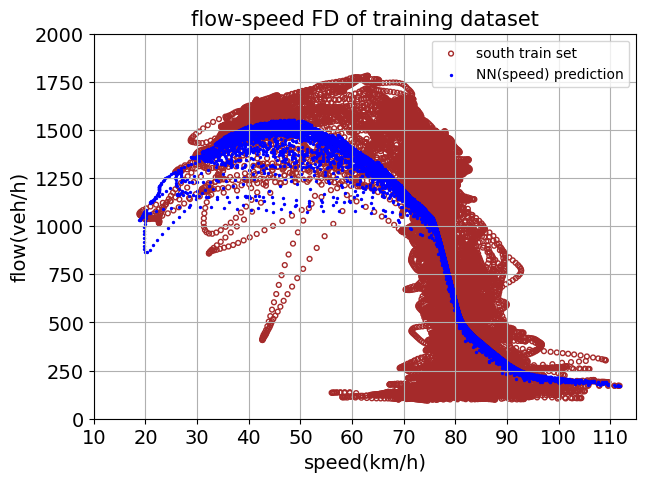

In [ ]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotFD(trainMain[['speed_inrix']], Y_trainMain, Y_predict_trainMain,
                  MAIN + ' train set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of training dataset', 'best')

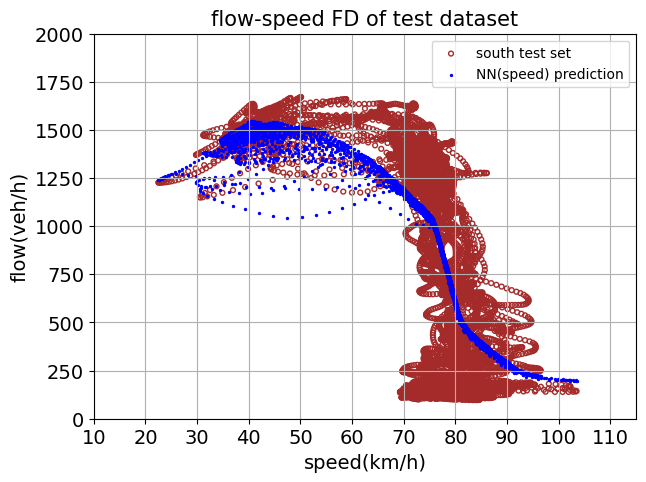

In [ ]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotFD(testMain[['speed_inrix']], Y_testMain, Y_predict_testMain,
                  MAIN + ' test set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

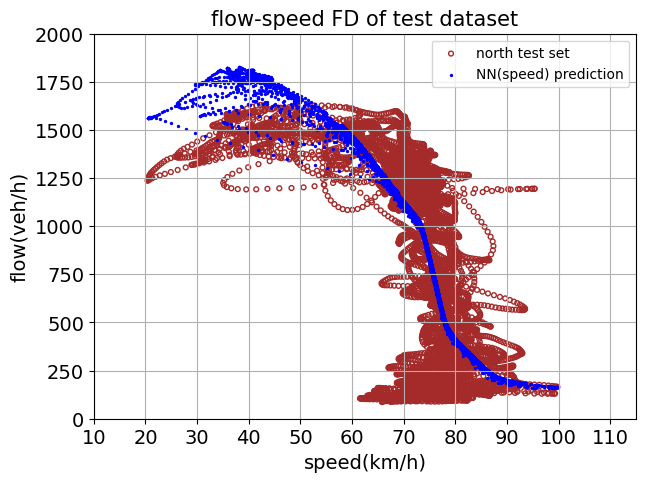

In [ ]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotFD(testNeighbor[['speed_inrix']], Y_testNeighbor, Y_predict_testNeighbor,
                  NEIGHBOR + ' test set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

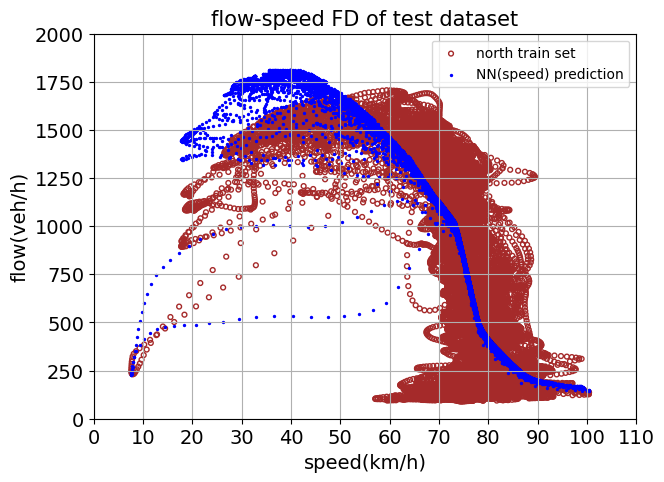

In [ ]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 0, right = 110)
x_ticks = np.arange(0, 116, 10)
plt.xticks(x_ticks)
plotFD(trainNeighbor[['speed_inrix']], Y_trainNeighbor, Y_predict_trainNeighbor,
                  NEIGHBOR + ' train set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

In [ ]:
# # save the model
# model_version = MODEL_VERSION + ".h5"
# model_name = "nnModel_speed_travelTime"
# model_path = os.path.join(root_path, 'models', model_name, model_version)
# print(model_path)

/content/gdrive/My Drive/degree_project/models/nnModel_speed_travelTime/historical_scaler_classicW&D.h5


In [ ]:
# # save the NN model to the model_path
# nnModel_st.save(model_path)

## 6.5 NN with 1 features + temporal features: Speed




In [ ]:
# prepare the feature vector, label vector for training set (Main)
Epoch_trainMain = trainMain['Epoch_mcs'].values
X_trainMain = trainMain[['speed_inrix']].values.reshape(-1, 1)
X_trainMain_temporalHour = trainMain[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                                  '10', '11', '12', '13', '14', '15', '16', '17',
                                  '18', '19', '20', '21', '22', '23', 'weekday', 'weekend']].values
Y_trainMain = trainMain['flow'].values.reshape(-1, 1)

 # prepare the feature vector, label vector for test set (Main)
Epoch_testMain = testMain['Epoch_mcs'].values
X_testMain = testMain[['speed_inrix']].values.reshape(-1, 1)
X_testMain_temporalHour = testMain[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                                  '10', '11', '12', '13', '14', '15', '16', '17',
                                  '18', '19', '20', '21', '22', '23', 'weekday', 'weekend']].values
Y_testMain = testMain['flow'].values.reshape(-1,1)

# prepare the feature vector, label vector for training set (neighbor)
Epoch_trainNeighbor = trainNeighbor['Epoch_mcs'].values
X_trainNeighbor = trainNeighbor[['speed_inrix']].values.reshape(-1, 1)
X_trainNeighbor_temporalHour = trainNeighbor[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                                  '10', '11', '12', '13', '14', '15', '16', '17',
                                  '18', '19', '20', '21', '22', '23', 'weekday', 'weekend']].values
Y_trainNeighbor = trainNeighbor['flow'].values.reshape(-1, 1)

# prepare the feature vector, label vector for test set (neighbor)
Epoch_testNeighbor = testNeighbor['Epoch_mcs'].values
X_testNeighbor = testNeighbor[['speed_inrix']].values.reshape(-1, 1)
X_testNeighbor_temporalHour = testNeighbor[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                                  '10', '11', '12', '13', '14', '15', '16', '17',
                                  '18', '19', '20', '21', '22', '23', 'weekday', 'weekend']].values
Y_testNeighbor = testNeighbor['flow'].values.reshape(-1,1)

In [ ]:
# normalize the training/testing feature vectors + append the temporal factor:
# North training
X_trainMain, scaler_trainMain = normalize_nobias(X_trainMain)
X_trainMain = np.append(X_trainMain, X_trainMain_temporalHour, axis=1)

# South training
X_trainNeighbor, scaler_trainNeighbor = normalize_nobias(X_trainNeighbor)
X_trainNeighbor = np.append(X_trainNeighbor, X_trainNeighbor_temporalHour, axis=1)

if HISTORICALSTANDAR == True:
# North test
  X_testMain, scaler_testMain = normalize_nobias(X_testMain, scaler_trainMain)
  X_testMain = np.append(X_testMain, X_testMain_temporalHour, axis=1)

# south test
  X_testNeighbor, scaler_testNeighbor = normalize_nobias(X_testNeighbor, scaler_trainNeighbor)
  X_testNeighbor = np.append(X_testNeighbor, X_testNeighbor_temporalHour, axis=1)
else:
  # North test
  X_testMain, scaler_testMain = normalize_nobias(X_testMain)
  X_testMain = np.append(X_testMain, X_testMain_temporalHour, axis=1)

# south test
  X_testNeighbor, scaler_testNeighbor = normalize_nobias(X_testNeighbor)
  X_testNeighbor = np.append(X_testNeighbor, X_testNeighbor_temporalHour, axis=1)



In [ ]:
# # build the NN model with 1-dimensional input vector:
# n_input = X_trainMain.shape[1:]
# nnModel_s_hour = NNModel(n_input)

# # display the model
# nnModel_s_hour.summary()

Model: "NN_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 120)          3360        input_5[0][0]                    
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 60)           7260        dense_16[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 30)           1830        dense_17[0][0]                   
___________________________________________________________________________________________

NN with Deep and Wide structure:


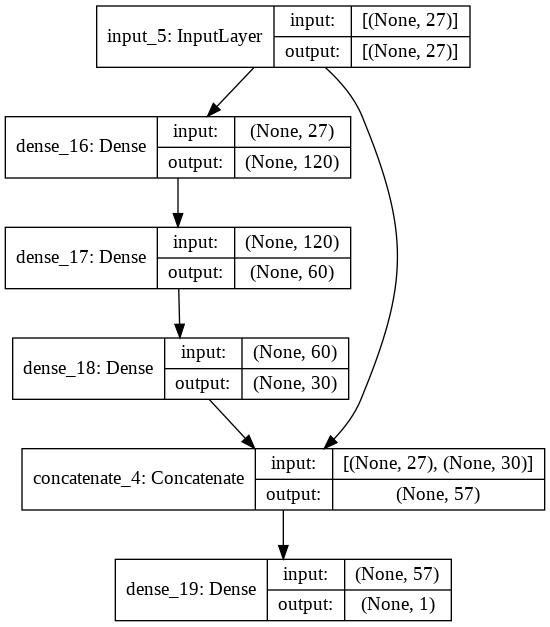

In [ ]:
# print('NN with Deep and Wide structure:')
# plot_model(nnModel_s_hour, 'OutData2/NN_Model_speed_hour.png', show_shapes = True)

In [ ]:
# # compute validation error
# # build the NN model for validation
# n_input = X_trainMain.shape[1:]
# nnValidModel = NNModel(n_input)

# # prepare the validation set
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainMain, Y_trainMain, test_size=0.2, random_state=1)
# # model training
# history = nnValidModel.fit(X_train, Y_train, epochs=20, verbose=1, validation_data=(X_valid, Y_valid))

Epoch 1/20
715/715 [==============================] - 2s 2ms/step - loss: 500901.7693 - mean_absolute_percentage_error: 74.0935 - val_loss: 29676.0352 - val_mean_absolute_percentage_error: 27.9873
Epoch 2/20
715/715 [==============================] - 1s 2ms/step - loss: 25959.3089 - mean_absolute_percentage_error: 25.6284 - val_loss: 14598.2695 - val_mean_absolute_percentage_error: 18.2483
Epoch 3/20
715/715 [==============================] - 1s 2ms/step - loss: 13649.9059 - mean_absolute_percentage_error: 16.6080 - val_loss: 10395.6152 - val_mean_absolute_percentage_error: 13.9382
Epoch 4/20
715/715 [==============================] - 1s 2ms/step - loss: 10650.8666 - mean_absolute_percentage_error: 13.6133 - val_loss: 9552.3232 - val_mean_absolute_percentage_error: 12.4088
Epoch 5/20
715/715 [==============================] - 1s 2ms/step - loss: 9725.4766 - mean_absolute_percentage_error: 12.1623 - val_loss: 8928.1982 - val_mean_absolute_percentage_error: 11.6562
Epoch 6/20
715/715 [==

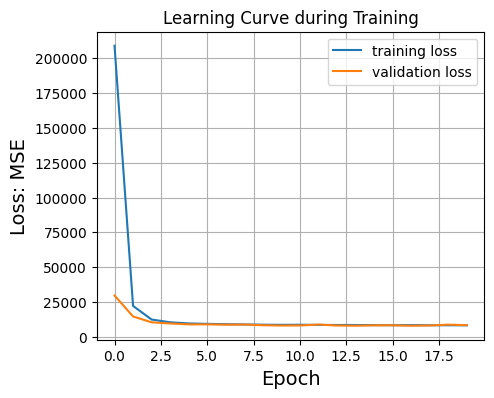

In [ ]:
# # plot loss and accuracy history
# plt.figure(figsize=(5, 4))
# plt.style.use('default')
# plt.plot(history.history['loss'], label='training loss')
# plt.plot(history.history['val_loss'], label='validation loss')
# plt.xlabel("Epoch", size=14)
# plt.ylabel("Loss: MSE", size=14)
# plt.title('Learning Curve during Training')
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# # model training
# history = nnModel_s_hour.fit(X_trainMain, Y_trainMain, epochs=20, verbose=1)

Epoch 1/20
893/893 [==============================] - 2s 2ms/step - loss: 432744.9589 - mean_absolute_percentage_error: 69.5400
Epoch 2/20
893/893 [==============================] - 1s 2ms/step - loss: 19031.8195 - mean_absolute_percentage_error: 20.3910
Epoch 3/20
893/893 [==============================] - 1s 2ms/step - loss: 11315.3900 - mean_absolute_percentage_error: 14.8627
Epoch 4/20
893/893 [==============================] - 2s 2ms/step - loss: 9871.1735 - mean_absolute_percentage_error: 12.2750
Epoch 5/20
893/893 [==============================] - 1s 2ms/step - loss: 9047.9232 - mean_absolute_percentage_error: 11.3414
Epoch 6/20
893/893 [==============================] - 2s 2ms/step - loss: 8770.7101 - mean_absolute_percentage_error: 10.8495
Epoch 7/20
893/893 [==============================] - 2s 2ms/step - loss: 8911.4503 - mean_absolute_percentage_error: 11.0297
Epoch 8/20
893/893 [==============================] - 1s 2ms/step - loss: 8761.6979 - mean_absolute_percentage_err

In [ ]:
# load pre-trained model
nnModel_s_hour = keras.models.load_model('/content/gdrive/My Drive/degree_project/models/nnModel_temporal_speed/historical_scaler.h5')

In [ ]:
# evaluate training error
Y_predict_trainMain = nnModel_s_hour.predict(X_trainMain)

# evaluate training error
print("temporal NN-model(speed) training error: ")
display_error(Y_trainMain, Y_predict_trainMain, mape)
print()

# evaluate test error (same segment)
Y_predict_testMain = nnModel_s_hour.predict(X_testMain)
mainMAPEs.append(mape(Y_testMain, Y_predict_testMain))
mainRMSEs.append(mean_squared_error(Y_testMain, Y_predict_testMain, squared=False))
print('temporal NN-model(speed) test error (same road segment):')
display_error(Y_testMain, Y_predict_testMain, mape)
print()

# evaluate training error (neighbor segment)
Y_predict_trainNeighbor = nnModel_s_hour.predict(X_trainNeighbor)
print('temporal NN-model(speed) training error (neighbor road segment):')
display_error(Y_trainNeighbor, Y_predict_trainNeighbor, mape)
print()

# evaluate test error (neighbor segment)
Y_predict_testNeighbor = nnModel_s_hour.predict(X_testNeighbor)
neighborMAPEs.append(mape(Y_testNeighbor, Y_predict_testNeighbor))
neighborRMSEs.append(mean_squared_error(Y_testNeighbor, Y_predict_testNeighbor, squared=False))
print('temporal NN-model(speed) test error (neighbor road segment):')
display_error(Y_testNeighbor, Y_predict_testNeighbor, mape)



temporal NN-model(speed) training error: 
RMSE:  92.4
MAPE:  11.5 %
r2:  0.968

temporal NN-model(speed) test error (same road segment):
RMSE:  96.8
MAPE:  11.5 %
r2:  0.964

temporal NN-model(speed) training error (neighbor road segment):
RMSE:  111.3
MAPE:  14.3 %
r2:  0.949

temporal NN-model(speed) test error (neighbor road segment):
RMSE:  120.0
MAPE:  14.4 %
r2:  0.940


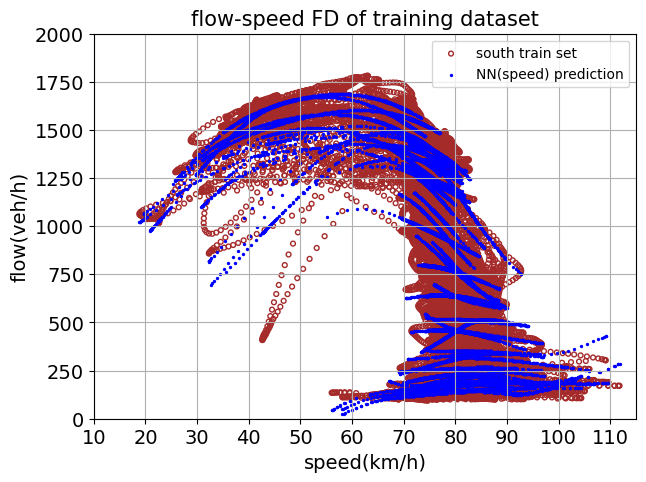

In [ ]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotFD(trainMain[['speed_inrix']], Y_trainMain, Y_predict_trainMain,
                  MAIN + ' train set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of training dataset', 'best')

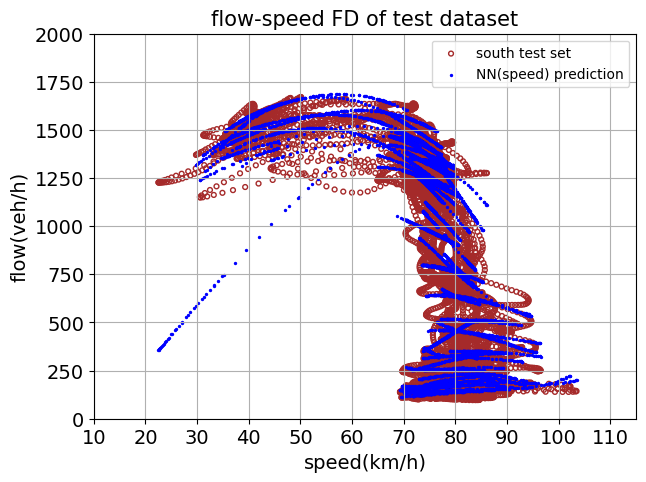

In [ ]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotFD(testMain[['speed_inrix']], Y_testMain, Y_predict_testMain,
                  MAIN + ' test set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

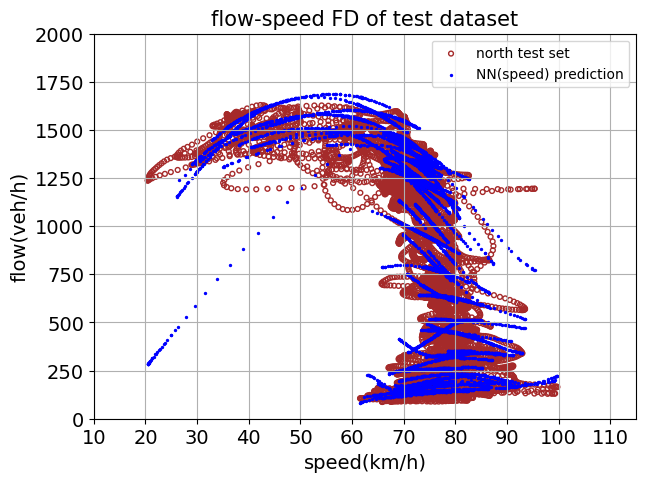

In [ ]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotFD(testNeighbor[['speed_inrix']], Y_testNeighbor, Y_predict_testNeighbor,
                  NEIGHBOR + ' test set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

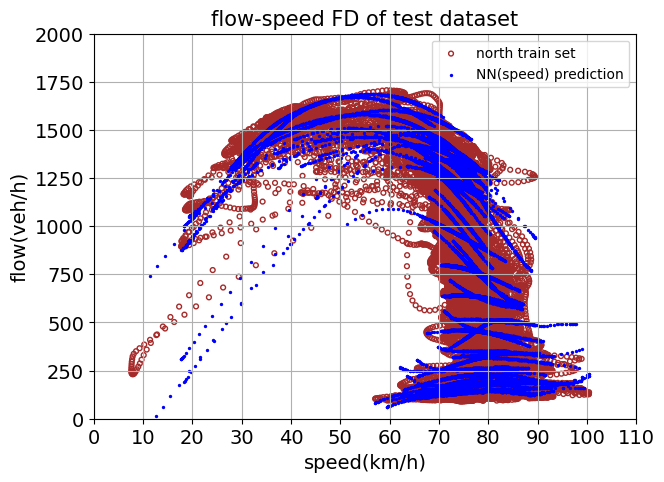

In [ ]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 0, right = 110)
x_ticks = np.arange(0, 116, 10)
plt.xticks(x_ticks)
plotFD(trainNeighbor[['speed_inrix']], Y_trainNeighbor, Y_predict_trainNeighbor,
                  NEIGHBOR + ' train set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

In [ ]:
# # save the model
# model_version = MODEL_VERSION + ".h5"
# model_name = "nnModel_temporal_speed"
# model_path = os.path.join(root_path, 'models', model_name, model_version)
# print(model_path)

In [ ]:
# # save the NN model to the model_path
# nnModel_s_hour.save(model_path)

## 6.6 NN with 2 features + temporal features: Speed, Travel Time

In [ ]:
# prepare the feature vector, label vector for training set (Main)
Epoch_trainMain = trainMain['Epoch_mcs'].values
X_trainMain = trainMain[['speed_inrix', 'travel_time_secs']].values
X_trainMain_temporalHour = trainMain[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                                  '10', '11', '12', '13', '14', '15', '16', '17',
                                  '18', '19', '20', '21', '22', '23', 'weekday', 'weekend']].values
Y_trainMain = trainMain['flow'].values.reshape(-1, 1)

 # prepare the feature vector, label vector for test set (Main)
Epoch_testMain = testMain['Epoch_mcs'].values
X_testMain = testMain[['speed_inrix', 'travel_time_secs']].values
X_testMain_temporalHour = testMain[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                                  '10', '11', '12', '13', '14', '15', '16', '17',
                                  '18', '19', '20', '21', '22', '23', 'weekday', 'weekend']].values
Y_testMain = testMain['flow'].values.reshape(-1,1)

# prepare the feature vector, label vector for training set (neighbor)
Epoch_trainNeighbor = trainNeighbor['Epoch_mcs'].values
X_trainNeighbor = trainNeighbor[['speed_inrix', 'travel_time_secs']]
X_trainNeighbor_temporalHour = trainNeighbor[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                                  '10', '11', '12', '13', '14', '15', '16', '17',
                                  '18', '19', '20', '21', '22', '23', 'weekday', 'weekend']].values
Y_trainNeighbor = trainNeighbor['flow'].values.reshape(-1, 1)

# prepare the feature vector, label vector for test set (neighbor)
Epoch_testNeighbor = testNeighbor['Epoch_mcs'].values
X_testNeighbor = testNeighbor[['speed_inrix', 'travel_time_secs']]
X_testNeighbor_temporalHour = testNeighbor[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                                  '10', '11', '12', '13', '14', '15', '16', '17',
                                  '18', '19', '20', '21', '22', '23', 'weekday', 'weekend']].values
Y_testNeighbor = testNeighbor['flow'].values.reshape(-1,1)

In [ ]:
# normalize the training/testing feature vectors + append the temporal factor:
# North training
X_trainMain, scaler_trainMain = normalize_nobias(X_trainMain)
X_trainMain = np.append(X_trainMain, X_trainMain_temporalHour, axis=1)

# South training
X_trainNeighbor, scaler_trainNeighbor = normalize_nobias(X_trainNeighbor)
X_trainNeighbor = np.append(X_trainNeighbor, X_trainNeighbor_temporalHour, axis=1)

if HISTORICALSTANDAR == True:
# North test
  X_testMain, scaler_testMain = normalize_nobias(X_testMain, scaler_trainMain)
  X_testMain = np.append(X_testMain, X_testMain_temporalHour, axis=1)

# south test
  X_testNeighbor, scaler_testNeighbor = normalize_nobias(X_testNeighbor, scaler_trainNeighbor)
  X_testNeighbor = np.append(X_testNeighbor, X_testNeighbor_temporalHour, axis=1)
else:
  # North test
  X_testMain, scaler_testMain = normalize_nobias(X_testMain)
  X_testMain = np.append(X_testMain, X_testMain_temporalHour, axis=1)

# south test
  X_testNeighbor, scaler_testNeighbor = normalize_nobias(X_testNeighbor)
  X_testNeighbor = np.append(X_testNeighbor, X_testNeighbor_temporalHour, axis=1)



In [ ]:
# # build the NN model with 1-dimensional input vector:
# n_input = X_trainMain.shape[1:]
# nnModel_st_hour = NNModel(n_input)

# # display the model
# nnModel_st_hour.summary()

Model: "NN_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28)]         0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 120)          3480        input_7[0][0]                    
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 60)           7260        dense_24[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 30)           1830        dense_25[0][0]                   
___________________________________________________________________________________________

NN with Deep and Wide structure:


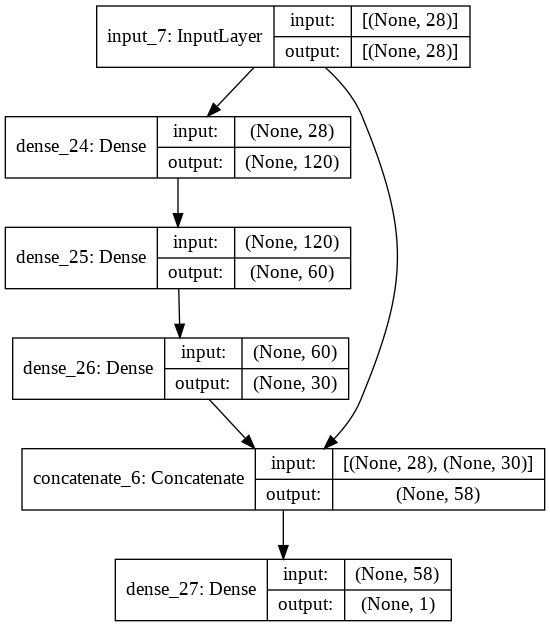

In [ ]:
# print('NN with Deep and Wide structure:')
# plot_model(nnModel_st_hour, 'OutData2/NN_Model_speed_travel_hour.png', show_shapes = True)

In [ ]:
# # compute validation error
# # build the NN model for validation
# n_input = X_trainMain.shape[1:]
# nnValidModel_st = NNModel(n_input)

# # prepare the validation set
# X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainMain, Y_trainMain, test_size=0.2, random_state=1)
# # model training
# history = nnValidModel_st.fit(X_train, Y_train, epochs=20, verbose=1, validation_data=(X_valid, Y_valid))

Epoch 1/20
715/715 [==============================] - 2s 2ms/step - loss: 533195.7966 - mean_absolute_percentage_error: 74.7801 - val_loss: 27912.1992 - val_mean_absolute_percentage_error: 29.4380
Epoch 2/20
715/715 [==============================] - 1s 2ms/step - loss: 23486.3183 - mean_absolute_percentage_error: 25.0673 - val_loss: 13354.9482 - val_mean_absolute_percentage_error: 17.2297
Epoch 3/20
715/715 [==============================] - 1s 2ms/step - loss: 12866.4563 - mean_absolute_percentage_error: 16.0292 - val_loss: 10397.6641 - val_mean_absolute_percentage_error: 14.4263
Epoch 4/20
715/715 [==============================] - 1s 2ms/step - loss: 10668.5664 - mean_absolute_percentage_error: 13.5672 - val_loss: 9633.2617 - val_mean_absolute_percentage_error: 12.5345
Epoch 5/20
715/715 [==============================] - 1s 2ms/step - loss: 9866.6810 - mean_absolute_percentage_error: 12.3650 - val_loss: 9249.2412 - val_mean_absolute_percentage_error: 12.6278
Epoch 6/20
715/715 [==

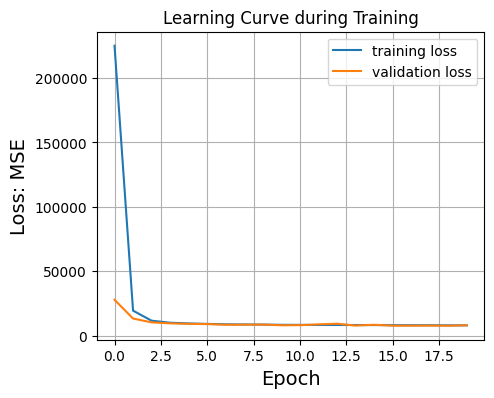

In [ ]:
# # plot loss and accuracy history
# plt.figure(figsize=(5, 4))
# plt.style.use('default')
# plt.plot(history.history['loss'], label='training loss')
# plt.plot(history.history['val_loss'], label='validation loss')
# plt.xlabel("Epoch", size=14)
# plt.ylabel("Loss: MSE", size=14)
# plt.title('Learning Curve during Training')
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# # model training
# history = nnModel_st_hour.fit(X_trainMain, Y_trainMain, epochs=20, verbose=1)

Epoch 1/20
893/893 [==============================] - 2s 1ms/step - loss: 491202.1185 - mean_absolute_percentage_error: 72.3788
Epoch 2/20
893/893 [==============================] - 1s 2ms/step - loss: 22437.5861 - mean_absolute_percentage_error: 25.0972
Epoch 3/20
893/893 [==============================] - 1s 2ms/step - loss: 12189.1369 - mean_absolute_percentage_error: 16.0097
Epoch 4/20
893/893 [==============================] - 1s 1ms/step - loss: 9983.2491 - mean_absolute_percentage_error: 13.4617
Epoch 5/20
893/893 [==============================] - 1s 1ms/step - loss: 9210.8853 - mean_absolute_percentage_error: 11.5097
Epoch 6/20
893/893 [==============================] - 1s 1ms/step - loss: 9202.2748 - mean_absolute_percentage_error: 11.1629
Epoch 7/20
893/893 [==============================] - 1s 2ms/step - loss: 9054.0258 - mean_absolute_percentage_error: 11.0480
Epoch 8/20
893/893 [==============================] - 1s 1ms/step - loss: 8628.8330 - mean_absolute_percentage_err

In [ ]:
# load pre-trained model
nnModel_st_hour = keras.models.load_model('/content/gdrive/My Drive/degree_project/models/nnModel_temporal_speed_travelTime/historical_scaler.h5')

In [ ]:
# evaluate training error
Y_predict_trainMain = nnModel_st_hour.predict(X_trainMain)

# evaluate training error
print("temporal-model(speed, travel time) training error: ")
display_error(Y_trainMain, Y_predict_trainMain, mape)
print()

# evaluate test error (same segment)
Y_predict_testMain = nnModel_st_hour.predict(X_testMain)
mainMAPEs.append(mape(Y_testMain, Y_predict_testMain))
mainRMSEs.append(mean_squared_error(Y_testMain, Y_predict_testMain, squared=False))
print('temporal-model(speed, travel time) test error (same road segment):')
display_error(Y_testMain, Y_predict_testMain, mape)
print()

# evaluate training error (neighbor segment)
Y_predict_trainNeighbor = nnModel_st_hour.predict(X_trainNeighbor)
print('temporal-model(speed, travel time) training error (neighbor road segment):')
display_error(Y_trainNeighbor, Y_predict_trainNeighbor, mape)
print()

# evaluate test error (neighbor segment)
Y_predict_testNeighbor = nnModel_st_hour.predict(X_testNeighbor)
neighborMAPEs.append(mape(Y_testNeighbor, Y_predict_testNeighbor))
neighborRMSEs.append(mean_squared_error(Y_testNeighbor, Y_predict_testNeighbor, squared=False))
print('temporal-model(speed, travel time) test error (neighbor road segment):')
display_error(Y_testNeighbor, Y_predict_testNeighbor, mape)



temporal-model(speed, travel time) training error: 
RMSE:  92.6
MAPE:  11.1 %
r2:  0.967

temporal-model(speed, travel time) test error (same road segment):
RMSE:  94.9
MAPE:  10.6 %
r2:  0.965

temporal-model(speed, travel time) training error (neighbor road segment):
RMSE:  97.8
MAPE:  12.9 %
r2:  0.961

temporal-model(speed, travel time) test error (neighbor road segment):
RMSE:  104.4
MAPE:  12.7 %
r2:  0.955


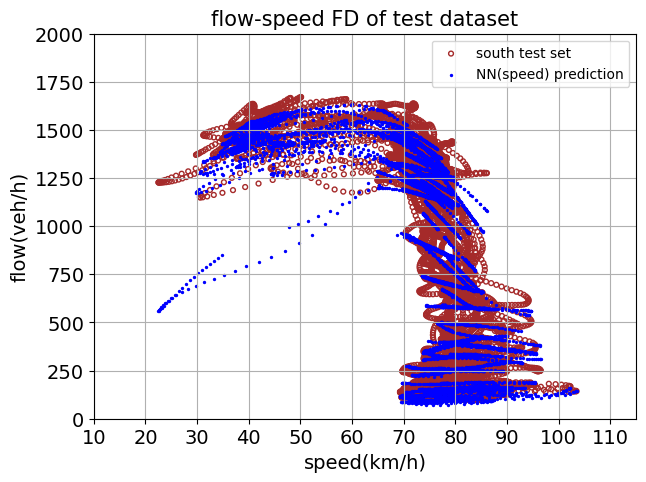

In [ ]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotFD(testMain[['speed_inrix']], Y_testMain, Y_predict_testMain,
                  MAIN + ' test set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

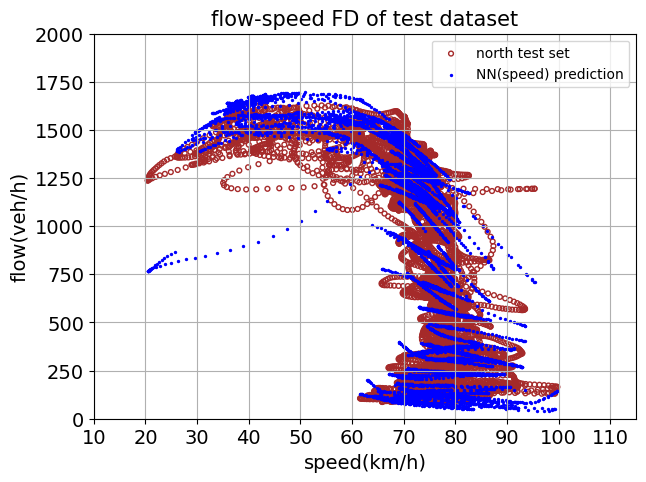

In [ ]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotFD(testNeighbor[['speed_inrix']], Y_testNeighbor, Y_predict_testNeighbor,
                  NEIGHBOR + ' test set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

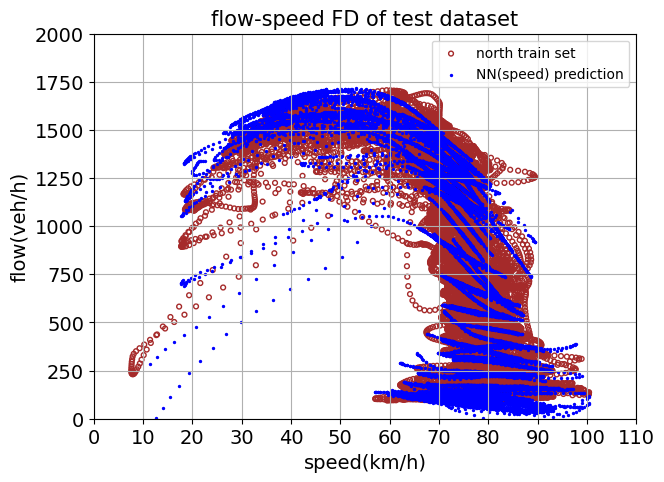

In [ ]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 0, right = 110)
x_ticks = np.arange(0, 116, 10)
plt.xticks(x_ticks)
plotFD(trainNeighbor[['speed_inrix']], Y_trainNeighbor, Y_predict_trainNeighbor,
                  NEIGHBOR + ' train set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

In [ ]:
# # save the model
# model_version = MODEL_VERSION + ".h5"
# model_name = "nnModel_temporal_speed_travelTime"
# model_path = os.path.join(root_path, 'models', model_name, model_version)
# print(model_path)

/content/gdrive/My Drive/degree_project/models/nnModel_temporal_speed_travelTime/historical_scaler.h5


In [ ]:
# # save the NN model to the model_path
# nnModel_st_hour.save(model_path)

## 6.7 NN with 1 features + temporal features + spatial feature: Speed




In [153]:
# prepare the feature vector, label vector for training set (Main)
Epoch_trainMain = trainMain['Epoch_mcs'].values
X_trainMain = trainMain[['speed_inrix']].values
X_trainMain_temporal_spatial = trainMain[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                                  '10', '11', '12', '13', '14', '15', '16', '17',
                                  '18', '19', '20', '21', '22', '23','weekday', 'weekend', 'south', 'north']].values
Y_trainMain = trainMain['flow'].values.reshape(-1, 1)

 # prepare the feature vector, label vector for test set (Main)
Epoch_testMain = testMain['Epoch_mcs'].values
X_testMain = testMain[['speed_inrix']].values
X_testMain_temporal_spatial = testMain[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                                  '10', '11', '12', '13', '14', '15', '16', '17',
                                  '18', '19', '20', '21', '22', '23', 'weekday', 'weekend', 'south', 'north']].values
Y_testMain = testMain['flow'].values.reshape(-1,1)

# prepare the feature vector, label vector for training set (neighbor)
Epoch_trainNeighbor = trainNeighbor['Epoch_mcs'].values
X_trainNeighbor = trainNeighbor[['speed_inrix']]
X_trainNeighbor_temporal_spatial = trainNeighbor[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                                  '10', '11', '12', '13', '14', '15', '16', '17',
                                  '18', '19', '20', '21', '22', '23', 'weekday', 'weekend', 'south', 'north']].values
Y_trainNeighbor = trainNeighbor['flow'].values.reshape(-1, 1)

# prepare the feature vector, label vector for test set (neighbor)
Epoch_testNeighbor = testNeighbor['Epoch_mcs'].values
X_testNeighbor = testNeighbor[['speed_inrix']]
X_testNeighbor_temporal_spatial = testNeighbor[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                                  '10', '11', '12', '13', '14', '15', '16', '17',
                                  '18', '19', '20', '21', '22', '23', 'weekday', 'weekend', 'south', 'north']].values
Y_testNeighbor = testNeighbor['flow'].values.reshape(-1,1)

In [154]:
# normalize the training/testing feature vectors + append the temporal factor:
# Main training
X_trainMain, scaler_trainMain = normalize_nobias(X_trainMain)
X_trainMain = np.append(X_trainMain, X_trainMain_temporal_spatial, axis=1)

# Neighbor training
X_trainNeighbor, scaler_trainNeighbor = normalize_nobias(X_trainNeighbor)
X_trainNeighbor = np.append(X_trainNeighbor, X_trainNeighbor_temporal_spatial, axis=1)

if HISTORICALSTANDAR == True:
  # Main test
  X_testMain, scaler_testMain = normalize_nobias(X_testMain, scaler_trainMain)
  X_testMain = np.append(X_testMain, X_testMain_temporal_spatial, axis=1)

  # Neighbor test
  X_testNeighbor, scaler_testNeighbor = normalize_nobias(X_testNeighbor, scaler_trainNeighbor)
  X_testNeighbor = np.append(X_testNeighbor, X_testNeighbor_temporal_spatial, axis=1)
else:
  # Main test
  X_testMain, scaler_testMain = normalize_nobias(X_testMain)
  X_testMain = np.append(X_testMain, X_testMain_temporal_spatial, axis=1)

  # Neighbor test
  X_testNeighbor, scaler_testNeighbor = normalize_nobias(X_testNeighbor)
  X_testNeighbor = np.append(X_testNeighbor, X_testNeighbor_temporal_spatial, axis=1)


In [155]:
# combine the south and north into the same training datasets
X_train = np.concatenate((X_trainMain, X_trainNeighbor))
Y_train = np.concatenate((Y_trainMain, Y_trainNeighbor))

In [ ]:
# # build the NN model with 1-dimensional input vector:
# n_input = X_train.shape[1:]
# nnModel_st_hour_seg = NNModel(n_input)

# # display the model
# nnModel_st_hour_seg.summary()

Model: "NN_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 29)]         0                                            
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 120)          3600        input_9[0][0]                    
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 60)           7260        dense_32[0][0]                   
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 30)           1830        dense_33[0][0]                   
___________________________________________________________________________________________

NN with Deep and Wide structure:


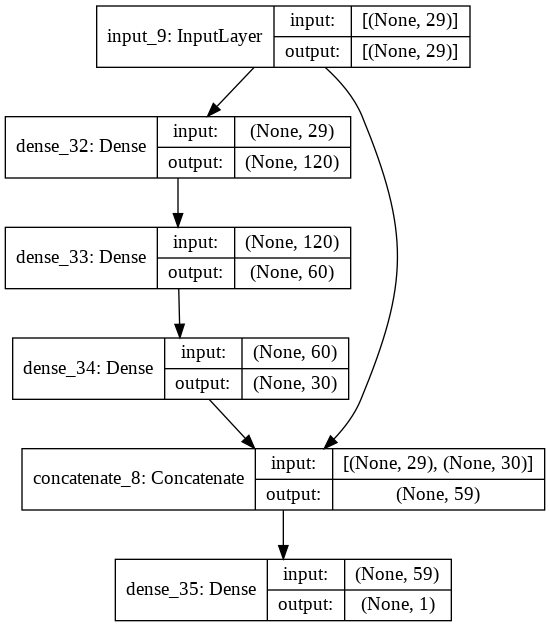

In [ ]:
# print('NN with Deep and Wide structure:')
# plot_model(nnModel_st_hour_seg, 'OutData2/NN_Model_speed_travel_hour_location.png', show_shapes = True)

In [ ]:
# # compute validation error
# # build the NN model for validation
# n_input = X_train.shape[1:]
# nnValidModel = NNModel(n_input)

# # prepare the validation set
# X_training, X_valid, Y_training, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)
# # model training
# history = nnValidModel.fit(X_training, Y_training, epochs=20, verbose=1, validation_data=(X_valid, Y_valid))

Epoch 1/20
1427/1427 [==============================] - 3s 2ms/step - loss: 308196.2939 - mean_absolute_percentage_error: 62.7807 - val_loss: 13854.8516 - val_mean_absolute_percentage_error: 17.4623
Epoch 2/20
1427/1427 [==============================] - 2s 2ms/step - loss: 12211.3307 - mean_absolute_percentage_error: 15.8166 - val_loss: 9357.3809 - val_mean_absolute_percentage_error: 11.7257
Epoch 3/20
1427/1427 [==============================] - 3s 2ms/step - loss: 9226.1858 - mean_absolute_percentage_error: 12.0065 - val_loss: 8617.7734 - val_mean_absolute_percentage_error: 10.9145
Epoch 4/20
1427/1427 [==============================] - 2s 2ms/step - loss: 8636.6508 - mean_absolute_percentage_error: 11.1659 - val_loss: 8863.4189 - val_mean_absolute_percentage_error: 11.8613
Epoch 5/20
1427/1427 [==============================] - 2s 2ms/step - loss: 8449.7760 - mean_absolute_percentage_error: 10.9911 - val_loss: 8101.8647 - val_mean_absolute_percentage_error: 10.4868
Epoch 6/20
1427/

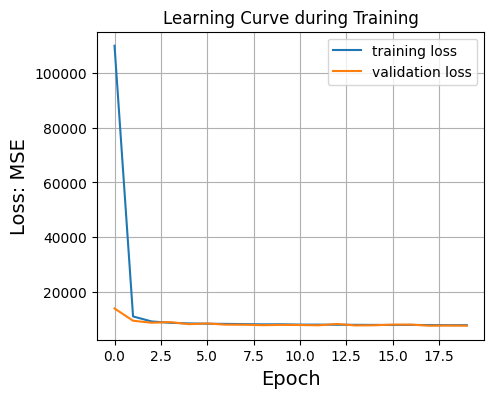

In [ ]:
# # plot loss and accuracy history
# plt.figure(figsize=(5, 4))
# plt.style.use('default')
# plt.plot(history.history['loss'], label='training loss')
# plt.plot(history.history['val_loss'], label='validation loss')
# plt.xlabel("Epoch", size=14)
# plt.ylabel("Loss: MSE", size=14)
# plt.title('Learning Curve during Training')
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# # model training
# history = nnModel_st_hour_seg.fit(X_train, Y_train, epochs=20, verbose=1)

Epoch 1/20
1784/1784 [==============================] - 3s 1ms/step - loss: 293691.4533 - mean_absolute_percentage_error: 59.9892
Epoch 2/20
1784/1784 [==============================] - 3s 1ms/step - loss: 11258.5292 - mean_absolute_percentage_error: 15.3374
Epoch 3/20
1784/1784 [==============================] - 3s 1ms/step - loss: 8871.2000 - mean_absolute_percentage_error: 11.7502
Epoch 4/20
1784/1784 [==============================] - 3s 1ms/step - loss: 8543.8688 - mean_absolute_percentage_error: 11.4024
Epoch 5/20
1784/1784 [==============================] - 3s 1ms/step - loss: 8302.7963 - mean_absolute_percentage_error: 10.9878
Epoch 6/20
1784/1784 [==============================] - 3s 1ms/step - loss: 8225.1025 - mean_absolute_percentage_error: 11.0662
Epoch 7/20
1784/1784 [==============================] - 3s 1ms/step - loss: 7910.6279 - mean_absolute_percentage_error: 10.8663
Epoch 8/20
1784/1784 [==============================] - 3s 1ms/step - loss: 7894.6132 - mean_absolute

In [156]:
# load pre-trained model
nnModel_st_hour_seg = keras.models.load_model('/content/gdrive/My Drive/degree_project/models/nnModel_temporal_spatial_speed/historical_scaler.h5')

In [157]:
# evaluate training error
Y_predict_trainMain = nnModel_st_hour_seg.predict(X_trainMain)

# evaluate training error
print("NN-model(speed, travel time) training error: ")
display_error(Y_trainMain, Y_predict_trainMain, mape)
print()

# evaluate test error (same segment)
Y_predict_testMain = nnModel_st_hour_seg.predict(X_testMain)
mainMAPEs.append(mape(Y_testMain, Y_predict_testMain))
mainRMSEs.append(mean_squared_error(Y_testMain, Y_predict_testMain, squared=False))
print('NN-model(speed, travel time) test error (same road segment):')
display_error(Y_testMain, Y_predict_testMain, mape)
print()

# evaluate training error (neighbor segment)
Y_predict_trainNeighbor = nnModel_st_hour_seg.predict(X_trainNeighbor)
print('NN-model(speed, travel time) training error (neighbor road segment):')
display_error(Y_trainNeighbor, Y_predict_trainNeighbor, mape)
print()

# evaluate test error (neighbor segment)
Y_predict_testNeighbor = nnModel_st_hour_seg.predict(X_testNeighbor)
neighborMAPEs.append(mape(Y_testNeighbor, Y_predict_testNeighbor))
neighborRMSEs.append(mean_squared_error(Y_testNeighbor, Y_predict_testNeighbor, squared=False))
print('NN-model(speed, travel time) test error (neighbor road segment):')
display_error(Y_testNeighbor, Y_predict_testNeighbor, mape)



NN-model(speed, travel time) training error: 
RMSE:  88.6
MAPE:  10.3 %
r2:  0.970

NN-model(speed, travel time) test error (same road segment):
RMSE:  88.3
MAPE:  10.0 %
r2:  0.970

NN-model(speed, travel time) training error (neighbor road segment):
RMSE:  83.9
MAPE:  10.2 %
r2:  0.971

NN-model(speed, travel time) test error (neighbor road segment):
RMSE:  87.7
MAPE:  10.7 %
r2:  0.968


In [160]:
X_trainMain.shape
print(X_trainMain[:,0])

[-0.06320653 -0.13143732 -0.18854352 ...  0.9665592   0.94171429
  0.91649857]


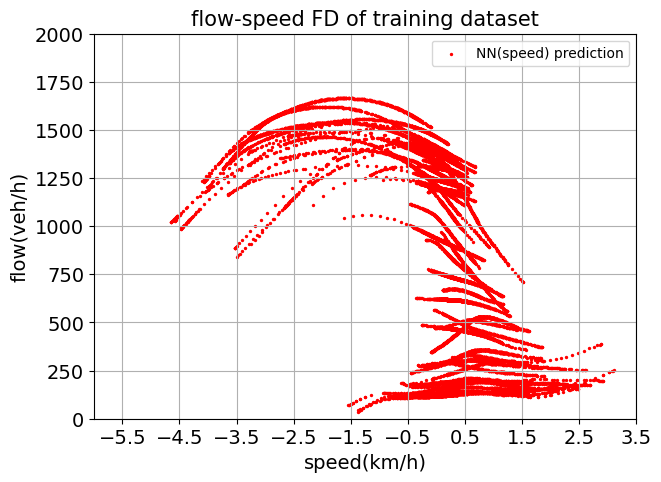

In [172]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left=-6.0, right=3.5)
x_ticks = np.arange(-5.5, 3.6, 1.0)
plt.xticks(x_ticks)
plotFD(X_trainMain[:,0], Y_trainMain, Y_predict_trainMain,
                  MAIN + ' train set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of training dataset', 'best')

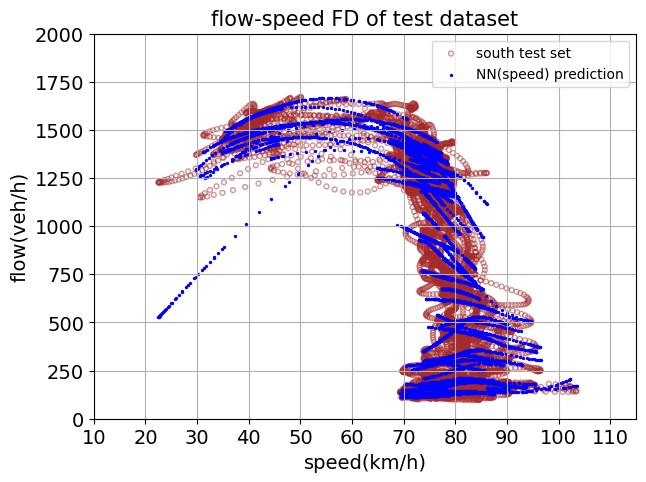

In [163]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotFD(testMain[['speed_inrix']], Y_testMain, Y_predict_testMain,
                  MAIN + ' test set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

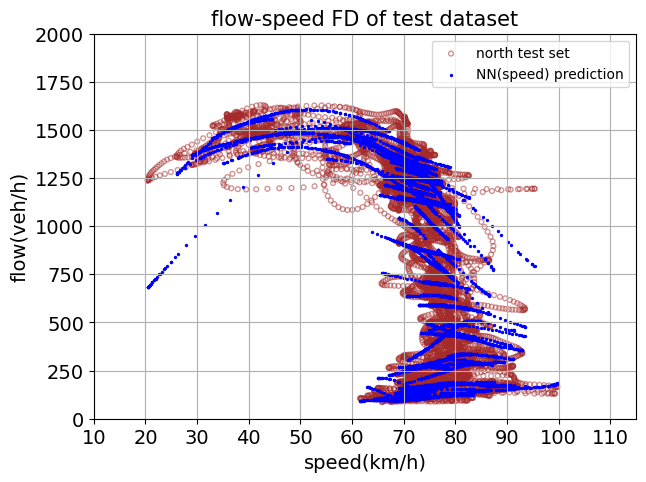

In [164]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left = 10, right = 115)
x_ticks = np.arange(10, 116, 10)
plt.xticks(x_ticks)
plotFD(testNeighbor[['speed_inrix']], Y_testNeighbor, Y_predict_testNeighbor,
                  NEIGHBOR + ' test set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

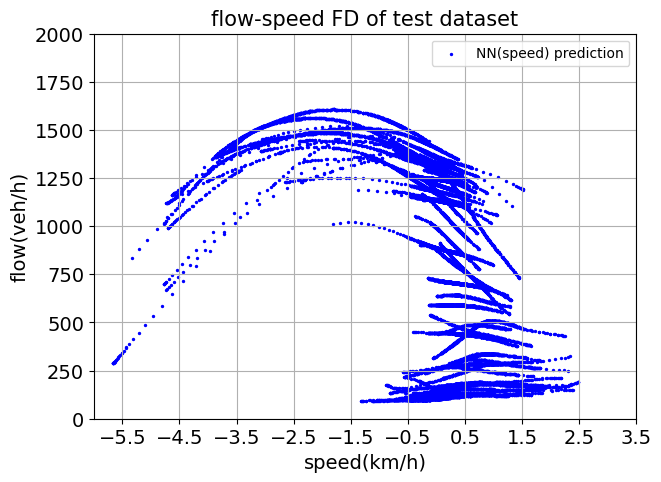

In [170]:
plt.figure(figsize=(7,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
plt.xlim(left=-6.0, right=3.5)
x_ticks = np.arange(-5.5, 3.6, 1.0)
plt.xticks(x_ticks)
plotFD(X_trainNeighbor[:,0], Y_trainNeighbor, Y_predict_trainNeighbor,
                  NEIGHBOR + ' train set', 'NN(speed) prediction', 'speed(km/h)', 'flow(veh/h)',
                   'flow-speed FD of test dataset', 'best')

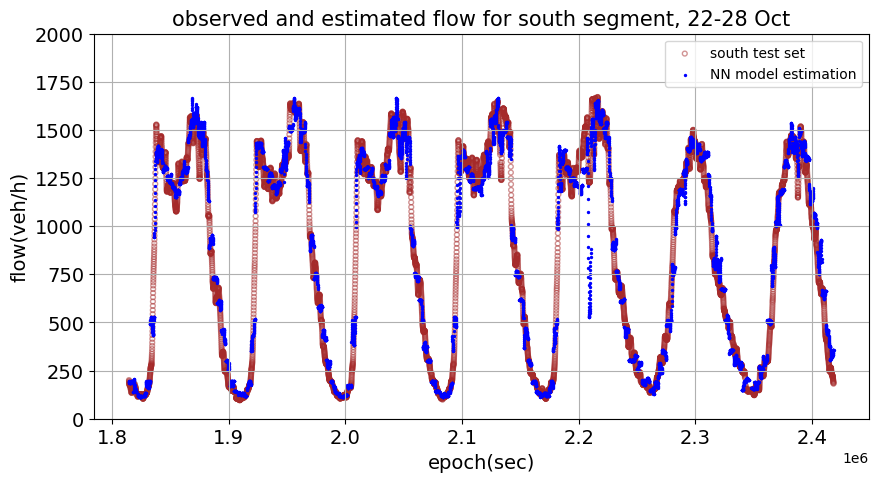

In [128]:

# plot the prediction and instance of the the test dataset (same segment)
plt.figure(figsize=(10,5))
plt.style.use('default')
plt.ylim(bottom = 0, top = 2000)
# plt.xlim(left = 0, right = 110)
# x_ticks = np.arange(0, 116, 10)
# plt.xticks(x_ticks)
plotFD(Epoch_testMain, Y_testMain, Y_predict_testMain,
                  MAIN + ' test set', 'NN model estimation', 'epoch(sec)', 'flow(veh/h)',
                   'observed and estimated flow for south segment, 22-28 Oct', 'best')

In [129]:
# # save the model
# model_version = MODEL_VERSION + ".h5"
# model_name = "nnModel_temporal_spatial_speed"
# model_path = os.path.join(root_path, 'models', model_name, model_version)
# print(model_path)

In [130]:
# # save the NN model to the model_path
# nnModel_st_hour_seg.save(model_path)

# <em>Part IV. Result Analysis</em>
This part aims to explain and visualize the results from Part II and Part III
1. plot the distribution of speed in a. main training set, b. main test set, and c. neighbor test set
  * boxplot: raw, normalized plots<br>
  (* distribution plot: test Main-neighbor raw/normalized plots)
2. plot the performance of each model
  * barchart: MAPE (test Main/Neighbor in one figure)

## 7.1 Distributions of INRIX speed in training and test sets

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


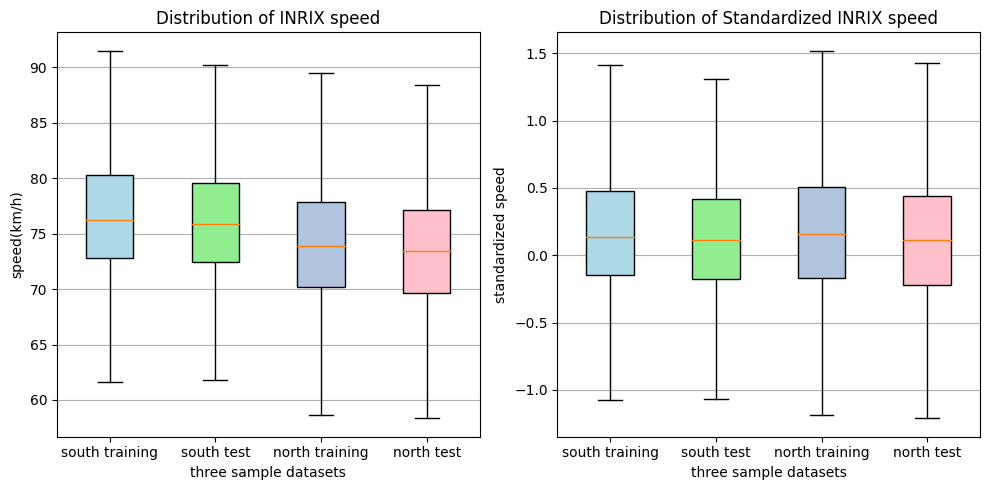

In [ ]:
# plot the boxplot of raw/normalized INRIX speed for main training/test sets and neighbor test set
# prepare the train/test speed dataset
X_trainMain = trainMain[['speed_inrix']].values
X_testMain = testMain[['speed_inrix']].values
X_trainNeighbor = trainNeighbor[['speed_inrix']].values
X_testNeighbor = testNeighbor[['speed_inrix']].values
all_inputs = [X_trainMain, X_testMain, X_trainNeighbor, X_testNeighbor]
# all_inputs = [X_trainMain, X_testMain, X_testNeighbor]

X_trainMain_standard, scaler_trainMain = normalize_nobias(X_trainMain)
X_testMain_standard, scaler_testMain = normalize_nobias(X_testMain, scaler_trainMain)
X_trainNeighbor_standard, scaler_trainNeighbor = normalize_nobias(X_trainNeighbor)
X_testNeighbor_standard, scaler_testNeighbor = normalize_nobias(X_testNeighbor, scaler_trainNeighbor)
all_standardized_inputs = [X_trainMain_standard, X_testMain_standard, X_trainNeighbor_standard, X_testNeighbor_standard]
# all_standardized_inputs = [X_trainMain_standard, X_testMain_standard, X_testNeighbor_standard]



labels = [MAIN+ ' training', MAIN + ' test', NEIGHBOR + ' training', NEIGHBOR + ' test' ]
# labels = [MAIN+ ' training', MAIN + ' test', NEIGHBOR + ' test' ]


# plot the 2 boxplot in a fiugre
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, tight_layout=True, figsize=(10, 5))


# raw speed box plot
bplot1 = ax1.boxplot(all_inputs,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels,
                     showfliers=False)  # will be used to label x-ticks
ax1.set_title('Distribution of INRIX speed')

# standardized speed box plot
bplot2 = ax2.boxplot(all_standardized_inputs,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels,
                     showfliers=False)  # will be used to label x-ticks
ax2.set_title('Distribution of Standardized INRIX speed')

# fill with colors
colors = ['lightblue', 'lightgreen', 'lightsteelblue', 'pink']
# colors = ['lightblue', 'lightgreen', 'pink']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# set grids and labels
yLabels = ['speed(km/h)', 'standardized speed']
for ax, yLabel in zip([ax1, ax2], yLabels) :
  ax.yaxis.grid(True)
  ax.set_xlabel('three sample datasets')
  ax.set_ylabel(yLabel)

plt.style.use('default')
plt.show()



In [ ]:
# show the median of each train and test set:
print(MAIN, 'train median speed: ', np.median(X_trainMain))
print(MAIN, 'test median speed: ', np.median(X_testMain))
print(NEIGHBOR, 'train median speed: ', np.median(X_trainNeighbor))
print(NEIGHBOR, 'test median speed: ', np.median(X_testNeighbor))


south train median speed:  76.21333333333334
south test median speed:  75.91555555555554
north train median speed:  73.92
north test median speed:  73.47555555555554


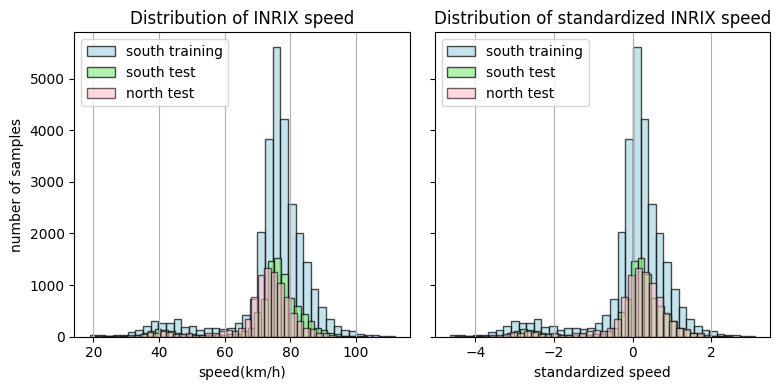

In [ ]:
# plot the distribution histogram of the speed for 3 datasets
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, tight_layout=True, figsize=(8, 4))
ax1.hist(X_trainMain, bins=40, color='lightblue', alpha=0.7, edgecolor='black', label=MAIN + ' training')
ax1.hist(X_testMain, bins=40, color='lightgreen', alpha=0.7, edgecolor='black', label=MAIN + ' test')
ax1.hist(X_testNeighbor, bins=40, color='pink', alpha=0.6, edgecolor='black', label=NEIGHBOR+' test')
ax1.xaxis.grid(True)
ax1.set_xlabel('speed(km/h)')
ax1.set_ylabel('number of samples')
ax1.set_title('Distribution of INRIX speed')
# ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax1.legend()

ax2.hist(X_trainMain_standard, bins=40, color='lightblue', alpha=0.7, edgecolor='black', label=MAIN + ' training')
ax2.hist(X_testMain_standard, bins=40, color='lightgreen', alpha=0.7, edgecolor='black', label=MAIN + ' test')
ax2.hist(X_testNeighbor_standard, bins=40, color='pink', alpha=0.6, edgecolor='black', label = NEIGHBOR+' test')
ax2.xaxis.grid(True)
ax2.set_xlabel('standardized speed')
ax2.set_title('Distribution of standardized INRIX speed')
# ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax2.legend()



## 7.2 Visualize estimation error of each model

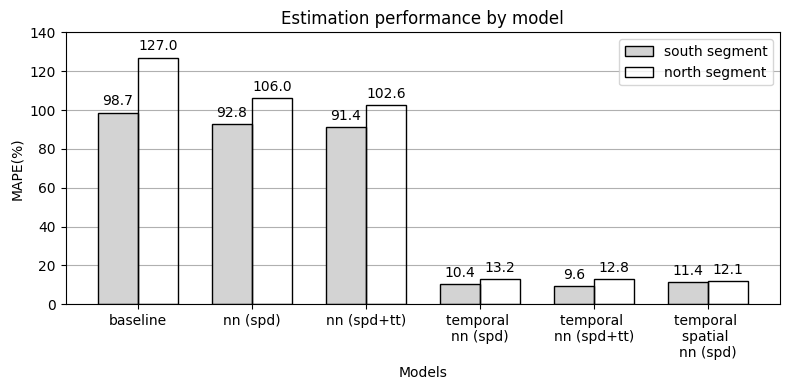

In [ ]:
# draw estiamtion performance on test sets (mape) of every model

labels = ['baseline', 'nn (spd)', 'nn (spd+tt)', 'temporal \nnn (spd)', 'temporal \nnn (spd+tt)',
          'temporal \nspatial \nnn (spd)']

x = np.arange(len(labels)) * 1  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,4))
rects1 = ax.bar(x - width/2, mainMAPEs, width, label='south segment', zorder=2, 
                color='lightgrey', edgecolor='black')
rects2 = ax.bar(x + width/2, neighborMAPEs, width, label='north segment', zorder=2,
                color='none', edgecolor='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAPE(%)')
ax.set_xlabel('Models')
ax.set_title('Estimation performance by model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(top=140)
ax.yaxis.grid(True)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        # print(type(height))
        ax.annotate('{0:0.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


In [ ]:
# calculate the improvemnt of accuracy compared with baseline model
mainImprov = []
neighborImprov = []

for mape in mainMAPEs:
  mainImprov.append(100 * (mape - mainMAPEs[0])/mainMAPEs[0])

for mape in neighborMAPEs:
  neighborImprov.append(100 * (mape - neighborMAPEs[0])/neighborMAPEs[0])  

print('main segment mapes improvment:')
for improv in mainImprov:
  print('%.2f'%improv, '%') 

print('neighbor segment mapes improvment:')
for improvN in neighborImprov:
  print('%.2f'%improvN, '%')


main segment mapes improvment:
0.00 %
-6.45 %
-7.14 %
-88.31 %
-89.29 %
-89.82 %
neighbor segment mapes improvment:
0.00 %
-16.49 %
-18.25 %
-88.66 %
-89.97 %
-91.54 %


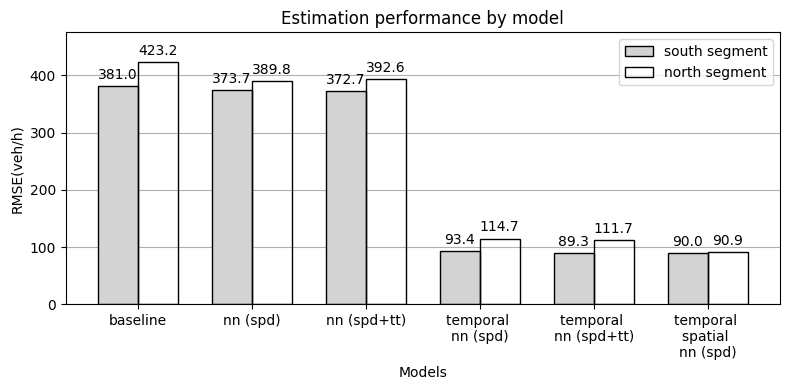

In [ ]:
# draw estiamtion performance on test sets (mape) of every model

labels = ['baseline', 'nn (spd)', 'nn (spd+tt)', 'temporal \nnn (spd)', 'temporal \nnn (spd+tt)',
          'temporal \nspatial \nnn (spd)']

x = np.arange(len(labels)) * 1  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,4))
rects1 = ax.bar(x - width/2, mainRMSEs, width, label='south segment', zorder=2, 
                color='lightgrey', edgecolor='black')
rects2 = ax.bar(x + width/2, neighborRMSEs, width, label='north segment', zorder=2,
                color='none', edgecolor='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE(veh/h)')
ax.set_xlabel('Models')
ax.set_title('Estimation performance by model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(top=475)
ax.yaxis.grid(True)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        # print(type(height))
        ax.annotate('{0:0.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


In [ ]:
# show the rmses on test sets for 2 road segments
print('main segment rmses:')
for rmse in mainRMSEs:
  print('%.1f'%rmse) 

print('neighbor segment rmses:')
for rmse in neighborRMSEs:
  print('%.1f'%rmse)

main segment rmses:
381.0
373.6
372.8
96.8
94.9
88.3
neighbor segment rmses:
423.2
391.5
398.0
120.0
104.4
87.7


In [ ]:
# calculate the improvemnt of accuracy compared with baseline model
mainImprovRMSE = []
neighborImprovRMSE = []

for rmse in mainRMSEs:
  mainImprovRMSE.append(100 * (rmse - mainRMSEs[0])/mainRMSEs[0])

for rmse in neighborRMSEs:
  neighborImprovRMSE.append(100 * (rmse - neighborRMSEs[0])/neighborRMSEs[0])  


print('main segment rmses improvment:')
for improvRmse in mainImprovRMSE:
  print('%.2f'%improvRmse, '%') 

print('neighbor segment rmses improvment:')
for improvNeighborRmse in neighborImprovRMSE:
  print('%.2f'%improvNeighborRmse, '%')



main segment rmses improvment:
0.00 %
-1.95 %
-2.14 %
-74.59 %
-75.09 %
-76.81 %
neighbor segment rmses improvment:
0.00 %
-7.47 %
-5.95 %
-71.64 %
-75.34 %
-79.27 %


# <em>Part V. Deploy the NN model on the Google Cloud Server(GCP)</em>
* Part V of the notebook aims to deploy the final estimation model as a RESTful API service on the cloud. (FaaS: function as a service)

## 1. Save the Model
* Save the model as a TF model in a local directory (on Google drive)
* Testing: re-load the tf saved-model and examine the estimation result by using it

In [ ]:
model_version = "0001"
model_name = "NN_2featrue_temporal_1link"
model_path = os.path.join(root_path, 'Models', model_name, model_version)
print(model_path)

/content/gdrive/My Drive/degree_project/Models/NN_2featrue_temporal_1link/0001


In [ ]:
# save the NN model to the model_path
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/degree_project/Models/NN_2featrue_temporal_1link/0001/assets


In [ ]:
# prepare the input tensor from X_future test set
input_tensor = tf.convert_to_tensor(X_future, dtype=tf.float32)

# check input tensor
print(input_tensor)

# check original input np array
print(X_future)

tf.Tensor(
[[ 0.48058987 -0.41952986  0.         ...  0.          0.
   1.        ]
 [ 0.45822883 -0.41014808  0.         ...  0.          0.
   1.        ]
 [ 0.43586776 -0.4007663   0.         ...  0.          0.
   1.        ]
 ...
 [ 0.8355716  -0.6022275   0.         ...  0.          1.
   0.        ]
 [ 0.82159597 -0.5959318   0.         ...  0.          1.
   0.        ]
 [ 0.8160057  -0.5933395   0.         ...  0.          1.
   0.        ]], shape=(8007, 7), dtype=float32)
[[ 0.48058987 -0.41952984  0.         ...  0.          0.
   1.        ]
 [ 0.45822881 -0.41014807  0.         ...  0.          0.
   1.        ]
 [ 0.43586776 -0.4007663   0.         ...  0.          0.
   1.        ]
 ...
 [ 0.8355716  -0.60222752  0.         ...  0.          1.
   0.        ]
 [ 0.82159594 -0.59593185  0.         ...  0.          1.
   0.        ]
 [ 0.81600568 -0.59333952  0.         ...  0.          1.
   0.        ]]


In [ ]:
# reload the model from file saved_model.pb in the directory
saved_model = tf.saved_model.load(model_path)

# use the reloaded model to estimate the flow
# input: Tensor shape=(None, 7)
# output: Tensor, shape = (None, 1)
y_predict_savedModel = saved_model(input_tensor, training = False)

In [ ]:
# compare the estimate result from saved-model with the keras model
print('first 20 estimation results from saved model:')
print(y_predict_savedModel[:20])

print('first 20 estimation results from keras model:')
print(y_future_predict[:20].round(3))

first 20 estimation results from saved model:
tf.Tensor(
[[241.17204]
 [239.64032]
 [238.10864]
 [234.74352]
 [231.37846]
 [228.47246]
 [225.8652 ]
 [223.25795]
 [220.65068]
 [220.41714]
 [220.1836 ]
 [219.95003]
 [239.42879]
 [240.88727]
 [246.74539]
 [252.67966]
 [258.25806]
 [263.7584 ]
 [266.28635]
 [269.0113 ]], shape=(20, 1), dtype=float32)
first 20 estimation results from keras model:
[[241.172]
 [239.64 ]
 [238.109]
 [234.744]
 [231.378]
 [228.472]
 [225.865]
 [223.258]
 [220.651]
 [220.417]
 [220.184]
 [219.95 ]
 [239.429]
 [240.887]
 [246.745]
 [252.68 ]
 [258.258]
 [263.758]
 [266.286]
 [269.011]]


Confirmed that the saved-model produces the same result as the keras model

In [ ]:
# show the metagraph of the tensorflow saved-model
os.chdir(root_path + 'Models')
!saved_model_cli show --dir NN_2featrue_temporal_1link/0001 --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 7)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0824 16:26:31.373684 139624744601472 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/resource_va

## 2. Deploy the Tensorflow model as an API service by TF serving locally
#### On local host:
* Create a Docker container to run the image tensor/serving, which load the saved model and serves it through REST API(port 8501)
* Query the serving/serving through the Rest API


In [ ]:
# Run following cmd in the terminal locally to start the TF serving, do not run on the Colab
$ docker run -it --rm -p 8500:8500 -p 8501:8501 -v "/Users/peilunhsu/Dropbox/PEI/KTH/Courses/Master_Thesis/RISE/Githubs/D258X-Project-Traffic-Flow-Prediction/Models/NN_2featrue_temporal_1link:/models/NN_2featrue_temporal_1link" -e MODEL_NAME=NN_2featrue_temporal_1link tensorflow/serving

SyntaxError: ignored

## 3. Deploy the Tensorflow modlel on Google Cloud AI platform as a web service with RESTful APIs.
* Clients can query the prediction service through REST APIs.
* The REST APIs of the prediction service are automatically prepared by the AI platform, which is under-pinned by the TF serving.
* The deployment of model on AI platform is more like deploying a function on a Function As a Service(FaaS) platform, where the model acts as a function on the cloud and interacts with client through REST API or RPC.

## 4. Write simple client script to query the prediction service

In [ ]:
# change the current working directory to the one with service access key.
path_for_service_account_key = root_path + 'GCP_service_account'
os.chdir(path_for_service_account_key)
os.getcwd()

'/content/gdrive/My Drive/degree_project/GCP_service_account'

In [ ]:
# setting the GOOGLE_APPLICATION_CREDENTIALS environment varible to the service
# account key, which set beforehands on GCP
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'service_account_key_for_flow_prediction.json'

In [ ]:
# create a resource object that wraps access to the prediction service

# specify the project ID, which contains the TF model, on the GCP
project_id = 'sonic-dialect-288116'
# specify the moded name for the TF model
model_id = 'NN_2featrue_temporal_1link'
# specify the path of the model on the GCP (need to set the access key in environment variables first)
model_path = "projects/{}/models/{}".format(project_id, model_id)

# build the resource object which will be used to interact with the web service
# (request the prediction service and receive the result from web-service through API )
ml_resource = googleapiclient.discovery.build('ml', 'v1').projects()

In [ ]:
# Helper function that use resource object to request the prediction service and 
# get the prediction result back
# Argument: featrues vectors in np array type with shape (batch size, 7), model path on Google Cloud Platform
# Return: prediction result of flow rate in a dictionary
def predict(resource, X_features, pathOfModel):
  input_data_json = {
      "signature_name": "serving_default",
      "instances": X_features.tolist()}
  # Performs online prediction on the data in the request body.
  request = resource.predict(name=pathOfModel, body=input_data_json)
  response = request.execute() # return a list "response"
  # handle the error in the returned response
  if "error" in response:
    raise RuntimeError(response["error"])
  # return the prediction result
  return response

In [ ]:
# load the pre-saved input features from future test dataset 
X_future_features = pd.read_csv('/content/gdrive/My Drive/degree_project/Data/OutData/Inputs/features_fututre_test.csv',
                                sep=',', header = None)

X_future_features = X_future_features.values
print(X_future_features)
print(X_future_features.shape)

[[ 0.48058987 -0.41952984  0.         ...  0.          0.
   1.        ]
 [ 0.45822881 -0.41014807  0.         ...  0.          0.
   1.        ]
 [ 0.43586776 -0.4007663   0.         ...  0.          0.
   1.        ]
 ...
 [ 0.8355716  -0.60222752  0.         ...  0.          1.
   0.        ]
 [ 0.82159594 -0.59593185  0.         ...  0.          1.
   0.        ]
 [ 0.81600568 -0.59333952  0.         ...  0.          1.
   0.        ]]
(8007, 7)


In [ ]:
# call the prediction service, and get the result 
# Notice: it cost money to call the predictin service on cloud!
# prediction_result = predict(ml_resource, X_future_features, model_path)
# print(prediction_result)

{'predictions': [{'dense_2': [241.17202758789062]}, {'dense_2': [239.64031982421875]}, {'dense_2': [238.10865783691406]}, {'dense_2': [234.74354553222656]}, {'dense_2': [231.37844848632812]}, {'dense_2': [228.4724578857422]}, {'dense_2': [225.86521911621094]}, {'dense_2': [223.2579345703125]}, {'dense_2': [220.65065002441406]}, {'dense_2': [220.4171142578125]}, {'dense_2': [220.18356323242188]}, {'dense_2': [219.94998168945312]}, {'dense_2': [239.42880249023438]}, {'dense_2': [240.8872528076172]}, {'dense_2': [246.74534606933594]}, {'dense_2': [252.6796417236328]}, {'dense_2': [258.258056640625]}, {'dense_2': [263.7583923339844]}, {'dense_2': [266.28631591796875]}, {'dense_2': [269.0112609863281]}, {'dense_2': [270.9922790527344]}, {'dense_2': [272.973388671875]}, {'dense_2': [275.34490966796875]}, {'dense_2': [276.4922180175781]}, {'dense_2': [278.86383056640625]}, {'dense_2': [281.2354431152344]}, {'dense_2': [282.3826904296875]}, {'dense_2': [283.5299377441406]}, {'dense_2': [281.74

In [ ]:
prediction_result = np.array([pred['dense_2'] for pred in prediction_result['predictions']])

In [ ]:
# check the prediction result of the flow rate at South link between 22nd and 27th Oct.2018
print(prediction_result[:20].round(3))

[[241.172]
 [239.64 ]
 [238.109]
 [234.744]
 [231.378]
 [228.472]
 [225.865]
 [223.258]
 [220.651]
 [220.417]
 [220.184]
 [219.95 ]
 [239.429]
 [240.887]
 [246.745]
 [252.68 ]
 [258.258]
 [263.758]
 [266.286]
 [269.011]]


Summary: The prediction result from web service is same as those predicted by Keras model:<br>
first 20 estimation results from keras model:<br>
[[241.172]<br>
 [239.64 ]<br>
 [238.109]<br>
 [234.744]<br>
 [231.378]<br>
 [228.472]<br>
 [225.865]<br>
 [223.258]<br>
 [220.651]<br>
 [220.417]<br>
 [220.184]<br>
 [219.95 ]<br>
 [239.429]<br>
 [240.887]<br>
 [246.745]<br>
 [252.68 ]<br>
 [258.258]<br>
 [263.758]<br>
 [266.286]<br>
 [269.011]]